# CSE253 PA3 - Design a CNN 

Our implementation of a wider 5-layer CNN with maxpooling after 100 epochs of training performs worse than a similar CNN (narrower) with only 10-20 epochs of training (87% val accuracy).

We performed reverse engineering to get back to 87% val accuracy. The main culprit is the lack of batch norm in the Linear layer before Softmax.

After adding that in, we achieved up to 87% validation accuracy, 83% test accuracy and ensemble test accuracy of 87%.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import timeit
import time
import platform
import random
import pickle as pickle
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())

Python version:  3.6.4


## Load Datasets

We load the CIFAR-10 dataset. This might take a couple minutes the first time you do it, but the files should stay cached after that.

In DeepCNN, the images are PILImage images of range [0,1], we now normalize it to range [-1,1]. Doing so did not improve validation accuracy.

In [2]:
import torchvision.transforms as transforms

class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 49000
NUM_VAL = 1000
NUM_TRAIN_SMALL=1000

# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN, 0))
loader_train_small = DataLoader(cifar10_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN_SMALL, 0))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True, 
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True, 
                          transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Our image data (and more relevantly, our intermediate feature maps) are initially N x C x H x W, where:

* N is the number of datapoints  
* C is the number of channels  
* H is the height of the intermediate feature map in pixels  
* W is the height of the intermediate feature map in pixels  

This is the right way to represent the data when we are doing something like a 2D convolution, that needs spatial understanding of where the intermediate features are relative to each other. When we input data into fully connected affine layers, however, we want each datapoint to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data. So, we use a "Flatten" operation to collapse the C x H x W values per representation into a single long vector. The Flatten function below first reads in the N, C, H, and W values from a given batch of data, and then returns a "view" of that data. "View" is analogous to numpy's "reshape" method: it reshapes x's dimensions to be N x ??, where ?? is allowed to be anything (in this case, it will be C x H x W, but we don't need to specify that explicitly).

In [3]:
dtype = torch.FloatTensor # the CPU datatype
gpu_dtype = torch.cuda.FloatTensor

# Constant to control how frequently we print train loss
print_every = 100

# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
        
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

The next thing we do is to change the rate of learning rate annealing. We decay it by 0.95 every epoch.

In [4]:
def train(model, loss_fn, optimizer, num_epochs = 1, verbose=False):

    scheduler = StepLR(optimizer, step_size=1, gamma=0.95)     # decay lr by 0.95 every epochs   
    
    for epoch in range(num_epochs):
        if verbose:
            print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
            
        scheduler.step()    
        model.train()
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0 and verbose:
                print('t = %d, loss = %.6f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def train_detailed(model, loss_fn, optimizer, filename, num_epochs = 10, verbose=False):
    # Train the model in greater detail - output validation and train accuracy every epoch
    
    train_history = []   # this will store train accuracy, val accuracy and loss for every epoch
    best_val_acc = 0.0  # initialize best_val_acc

    # scheduler = StepLR(optimizer, step_size=5, gamma=0.9)   # decay lr by 0.9 very 5 epochs 
    scheduler = StepLR(optimizer, step_size=1, gamma=0.95)   # decay lr by 0.95 every epoch 
    
    for epoch in range(num_epochs):        
        
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
            
        scheduler.step()    
        model.train()
        
        train_lossSum = 0 
        train_total = 0
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())
            train_total += y_var.size(0)

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            train_lossSum += loss.data[0]  # Accumulate loss over epoch
            
            if (t + 1) % print_every == 0 and verbose:
                print('t = %d, loss = %.6f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
       
        # We calculate validation and training accuracy at the end of every epoch
        val_acc = check_accuracy(model, loader_val) 
        train_acc = check_accuracy(model, loader_train_small)

        # Compute validation loss    
        val_lossSum = 0.0
        val_total = 0
        for t, (x, y) in enumerate(loader_val):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())
            val_total += y_var.size(0)
            
            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            val_lossSum += loss.data[0]
        
        if val_acc > best_val_acc:  
            # save your model 
            print ("better val accuracy: update model.")
            torch.save(model.state_dict(), filename)
            best_val_acc = val_acc 
        
        print("progress:",[train_acc,val_acc, train_lossSum/train_total,val_lossSum/val_total])
        train_history.append([train_acc,val_acc,train_lossSum/train_total,val_lossSum/val_total])
        
    return best_val_acc, train_history 
        

def check_accuracy(model, loader, verbose=False, dtype=gpu_dtype):
    if verbose:
        if loader.dataset.train:
            print('Checking accuracy on validation set')
        else:
            print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(dtype), volatile=True)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    if verbose:
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

def check_loss(model,loader,verbose):
    #calculate validation loss
    loss2sum = 0
    model.eval()
    for t, (x, y) in enumerate(loader_val):
        x_var = Variable(x.type(gpu_dtype))
        y_var = Variable(y.type(gpu_dtype).long())

        scores = model(x_var)
            
        loss2 = loss_fn(scores, y_var)
        loss2sum += loss2.data[0]
        if (t + 1) % print_every == 0 and verbose:
            print('t = %d, loss = %.6f' % (t + 1,loss2.data[0]))
    return loss2sum/t

Size of CFAR10 Train Set:  50000
 frog truck truck  deer   car   car  bird horse  ship   cat  deer horse horse  bird truck truck truck   cat  bird  frog  deer   cat  frog  frog  bird  frog   cat   dog  deer plane plane truck   car   cat  deer plane   cat horse   cat   cat   dog  bird  bird horse   car   car   car  bird  bird plane truck   dog horse truck  bird  bird   dog  bird  deer   cat   car   car  ship  bird


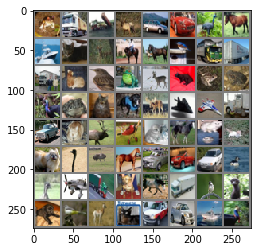

In [5]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

print ("Size of CFAR10 Train Set: ", len(cifar10_train))
    
# get some random training images
dataiter = iter(loader_train)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(64)))

In [6]:
"""
def generator():
    
    # Model - 4 layer Conv Layers
    
    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half        
                    Flatten(),
                    nn.Linear(8192,1024),  # 5408=128*16*16 input size
                    nn.ReLU(inplace=True),
                    nn.Linear(1024,10),
                    )
    return model


def generator():

    # Model2 - 5 layer Conv Layers

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half        
                    Flatten(),
                    nn.Linear(8192,512),  # 5408=128*16*16 input size
                    nn.BatchNorm1d(512),
                    nn.ReLU(inplace=True),
                    nn.Linear(512,10),
                    )
    
    
    return model 

def generator():

    Model - 6 layer Conv Layers

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),        
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half        
                    Flatten(),
                    nn.Linear(16384,1024),  # 5408=128*16*16 input size
                    nn.ReLU(inplace=True),
                    nn.Linear(1024,10),
                    )
    return model


def generator():

    # Model - 5 layer Conv Layers (WIDER)

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=256, kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half        
                    Flatten(),
                    nn.Linear(16384,1024),  # 5408=128*16*16 input siz
                    nn.ReLU(inplace=True),
                    nn.Linear(1024,10),
                    )
    return model
    
def generator():

    # Model - 5 layer Conv Layers (WIDER, BN-RELU)

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.BatchNorm2d(num_features=32),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.BatchNorm2d(num_features=64),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.BatchNorm2d(num_features=128),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.BatchNorm2d(num_features=128),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(in_channels=128,out_channels=256, kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.BatchNorm2d(num_features=256),
                    nn.ReLU(inplace=True),                    
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half        
                    Flatten(),
                    nn.Linear(16384,1024),  # 5408=128*16*16 input siz
                    nn.ReLU(inplace=True),
                    nn.Linear(1024,10),
                    )
    return model    
"""

def generator():

    # Model2a - 5 layer Conv Layers with average pooling

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half        
                    Flatten(),
                    nn.Linear(8192,512),  # 5408=128*16*16 input size
                    nn.BatchNorm1d(512),
                    nn.ReLU(inplace=True),
                    nn.Linear(512,10),
                    )
    
    
    return model 

In [7]:
model = generator().type(gpu_dtype)

x_gpu = torch.randn(64, 3, 32, 32).type(gpu_dtype)
x_var_gpu = Variable(x_gpu.type(gpu_dtype)) # Construct a PyTorch Variable out of your input data
ans = model(x_var_gpu)        # Feed it through the model! 

print (ans.shape)

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([64, 10]))

torch.Size([64, 10])


True

In [69]:
model = generator().type(gpu_dtype)

loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)

optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-10)
# optimizer = optim.Adam(model.parameters(), lr=0.00035, weight_decay=1e-10)

start = time.time()

train(model, loss_fn, optimizer, num_epochs=1)
val_acc = check_accuracy(model, loader_val)

end = time.time()
    
print('validation accuracy is {0}. Training time for 1 epoch: {1:.2f} sec'.format(val_acc, end-start))

validation accuracy is 0.714. Training time for 1 epoch: 7.88 sec


In [70]:
stat = []

start = time.time()
max_count = 20
for count in range(max_count):
    reg = 1e-10
    lr = 10**random.uniform(-5,-2)
    
    model = generator().type(gpu_dtype)
    
    loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
    train(model, loss_fn, optimizer, num_epochs=1)
    val_acc = check_accuracy(model, loader_val)
    
    print('lr = {}, reg = {}, validation accuracy is {}  '.format(lr, reg, val_acc))
    stat.append([lr, reg, val_acc])

    end = time.time()
    
print('Training time for 10 epochs: {1:.2f} sec'.format(val_acc, end-start))

sorted_stat = sorted(stat, key=lambda x: x[0], reverse=True)
print ("In descending order of learning rate:")
for lr, reg, val_acc in sorted_stat:
    print('lr = {}, reg = {}, validation accuracy is {}  '.format(lr, reg, val_acc))    
   

lr = 0.0002519952075212367, reg = 1e-10, validation accuracy is 0.717  
lr = 0.001633470492447633, reg = 1e-10, validation accuracy is 0.736  
lr = 0.00011081016147254782, reg = 1e-10, validation accuracy is 0.689  
lr = 0.002841329094400483, reg = 1e-10, validation accuracy is 0.741  
lr = 7.421413452197237e-05, reg = 1e-10, validation accuracy is 0.681  
lr = 0.007192278034061228, reg = 1e-10, validation accuracy is 0.713  
lr = 0.00013682525043987167, reg = 1e-10, validation accuracy is 0.686  
lr = 2.728635686580113e-05, reg = 1e-10, validation accuracy is 0.595  
lr = 5.2108463128078866e-05, reg = 1e-10, validation accuracy is 0.631  
lr = 0.008638636665321145, reg = 1e-10, validation accuracy is 0.698  
lr = 0.00037212334811446307, reg = 1e-10, validation accuracy is 0.744  
lr = 2.3482701136072882e-05, reg = 1e-10, validation accuracy is 0.612  
lr = 0.00026438551337052373, reg = 1e-10, validation accuracy is 0.701  
lr = 0.0009304354663598096, reg = 1e-10, validation accuracy i

# Adjust Learning Rate 

We turn down regularization (reg=1e-10), and do a coarse learning rate search. We compare the result against the last wider 5-layer CNN we have optimized. IN this version, we add BN layer after the Linear layer.

## Narrower


####  Model 5-Conv Layers, 2 MaxPool Blocks

Sequential(  
  (0): Conv2d (3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
  (1): ReLU(inplace)  
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)  
  (3): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
  (4): ReLU(inplace)  
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)  
  (6): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
  (7): ReLU(inplace)  
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)  
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))  
  (10): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
  (11): ReLU(inplace)  
  (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)  
  (13): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
  (14): ReLU(inplace)  
  (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)  
  (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))  
  (17): Flatten()  
  (18): Linear(in_features=8192, out_features=512)  
  (19): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)  
  (20): ReLU(inplace)  
  (21): Linear(in_features=512, out_features=10)  
)  

* Training time for 1 epoch: 8.80 sec

* In descending order of learning rate:
lr = 0.008638636665321145, reg = 1e-10, validation accuracy is 0.698  
lr = 0.007956677996388002, reg = 1e-10, validation accuracy is 0.715  
lr = 0.007192278034061228, reg = 1e-10, validation accuracy is 0.713  
lr = 0.0043002660125359155, reg = 1e-10, validation accuracy is 0.717  
lr = 0.003168630372966141, reg = 1e-10, validation accuracy is 0.732  
** lr = 0.002841329094400483, reg = 1e-10, validation accuracy is 0.741 **  
lr = 0.001653467549950025, reg = 1e-10, validation accuracy is 0.713  
** lr = 0.001633470492447633, reg = 1e-10, validation accuracy is 0.736 **  
** lr = 0.0009304354663598096, reg = 1e-10, validation accuracy is 0.752 **  
** lr = 0.0006601452786854737, reg = 1e-10, validation accuracy is 0.745 **  
** lr = 0.00037212334811446307, reg = 1e-10, validation accuracy is 0.744 **  
lr = 0.00026438551337052373, reg = 1e-10, validation accuracy is 0.701  
lr = 0.0002519952075212367, reg = 1e-10, validation accuracy is 0.717  
lr = 0.00013682525043987167, reg = 1e-10, validation accuracy is 0.686  
lr = 0.00011081016147254782, reg = 1e-10, validation accuracy is 0.689  
lr = 7.421413452197237e-05, reg = 1e-10, validation accuracy is 0.681  
lr = 5.2108463128078866e-05, reg = 1e-10, validation accuracy is 0.631  
lr = 4.4878163737849904e-05, reg = 1e-10, validation accuracy is 0.643  
lr = 2.728635686580113e-05, reg = 1e-10, validation accuracy is 0.595  
lr = 2.3482701136072882e-05, reg = 1e-10, validation accuracy is 0.612 


####  Model 5-Conv Layers, 2 MaxPool Blocks (WIDER)

Sequential(  
  (0): Conv2d (3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
  (1): ReLU(inplace)  
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)  
  (3): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
  (4): ReLU(inplace)  
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)  
  (6): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
  (7): ReLU(inplace)  
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)  
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))  
  (10): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
  (11): ReLU(inplace)  
  (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)  
  (13): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
  (14): ReLU(inplace)  
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)  
  (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))  
  (17): Flatten()  
  (18): Linear(in_features=16384, out_features=1024)  
  (19): ReLU(inplace)  
  (20): Linear(in_features=1024, out_features=10)  
)  

* Training time for 1 epoch: 13.18 sec

* In descending order of learning rate:
lr = 0.006511131263854212, reg = 1e-10, validation accuracy is 0.447  
lr = 0.005311015630015579, reg = 1e-10, validation accuracy is 0.5  
lr = 0.0050095585969268655, reg = 1e-10, validation accuracy is 0.468  
lr = 0.0019763392774939607, reg = 1e-10, validation accuracy is 0.607  
lr = 0.0016212594827078903, reg = 1e-10, validation accuracy is 0.67  
lr = 0.0012378413601148973, reg = 1e-10, validation accuracy is 0.673  
** lr = 0.0006205094279250759, reg = 1e-10, validation accuracy is 0.737 **  
** lr = 0.0006055617870144327, reg = 1e-10, validation accuracy is 0.726 **  
** lr = 0.0002567453541515327, reg = 1e-10, validation accuracy is 0.757 **  
** lr = 0.00010598921967978786, reg = 1e-10, validation accuracy is 0.717 **  
** lr = 7.918018060365135e-05, reg = 1e-10, validation accuracy is 0.728 **  
lr = 5.3923032925417105e-05, reg = 1e-10, validation accuracy is 0.67  
lr = 2.5770930840799296e-05, reg = 1e-10, validation accuracy is 0.664  
lr = 1.0070525736216065e-05, reg = 1e-10, validation accuracy is 0.598  


In [72]:
stat = []

start = time.time()
max_count = 100
for count in range(max_count):
    reg = 10**random.uniform(-10,-5)
    lr = random.uniform(0.0001, 0.0030)
    
    model = generator().type(gpu_dtype)
    
    loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
    train(model, loss_fn, optimizer, num_epochs=1)
    val_acc = check_accuracy(model, loader_val)
    
    print('lr = {}, reg = {}, validation accuracy is {}  '.format(lr, reg, val_acc))
    stat.append([lr, reg, val_acc])

    end = time.time()
    
print('Training time for 10 epochs: {1:.2f} sec'.format(val_acc, end-start))

sorted_stat = sorted(stat, key=lambda x: x[0], reverse=True)
print ("In descending order of learning rate:")
for lr, reg, val_acc in sorted_stat:
    print('lr = {}, reg = {}, validation accuracy is {}  '.format(lr, reg, val_acc)) 

lr = 0.00276588352158847, reg = 0.43642737374579155, validation accuracy is 0.098  
lr = 0.0012224422766000374, reg = 1.0533766214798928e-06, validation accuracy is 0.745  
lr = 0.0011887949541930256, reg = 1.3699066828730063e-06, validation accuracy is 0.745  
lr = 0.0020939727117735116, reg = 1.4840655628769283e-06, validation accuracy is 0.734  
lr = 0.0002690395415371089, reg = 4.560106321426875e-06, validation accuracy is 0.712  
lr = 0.0005469470537767797, reg = 0.0070135016164842405, validation accuracy is 0.716  
lr = 0.0022625697745325283, reg = 0.0005915894903849822, validation accuracy is 0.696  
lr = 0.00045870132315912804, reg = 0.9339274260088914, validation accuracy is 0.399  
lr = 0.00014066969301833332, reg = 4.6340843031339836e-10, validation accuracy is 0.703  
lr = 0.001348024024291641, reg = 3.5024150945937013e-10, validation accuracy is 0.755  
lr = 0.0004439981810355622, reg = 1.9865748828495076e-10, validation accuracy is 0.745  
lr = 0.0012312254460113265, reg 

lr = 0.0010932230993747254, reg = 0.009350736345830793, validation accuracy is 0.665  
lr = 0.0021191950828622166, reg = 3.116019127450477e-05, validation accuracy is 0.739  
lr = 0.002511276348310533, reg = 2.2386663734215175e-08, validation accuracy is 0.74  
lr = 0.00026074220686614043, reg = 0.00024218005933976478, validation accuracy is 0.72  
lr = 0.0003729941704182108, reg = 0.0020840304580087574, validation accuracy is 0.736  
lr = 0.0029166069286366424, reg = 0.0003431392531278805, validation accuracy is 0.68  
Training time for 10 epochs: 778.48 sec
In descending order of learning rate:
lr = 0.002996894290535968, reg = 9.390131140087249e-05, validation accuracy is 0.728  
lr = 0.0029166069286366424, reg = 0.0003431392531278805, validation accuracy is 0.68  
lr = 0.0029016433787369725, reg = 3.592843768135605e-10, validation accuracy is 0.732  
lr = 0.002891444257181736, reg = 0.005587769776503778, validation accuracy is 0.61  
lr = 0.0028872459323185363, reg = 4.6070019757330

# Finetune Learning Rate + Regularization

* In descending order of learning rate:  
lr = 0.002996894290535968, reg = 9.390131140087249e-05, validation accuracy is 0.728  
lr = 0.0029166069286366424, reg = 0.0003431392531278805, validation accuracy is 0.68  
lr = 0.0029016433787369725, reg = 3.592843768135605e-10, validation accuracy is 0.732  
lr = 0.002891444257181736, reg = 0.005587769776503778, validation accuracy is 0.61  
lr = 0.0028872459323185363, reg = 4.607001975733003e-06, validation accuracy is 0.716  
lr = 0.002864141725830766, reg = 0.0009380612254447275, validation accuracy is 0.679  
lr = 0.0028498202162676217, reg = 0.003854671661759413, validation accuracy is 0.629  
lr = 0.002845704558009121, reg = 0.0032016051552221387, validation accuracy is 0.613  
lr = 0.002816077037147573, reg = 0.00021670963674762182, validation accuracy is 0.727  
lr = 0.002810331624364791, reg = 6.717747122513867e-05, validation accuracy is 0.701  
lr = 0.00279577502363035, reg = 0.001886664839069201, validation accuracy is 0.654  
lr = 0.002781127313159304, reg = 3.4309873883903723e-06, validation accuracy is 0.735  
lr = 0.0027809034445399126, reg = 0.00629500827646668, validation accuracy is 0.611  
lr = 0.0027724551733062067, reg = 0.22007499388634047, validation accuracy is 0.19  
lr = 0.00276588352158847, reg = 0.43642737374579155, validation accuracy is 0.098  
lr = 0.0026958981018319035, reg = 0.012073230475074815, validation accuracy is 0.633  
lr = 0.002665711738052859, reg = 2.8966625335579703e-10, validation accuracy is 0.728  
lr = 0.002532129883964419, reg = 0.003275288131231102, validation accuracy is 0.644  
lr = 0.002513904148721656, reg = 1.4558851515089375e-05, validation accuracy is 0.723  
lr = 0.002511276348310533, reg = 2.2386663734215175e-08, validation accuracy is 0.74  
lr = 0.002496137129203365, reg = 0.0001739397742955975, validation accuracy is 0.714  
lr = 0.0024413523575954536, reg = 2.34296668122049e-08, validation accuracy is 0.735  
lr = 0.00243917195409856, reg = 1.1487565368422733e-06, validation accuracy is 0.704  
lr = 0.0024152431372137556, reg = 1.8823699408821422e-06, validation accuracy is 0.737  
lr = 0.0024045232002221596, reg = 4.6774657778043285e-06, validation accuracy is 0.726  
lr = 0.0022625697745325283, reg = 0.0005915894903849822, validation accuracy is 0.696  
lr = 0.0022435545024786147, reg = 4.0922545560649024e-05, validation accuracy is 0.728  
lr = 0.0022115209447194245, reg = 0.0818990183494728, validation accuracy is 0.284  
lr = 0.002201897081627861, reg = 4.334410849143903e-05, validation accuracy is 0.727  
lr = 0.002160804101474484, reg = 0.13539759901997134, validation accuracy is 0.353  
lr = 0.0021191950828622166, reg = 3.116019127450477e-05, validation accuracy is 0.739  
lr = 0.0020939727117735116, reg = 1.4840655628769283e-06, validation accuracy is 0.734  
lr = 0.0020824788121519985, reg = 7.670618322678373e-09, validation accuracy is 0.729  
lr = 0.0020812178753180127, reg = 0.9284931937851169, validation accuracy is 0.113  
lr = 0.0020516347136830737, reg = 8.883775690987178e-05, validation accuracy is 0.739  
lr = 0.0020481112898611594, reg = 2.280701289811516e-10, validation accuracy is 0.729  
lr = 0.001952097808981533, reg = 0.10050400579789079, validation accuracy is 0.413  
** lr = 0.0019325426927237221, reg = 1.1126563842241455e-08, validation accuracy is 0.745 **  
lr = 0.001925256872154032, reg = 1.3895443643119417e-08, validation accuracy is 0.726  
** lr = 0.0018988739084875121, reg = 5.418542876129896e-07, validation accuracy is 0.762 **  
lr = 0.001839298377846746, reg = 0.00031811290187935197, validation accuracy is 0.709  
lr = 0.001834792706541934, reg = 1.275639386388871e-09, validation accuracy is 0.73  
lr = 0.00176724321533691, reg = 0.004187813291470346, validation accuracy is 0.672  
lr = 0.0017591210866476647, reg = 0.008959804870921028, validation accuracy is 0.643  
** lr = 0.0017375414829225544, reg = 1.2894357413675464e-09, validation accuracy is 0.744 **  
lr = 0.001610237453454654, reg = 5.040138739610208e-08, validation accuracy is 0.739  
lr = 0.0015214460951138052, reg = 0.01633944902252726, validation accuracy is 0.625  
lr = 0.0015154527235340986, reg = 0.012278755208263924, validation accuracy is 0.636  
lr = 0.0015104251265708718, reg = 0.0042716471921663115, validation accuracy is 0.658  
lr = 0.0013955757371453645, reg = 0.24324560326634226, validation accuracy is 0.357  
** lr = 0.001348024024291641, reg = 3.5024150945937013e-10, validation accuracy is 0.755 **  
** lr = 0.0012312254460113265, reg = 8.881750335862797e-08, validation accuracy is 0.748 **  
** lr = 0.0012224422766000374, reg = 1.0533766214798928e-06, validation accuracy is 0.745 **  
** lr = 0.0011887949541930256, reg = 1.3699066828730063e-06, validation accuracy is 0.745 **  
** lr = 0.001161291521284553, reg = 7.110143669687209e-06, validation accuracy is 0.762 **  
lr = 0.001149411613510847, reg = 0.06978303447441318, validation accuracy is 0.586  
lr = 0.0011246771563655172, reg = 3.158321277484722e-05, validation accuracy is 0.736  
lr = 0.0010932230993747254, reg = 0.009350736345830793, validation accuracy is 0.665  
** lr = 0.0010398734461218122, reg = 1.6219177627761332e-09, validation accuracy is 0.756 **  
lr = 0.000996086243693179, reg = 1.6541352150419833e-06, validation accuracy is 0.74  
lr = 0.0009937418938897361, reg = 0.002280075306791466, validation accuracy is 0.687  
lr = 0.0009756761041394955, reg = 0.42436521399842675, validation accuracy is 0.395  
** lr = 0.0009631548077496313, reg = 3.87042600065789e-05, validation accuracy is 0.742 **  
** lr = 0.0009386690722858051, reg = 3.920259546881265e-09, validation accuracy is 0.749 **  
** lr = 0.0009126331401475738, reg = 2.2388793805215536e-08, validation accuracy is 0.747 **  
lr = 0.0008945859210733966, reg = 0.6379497856476078, validation accuracy is 0.35  
** lr = 0.0008679665660522135, reg = 4.0183556374207435e-09, validation accuracy is 0.742 **  
** lr = 0.0008498760833853844, reg = 2.005637340423437e-09, validation accuracy is 0.744 **  
lr = 0.000846653517571234, reg = 0.11173181524682754, validation accuracy is 0.584  
** lr = 0.0008385220998588157, reg = 5.453401291925546e-08, validation accuracy is 0.751 **  
lr = 0.000803414324748689, reg = 0.14295926750875515, validation accuracy is 0.561  
lr = 0.0007441919619492854, reg = 0.20974535072197467, validation accuracy is 0.545  
** lr = 0.0007417124720433882, reg = 3.0511558642491654e-09, validation accuracy is 0.753 **  
lr = 0.0007286750301390614, reg = 1.1463429939886476e-09, validation accuracy is 0.733  
** lr = 0.0007256507000297291, reg = 1.2059006103931855e-08, validation accuracy is 0.755 **  
lr = 0.0006579514598278617, reg = 8.141079124710387e-06, validation accuracy is 0.739  
lr = 0.0005811335804245308, reg = 0.0047354441653918306, validation accuracy is 0.695  
lr = 0.0005469470537767797, reg = 0.0070135016164842405, validation accuracy is 0.716  
lr = 0.0004609021238573164, reg = 4.3465855987842305e-07, validation accuracy is 0.735  
lr = 0.00045870132315912804, reg = 0.9339274260088914, validation accuracy is 0.399  
** lr = 0.0004501177470580983, reg = 9.371367435254824e-09, validation accuracy is 0.749 **  
** lr = 0.0004439981810355622, reg = 1.9865748828495076e-10, validation accuracy is 0.745 **  
** lr = 0.00042832468567419445, reg = 1.2124241675608312e-08, validation accuracy is 0.747 **  
lr = 0.0004204282010990998, reg = 2.6581292295821016e-09, validation accuracy is 0.734  
lr = 0.00041034705665279886, reg = 6.713372366779281e-10, validation accuracy is 0.727  
lr = 0.0003729941704182108, reg = 0.0020840304580087574, validation accuracy is 0.736  
lr = 0.00036824010835135787, reg = 0.0051818203618860855, validation accuracy is 0.721  
lr = 0.00033870675959950225, reg = 0.0015359417713310803, validation accuracy is 0.71  
lr = 0.00032456170829562784, reg = 0.00869125322161918, validation accuracy is 0.705  
lr = 0.0002690395415371089, reg = 4.560106321426875e-06, validation accuracy is 0.712  
lr = 0.00026074220686614043, reg = 0.00024218005933976478, validation accuracy is 0.72  
lr = 0.0002291489119870799, reg = 8.084081080702946e-10, validation accuracy is 0.713  
lr = 0.0002279355853216759, reg = 5.345134198694281e-07, validation accuracy is 0.721  
lr = 0.00019479488088952634, reg = 5.058450037923126e-10, validation accuracy is 0.708  
lr = 0.00016662015012136502, reg = 0.011186413044720803, validation accuracy is 0.683  
lr = 0.00014066969301833332, reg = 4.6340843031339836e-10, validation accuracy is 0.703  
lr = 0.00014014198756942924, reg = 1.5006994042884239e-06, validation accuracy is 0.695  
lr = 0.00012905489735355805, reg = 3.2521235260797144e-06, validation accuracy is 0.717  
lr = 0.00010623662122880728, reg = 3.6528234005379847e-09, validation accuracy is 0.684  
lr = 0.00010285040590405588, reg = 3.462622993378285e-09, validation accuracy is 0.665   

Starting epoch 1 / 5
better val accuracy: update model.
progress: [0.735, 0.729, 0.01577588626864005, 0.011777903378009796]
Starting epoch 2 / 5
better val accuracy: update model.
progress: [0.828, 0.77, 0.009145142892793733, 0.010240195870399475]
Starting epoch 3 / 5
better val accuracy: update model.
progress: [0.897, 0.793, 0.005337652037338335, 0.010703087538480758]
Starting epoch 4 / 5
better val accuracy: update model.
progress: [0.947, 0.807, 0.0025540652829317413, 0.0108774955868721]
Starting epoch 5 / 5
better val accuracy: update model.
progress: [0.964, 0.819, 0.0013761921721909727, 0.011864563465118409]
Regularization = 5e-08.
Best validation accuracy is 0.819. Training time for 5 epochs: 39.75 sec


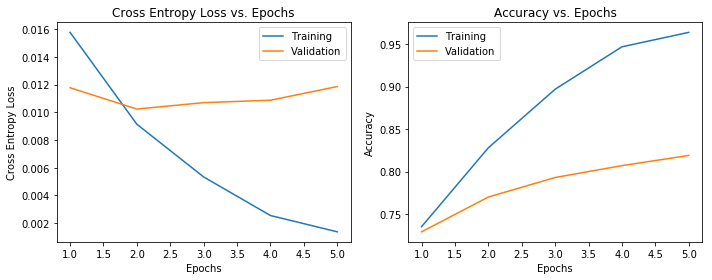

Starting epoch 1 / 5
better val accuracy: update model.
progress: [0.731, 0.741, 0.016073151368875892, 0.011502545416355134]
Starting epoch 2 / 5
better val accuracy: update model.
progress: [0.848, 0.803, 0.009075784617540788, 0.009386560142040253]
Starting epoch 3 / 5
better val accuracy: update model.
progress: [0.911, 0.806, 0.005283569325445866, 0.01026330828666687]
Starting epoch 4 / 5
better val accuracy: update model.
progress: [0.943, 0.821, 0.0024649768933957938, 0.010872296184301376]
Starting epoch 5 / 5
progress: [0.956, 0.811, 0.0013991289959118074, 0.013304850369691848]
Regularization = 1e-06.
Best validation accuracy is 0.821. Training time for 5 epochs: 40.26 sec


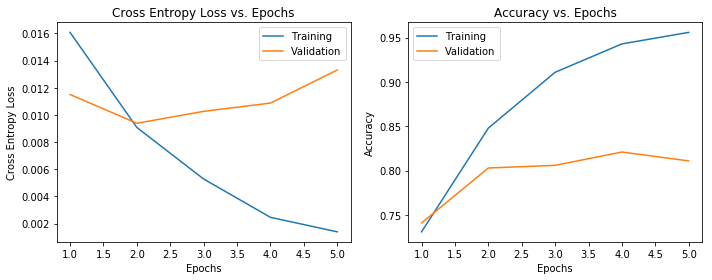

In [220]:
epochs = 5

lr = 1.2e-3
reg_list = [5e-8,1e-6]

for reg in reg_list:
    
    best_val_acc=0.0
    model = generator().type(gpu_dtype)

    loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

    start = time.time()
    
    file_name = 'model2'+'_reg='+str(reg)+'lr='+str(lr)+'ep='+str(epochs)+'bestacc.pt'
    best_val_acc, results = train_detailed(model, loss_fn, optimizer, file_name, 
                                                    num_epochs=epochs, verbose=False)

    end = time.time()
    
    print('Regularization = {}.'.format(reg))    
    print('Best validation accuracy is {0}. Training time for {1} epochs: {2:.2f} sec'.format(best_val_acc, 
                                                                                              epochs, end-start))

    # Plot out the accuracies and losses
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(list(range(1,len(np.array(results)[:,2])+1)), np.array(results)[:,2], label='Training')
    plt.plot(list(range(1,len(np.array(results)[:,3])+1)), np.array(results)[:,3], label='Validation')
    plt.title('Cross Entropy Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Cross Entropy Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(list(range(1,len(np.array(results)[:,0])+1)), np.array(results)[:,0], label='Training')
    plt.plot(list(range(1,len(np.array(results)[:,1])+1)), np.array(results)[:,1], label='Validation')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()

    #plt.savefig('sgd_model_plot_batch_norm_hidden_256x256.png')
    plt.show()

We finetune regularization from 1e-9 to 1e-7, and train for 10 epochs to arrive at following val accuracies:

Regularization = 1e-09.  
Best validation accuracy is 0.829. Training time for 10 epochs: 79.67 sec  
** Regularization = 5e-09.  
Best validation accuracy is 0.83. Training time for 10 epochs: 79.87 sec  
Regularization = 1e-08.  
Best validation accuracy is 0.83. Training time for 10 epochs: 82.70 sec  
Regularization = 5e-08.  
Best validation accuracy is 0.844. Training time for 10 epochs: 81.63 sec  
Regularization = 1e-07.  
Best validation accuracy is 0.831. Training time for 10 epochs: 82.04 sec  
Regularization = 5e-07.  
Best validation accuracy is 0.83. Training time for 10 epochs: 80.64 sec **  
Regularization = 1e-06.  
Best validation accuracy is 0.826. Training time for 10 epochs: 80.83 sec  


In [100]:
print (optimizer.param_groups[0]["lr"])


0.00108


In [99]:
files = ['model2_reg=1e-09lr=0.0012ep=10bestacc.pt',
         'model2_reg=5e-09lr=0.0012ep=10bestacc.pt',
         'model2_reg=1e-08lr=0.0012ep=10bestacc.pt',
         'model2_reg=5e-08lr=0.0012ep=10bestacc.pt',
         'model2_reg=1e-07lr=0.0012ep=10bestacc.pt',
         'model2_reg=5e-07lr=0.0012ep=10bestacc.pt',         
         'model2_reg=1e-06lr=0.0012ep=10bestacc.pt']

for file_name in files:
    best_model = generator().type(gpu_dtype)
    best_model.load_state_dict(torch.load(file_name))

    acc = check_accuracy(best_model, loader_test)
    print ("Model {} has test accuracy of {}".format(file_name, acc))



Model model2_reg=1e-09lr=0.0012ep=10bestacc.pt has test accuracy of 0.8166
Model model2_reg=5e-09lr=0.0012ep=10bestacc.pt has test accuracy of 0.8166
Model model2_reg=1e-08lr=0.0012ep=10bestacc.pt has test accuracy of 0.8077
Model model2_reg=5e-08lr=0.0012ep=10bestacc.pt has test accuracy of 0.8147
Model model2_reg=1e-07lr=0.0012ep=10bestacc.pt has test accuracy of 0.8131
Model model2_reg=5e-07lr=0.0012ep=10bestacc.pt has test accuracy of 0.8103
Model model2_reg=1e-06lr=0.0012ep=10bestacc.pt has test accuracy of 0.8179


In [71]:
print(model)

Sequential(
  (0): Conv2d (3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (3): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace)
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (6): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (10): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (13): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU(inplace)
  (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (17): Flatten(
  )
  (18): Linear(in_features=8192, out_f

## Long Training Sessions

We will conduct a 50 epoch training on the 3 hyperparameter configurations
* lr = 0.0012 reg=[5e-08, 1e-7, 2e-7] gives consistently over 83% test accuracy
* lr = 0.0015 reg=[5e-08, 1e-7, 2e-7] also gives consistently over 83% test accuracy


Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.735, 0.757, 1.025116517341215, 0.7432591557502747]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.847, 0.796, 0.587860042713826, 0.6150659183661144]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.914, 0.824, 0.34481591386537924, 0.6697919487953186]
Starting epoch 4 / 50
progress: [0.934, 0.807, 0.1666044071949775, 0.735520867506663]
Starting epoch 5 / 50
progress: [0.955, 0.818, 0.09505354838287519, 0.8350458105405172]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.98, 0.826, 0.0577728937873069, 0.7816820780436198]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.986, 0.832, 0.03788545745321446, 0.8222917139530181]
Starting epoch 8 / 50
progress: [0.971, 0.812, 0.03143869542936776, 1.0098616480827332]
Starting epoch 9 / 50
progress: [0.982, 0.81, 0.038253814484802334, 0.9892472505569458]
Starting epoch 10 / 50
progress: [0.986, 

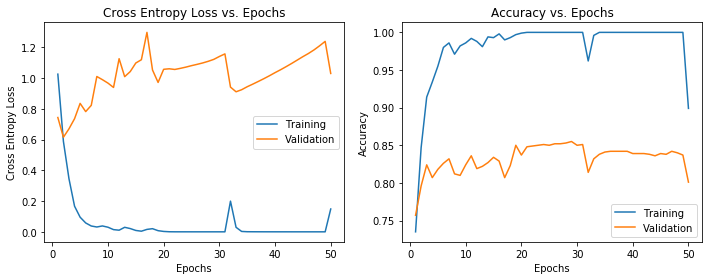

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.733, 0.728, 1.0458726848262587, 0.7806885401407878]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.819, 0.78, 0.6085587688520843, 0.675376848379771]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.902, 0.79, 0.35915762092552933, 0.6936850706736247]
Starting epoch 4 / 50
progress: [0.922, 0.777, 0.17701008245348931, 0.8308687249819438]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.958, 0.81, 0.0970997489599231, 0.7982104639212291]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.978, 0.826, 0.05624126143071776, 0.7656915644804637]
Starting epoch 7 / 50
progress: [0.983, 0.817, 0.03506120692792476, 0.9045050740242004]
Starting epoch 8 / 50
progress: [0.982, 0.81, 0.03473792727245322, 0.9479191740353902]
Starting epoch 9 / 50
progress: [0.986, 0.805, 0.03581056347774232, 0.9534812966982523]
Starting epoch 10 / 50
better val accurac

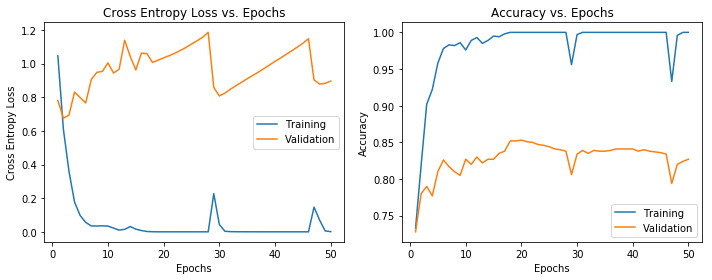

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.717, 0.727, 1.0001297107709, 0.7981349349021911]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.829, 0.777, 0.5832918995346119, 0.6612757643063863]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.896, 0.795, 0.34338651086185495, 0.6560872197151184]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.951, 0.826, 0.1624833997801628, 0.7006023248036702]
Starting epoch 5 / 50
progress: [0.954, 0.809, 0.08645754784978683, 0.85969051917394]
Starting epoch 6 / 50
progress: [0.977, 0.803, 0.055817336522140146, 0.8387282093365988]
Starting epoch 7 / 50
progress: [0.989, 0.814, 0.035328898560012284, 0.9190839330355326]
Starting epoch 8 / 50
progress: [0.982, 0.807, 0.03390550815189878, 0.9616882681846619]
Starting epoch 9 / 50
progress: [0.977, 0.805, 0.032050029984279686, 0.9997539202372233]
Starting epoch 10 / 50
progress: [0.99, 0.811, 0.025170501248509277, 1.00

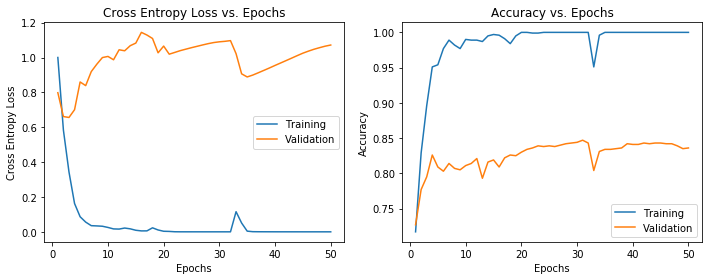

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.737, 0.744, 1.0031825133008894, 0.7560059706370036]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.855, 0.79, 0.5755313497937583, 0.6606237570444743]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.888, 0.794, 0.3353185924829221, 0.7111316025257111]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.923, 0.815, 0.1691107352866846, 0.7429063558578491]
Starting epoch 5 / 50
progress: [0.965, 0.815, 0.09202712675544367, 0.7334417442480723]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.966, 0.83, 0.05279101196834757, 0.789811392625173]
Starting epoch 7 / 50
progress: [0.984, 0.829, 0.03330382579767139, 0.9065596620241801]
Starting epoch 8 / 50
better val accuracy: update model.
progress: [0.977, 0.832, 0.038754559660732164, 0.9191127856572469]
Starting epoch 9 / 50
progress: [0.981, 0.826, 0.035779522487199775, 0.9357172469298045]
Sta

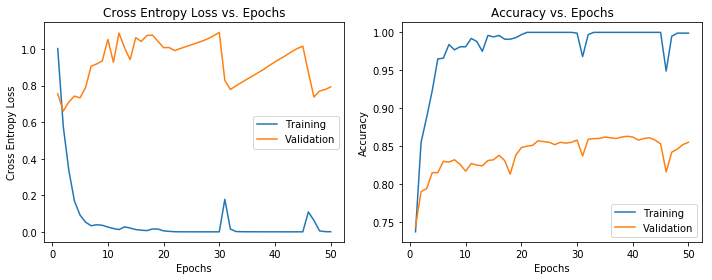

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.734, 0.746, 1.0478111451747372, 0.7771323521931967]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.838, 0.785, 0.5961645095956092, 0.6573736727237701]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.905, 0.798, 0.3433631786139183, 0.6620874961217245]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.937, 0.801, 0.16962807233037513, 0.8491170883178711]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.937, 0.818, 0.10266187979529301, 0.8138426045576731]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.979, 0.84, 0.05996241723522057, 0.8004361788431803]
Starting epoch 7 / 50
progress: [0.972, 0.812, 0.037143261627190644, 0.9495397289594014]
Starting epoch 8 / 50
progress: [0.974, 0.804, 0.041827087357542876, 0.9973586559295654]
Starting epoch 9 / 50
progress: [0.975, 0.821, 0.041795101583466616, 1.0350293080012003]

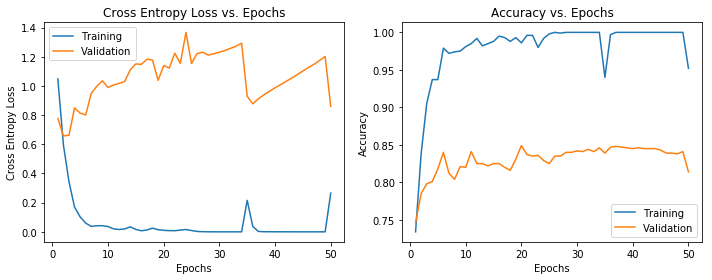

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.721, 0.741, 1.0451002366792144, 0.7673324386278788]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.821, 0.786, 0.603940370717859, 0.6706155995527904]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.894, 0.799, 0.3538754401253719, 0.7059944967428843]
Starting epoch 4 / 50
progress: [0.929, 0.788, 0.17276538346522774, 0.830501381556193]
Starting epoch 5 / 50
progress: [0.953, 0.795, 0.09754866332521821, 0.8328398823738098]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.963, 0.803, 0.057458059400855716, 0.9087473710378011]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.986, 0.806, 0.03959245341312554, 0.9882845282554626]
Starting epoch 8 / 50
better val accuracy: update model.
progress: [0.986, 0.816, 0.035531612037029724, 0.9451902389526368]
Starting epoch 9 / 50
better val accuracy: update model.
progress: [0.979, 0.82, 0.035249

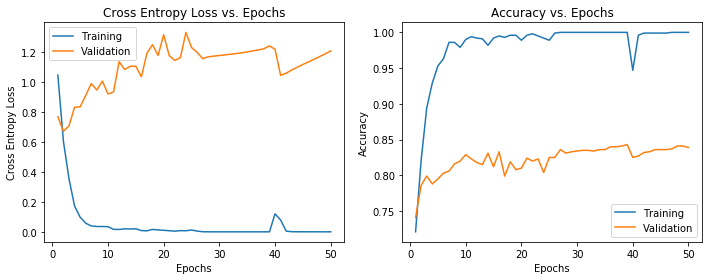

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.737, 0.736, 1.030257690186594, 0.7819876194000244]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.829, 0.787, 0.6044697038293664, 0.6592435995737712]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.901, 0.802, 0.3593621567573423, 0.6808271567026775]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.946, 0.815, 0.17426141266729317, 0.7254414061705271]
Starting epoch 5 / 50
progress: [0.957, 0.789, 0.09220144352053895, 0.9108151813348134]
Starting epoch 6 / 50
progress: [0.984, 0.812, 0.05572703772291444, 0.8435668090979258]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.986, 0.837, 0.031235512377682077, 0.8972203373908997]
Starting epoch 8 / 50
progress: [0.975, 0.812, 0.03252267929987093, 0.8994351267814636]
Starting epoch 9 / 50
progress: [0.977, 0.816, 0.04281548612866721, 0.9258063554763794]
Starting epoch 10 / 50
progress: [0.

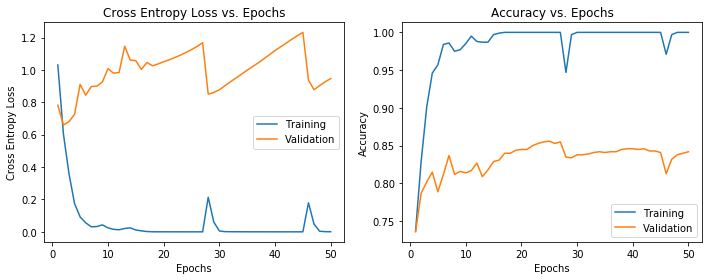

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.718, 0.735, 1.0526239197238598, 0.795178206761678]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.819, 0.786, 0.6087915762187609, 0.7017650187015534]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.893, 0.797, 0.36033946210457607, 0.6991073310375213]
Starting epoch 4 / 50
progress: [0.936, 0.782, 0.17715066386009354, 0.8159877339998881]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.957, 0.817, 0.10490508392891464, 0.8002152045567831]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.984, 0.833, 0.058027444564390414, 0.7996629973252615]
Starting epoch 7 / 50
progress: [0.982, 0.806, 0.04024041096247684, 0.9517188787460327]
Starting epoch 8 / 50
progress: [0.979, 0.829, 0.04682134539801992, 0.9054785966873169]
Starting epoch 9 / 50
progress: [0.97, 0.828, 0.0425388994231041, 0.9346948186556499]
Starting epoch 10 / 50
progress: [0.9

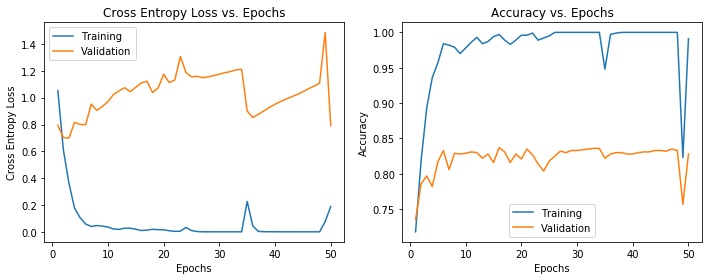

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.711, 0.713, 1.0538814034726884, 0.8524282733599345]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.834, 0.763, 0.6051042598641776, 0.7104605893294017]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.883, 0.787, 0.354016574184879, 0.7602615276972453]
Starting epoch 4 / 50
progress: [0.932, 0.771, 0.16567111537834397, 0.9037372986475627]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.962, 0.798, 0.09940601736185403, 0.8549277822176615]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.978, 0.808, 0.05512396201028738, 0.8769167800744374]
Starting epoch 7 / 50
progress: [0.984, 0.799, 0.03422133732173178, 1.068640148639679]
Starting epoch 8 / 50
progress: [0.985, 0.799, 0.039126191694240746, 1.0253529310226441]
Starting epoch 9 / 50
progress: [0.97, 0.806, 0.03908207568528703, 1.0806653141975402]
Starting epoch 10 / 50
better val accu

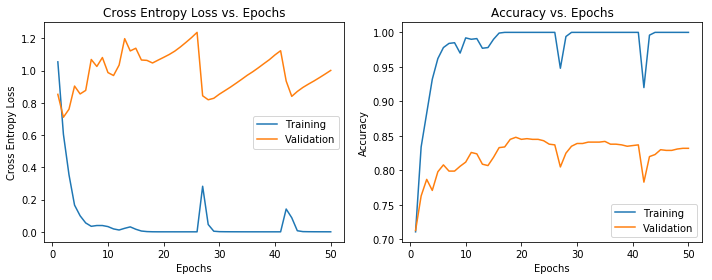

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.722, 0.737, 1.0137806221161014, 0.7900596698125203]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.834, 0.776, 0.586283255441516, 0.7031068702538809]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.898, 0.794, 0.3426626394679344, 0.7515758434931438]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.923, 0.816, 0.1669045275332881, 0.8175391991933186]
Starting epoch 5 / 50
progress: [0.96, 0.812, 0.09899188113928425, 0.8561939398447672]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.977, 0.829, 0.053034767728858914, 0.866680634021759]
Starting epoch 7 / 50
progress: [0.975, 0.814, 0.03457769625241947, 1.067298209667206]
Starting epoch 8 / 50
progress: [0.97, 0.808, 0.03704271570846341, 1.0035354534784953]
Starting epoch 9 / 50
progress: [0.982, 0.812, 0.04326444752514362, 1.0182015657424928]
Starting epoch 10 / 50
progress: [0.99, 0

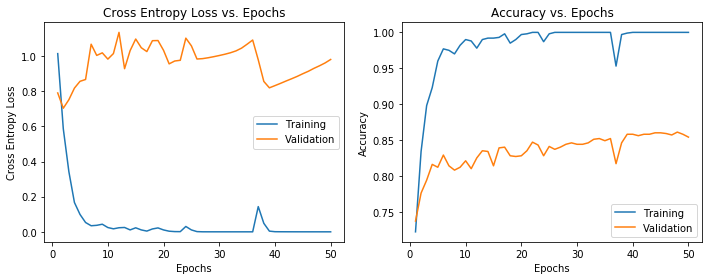

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.724, 0.728, 1.0483875310888477, 0.7982121149698893]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.825, 0.78, 0.6061552187001783, 0.6681219518184662]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.88, 0.79, 0.3573321977082421, 0.7223133027553559]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.928, 0.797, 0.1731982257874573, 0.8794982592264812]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.947, 0.798, 0.10198690918779452, 0.9224674900372823]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.977, 0.809, 0.061872709605818484, 0.9071953376134236]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.989, 0.818, 0.041343859788882574, 0.9410895466804504]
Starting epoch 8 / 50
progress: [0.984, 0.816, 0.03400973419056219, 1.0094610591729483]
Starting epoch 9 / 50
progress: [0.985, 0.807, 0.0347724

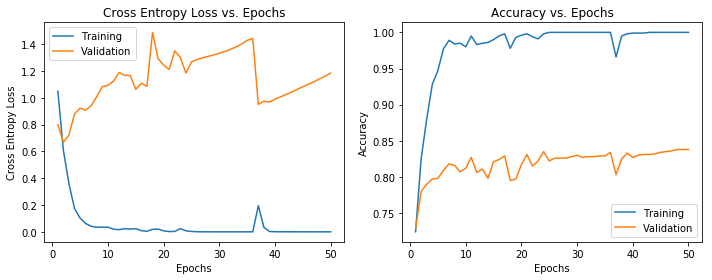

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.731, 0.749, 1.0057113511110443, 0.7689941207567851]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.835, 0.799, 0.5932855930788065, 0.6687208771705627]
Starting epoch 3 / 50
progress: [0.882, 0.786, 0.3549849634758787, 0.7701897978782654]
Starting epoch 4 / 50
progress: [0.941, 0.792, 0.17290452928373626, 0.8124867777029673]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.958, 0.806, 0.09539215852768203, 0.8723775823911031]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.98, 0.812, 0.05368901088200753, 0.8872084776560466]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.987, 0.821, 0.03334469090769786, 0.9235507249832153]
Starting epoch 8 / 50
progress: [0.98, 0.804, 0.02880607891365204, 0.9797090530395508]
Starting epoch 9 / 50
better val accuracy: update model.
progress: [0.976, 0.826, 0.036149238375642524, 0.9561570604642232]
St

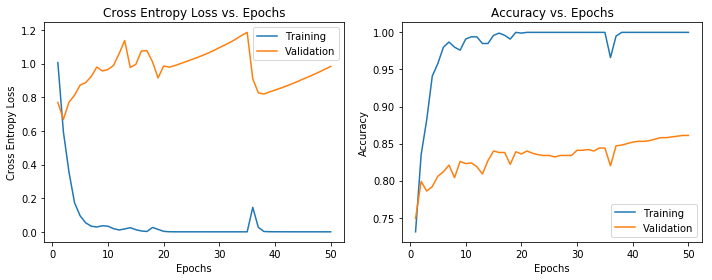

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.711, 0.718, 1.0355931005057166, 0.8295991023381551]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.839, 0.782, 0.5972350263128093, 0.6665814856688181]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.903, 0.789, 0.351181349489424, 0.7421684602896372]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.928, 0.799, 0.17063396372436698, 0.8527438640594482]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.957, 0.804, 0.09848330282405311, 0.9067192633946737]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.975, 0.806, 0.055586933142511674, 0.87216215133667]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.974, 0.807, 0.032621817262782384, 0.9869290709495544]
Starting epoch 8 / 50
progress: [0.972, 0.803, 0.039030499283370435, 0.9962522069613139]
Starting epoch 9 / 50
progress: [0.988, 0.803, 0.03911

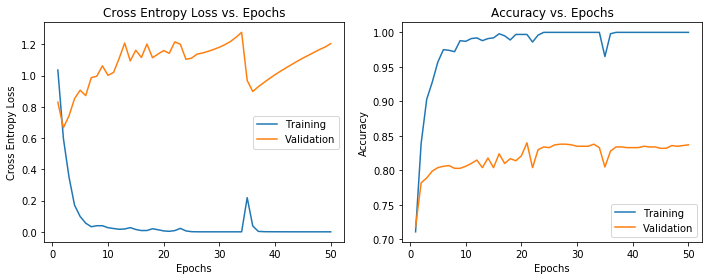

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.749, 0.745, 0.9766041877612569, 0.7507327795028687]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.838, 0.803, 0.5620961470736398, 0.6589176257451376]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.909, 0.807, 0.32322815797882143, 0.6909841775894165]
Starting epoch 4 / 50
progress: [0.925, 0.799, 0.15642486165454186, 0.8215633591016134]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.963, 0.815, 0.09337822140918837, 0.8197740058104197]
Starting epoch 6 / 50
progress: [0.98, 0.801, 0.051807924266295886, 0.9502678513526917]
Starting epoch 7 / 50
progress: [0.98, 0.804, 0.0315658733035663, 1.0178497910499573]
Starting epoch 8 / 50
better val accuracy: update model.
progress: [0.985, 0.817, 0.030882975344661792, 1.0007551312446594]
Starting epoch 9 / 50
progress: [0.988, 0.813, 0.03468357561083109, 0.9933770100275675]
Starting epoch 10 / 50
progress: [0.

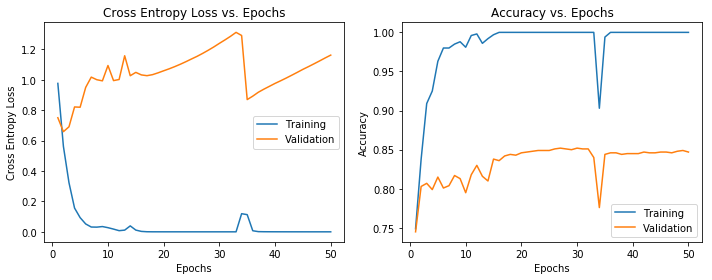

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.73, 0.734, 1.0164676068265455, 0.7898534854253133]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.835, 0.77, 0.592991897600149, 0.7101086040337881]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.888, 0.795, 0.35148391375939053, 0.7174450079600017]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.94, 0.808, 0.17348631628685526, 0.7978107810020447]
Starting epoch 5 / 50
progress: [0.951, 0.805, 0.10014289700931389, 0.9135383725166321]
Starting epoch 6 / 50
progress: [0.97, 0.792, 0.05650215995638004, 0.9745023767153422]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.989, 0.83, 0.03817152731984951, 0.8738224446773529]
Starting epoch 8 / 50
progress: [0.959, 0.791, 0.037548824656584295, 1.0884109377861022]
Starting epoch 9 / 50
progress: [0.987, 0.808, 0.03985251140494654, 1.0529960115750632]
Starting epoch 10 / 50
progress: [0.987,

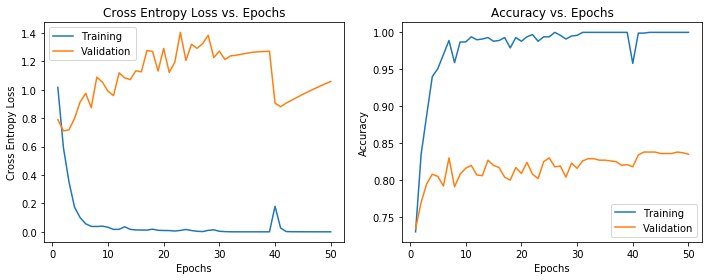

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.723, 0.743, 1.000060542580349, 0.7663216908772786]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.829, 0.767, 0.5884609062687244, 0.704510486125946]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.898, 0.786, 0.3458416321990537, 0.7455006162325541]
Starting epoch 4 / 50
progress: [0.93, 0.78, 0.16591846862552212, 0.8090648114681244]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.963, 0.8, 0.09599683304725129, 0.850518407424291]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.974, 0.82, 0.056068438561207135, 0.8763232866923014]
Starting epoch 7 / 50
progress: [0.984, 0.82, 0.03523753050690383, 0.973804525534312]
Starting epoch 8 / 50
progress: [0.975, 0.809, 0.03266384014920666, 1.0830309867858887]
Starting epoch 9 / 50
progress: [0.987, 0.815, 0.03467802143126142, 1.0111047108968099]
Starting epoch 10 / 50
progress: [0.987, 0.80

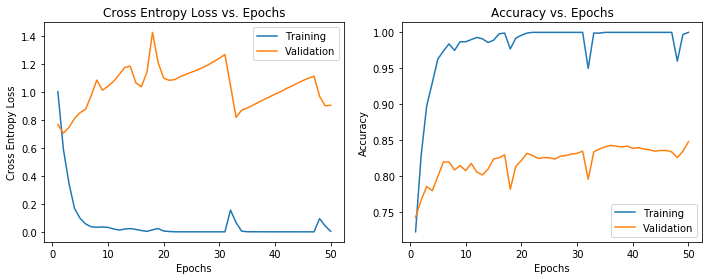

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.71, 0.745, 1.0522924157529094, 0.7907418012619019]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.834, 0.778, 0.5973989166855033, 0.7046236217021942]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.91, 0.804, 0.3474607049006652, 0.706574547290802]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.944, 0.822, 0.16968612337570174, 0.7407211383183797]
Starting epoch 5 / 50
progress: [0.951, 0.819, 0.09691752558878435, 0.8206268668174743]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.977, 0.83, 0.05602576939474329, 0.8309907893339793]
Starting epoch 7 / 50
progress: [0.981, 0.824, 0.035752108853821664, 0.9574797848860422]
Starting epoch 8 / 50
progress: [0.973, 0.816, 0.03737762689687847, 0.9866980850696564]
Starting epoch 9 / 50
progress: [0.971, 0.812, 0.03995576058179627, 1.0654495616753896]
Starting epoch 10 / 50
progress: [0.982

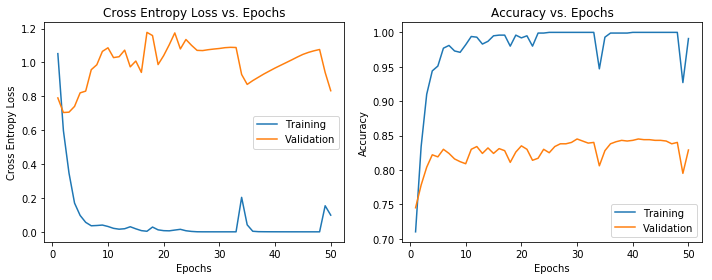

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.736, 0.748, 1.03477556588603, 0.7735635181268056]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.829, 0.786, 0.586441335958593, 0.6655989944934845]
Starting epoch 3 / 50
progress: [0.866, 0.78, 0.3404035417472615, 0.7860632201035818]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.949, 0.817, 0.1674553674006579, 0.7507474879423778]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.955, 0.821, 0.10044605585996037, 0.8544922689596812]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.99, 0.835, 0.052824359942909356, 0.8132454733053843]
Starting epoch 7 / 50
progress: [0.979, 0.815, 0.03627706841182183, 0.9392376720905304]
Starting epoch 8 / 50
progress: [0.988, 0.82, 0.029164606526347937, 0.9865725994110107]
Starting epoch 9 / 50
progress: [0.976, 0.819, 0.0397814589369969, 0.987625527381897]
Starting epoch 10 / 50
progress: [0.982, 0.

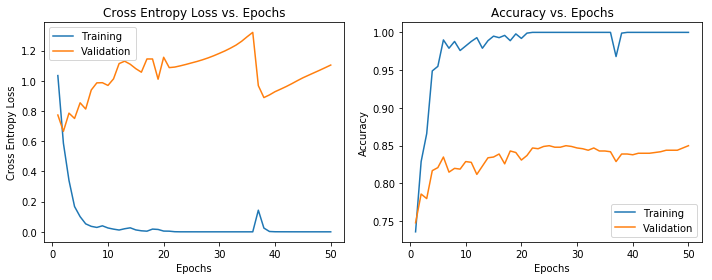

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.724, 0.741, 1.0404326754847384, 0.7831798752148946]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.814, 0.787, 0.5990829992917628, 0.6881109535694122]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.899, 0.789, 0.3476417401647256, 0.7618585129578909]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.933, 0.794, 0.16994842706747304, 0.8173105855782826]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.951, 0.798, 0.0983639726938765, 0.9722199877103169]
Starting epoch 6 / 50
progress: [0.965, 0.793, 0.058985675020399045, 0.9704739054044088]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.967, 0.8, 0.03635818002002886, 1.0159172773361207]
Starting epoch 8 / 50
better val accuracy: update model.
progress: [0.976, 0.807, 0.03848133583620093, 0.9719620704650879]
Starting epoch 9 / 50
better val accuracy: update model.

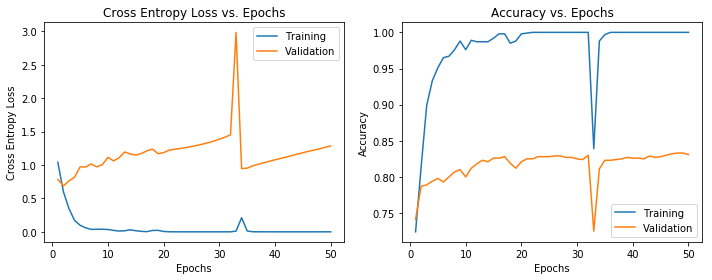

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.705, 0.716, 1.0657006503320208, 0.8295418500900269]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.813, 0.768, 0.6185856141685661, 0.7042023817698161]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.901, 0.798, 0.3680529691035451, 0.7208091894785563]
Starting epoch 4 / 50
progress: [0.921, 0.785, 0.17611592736314324, 0.9383565624554951]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.961, 0.824, 0.10721587326645461, 0.7577375988165538]
Starting epoch 6 / 50
progress: [0.981, 0.813, 0.0554631679617112, 0.8238587240378062]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.976, 0.825, 0.039699025718750905, 0.8995737373828888]
Starting epoch 8 / 50
progress: [0.976, 0.818, 0.042229716191250904, 0.9799457490444183]
Starting epoch 9 / 50
progress: [0.982, 0.798, 0.04635891306755784, 1.0645924309889476]
Starting epoch 10 / 50
progress: [0

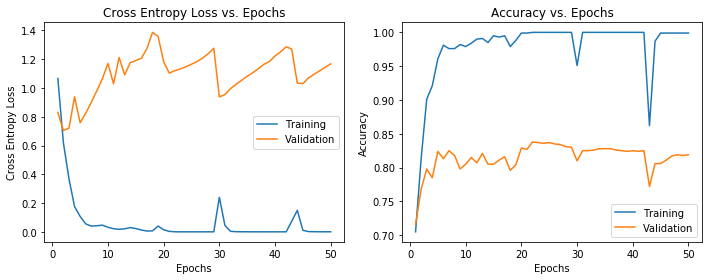

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.706, 0.712, 1.0534539879147524, 0.8615314483642578]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.805, 0.781, 0.6083712971483181, 0.667099247376124]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.893, 0.811, 0.3528497616839565, 0.6774799267450968]
Starting epoch 4 / 50
progress: [0.927, 0.796, 0.17087247560129445, 0.7932309806346893]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.958, 0.812, 0.102276701784504, 0.8789811074733734]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.966, 0.822, 0.05752180515745886, 0.8335610588391622]
Starting epoch 7 / 50
progress: [0.982, 0.809, 0.04364609597798656, 0.9422640721003215]
Starting epoch 8 / 50
progress: [0.977, 0.816, 0.03989984268639115, 1.0685072064399719]
Starting epoch 9 / 50
progress: [0.976, 0.819, 0.03812666613413812, 0.9855550746122996]
Starting epoch 10 / 50
progress: [0.987

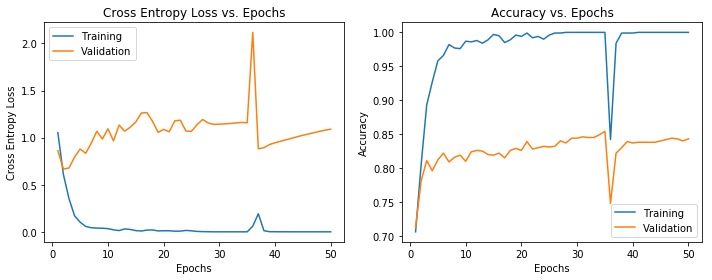

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.716, 0.725, 1.0279621128163308, 0.8390388449033102]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.828, 0.774, 0.5998981775801167, 0.7023240884145101]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.886, 0.79, 0.353131815333382, 0.789501025279363]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.943, 0.805, 0.17210078699136871, 0.8546513398488362]
Starting epoch 5 / 50
progress: [0.959, 0.791, 0.098726940388773, 0.9883176783720652]
Starting epoch 6 / 50
progress: [0.969, 0.805, 0.059708986271878865, 1.0134625514348348]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.984, 0.819, 0.040339049134476515, 0.9532042026519776]
Starting epoch 8 / 50
progress: [0.983, 0.81, 0.031131779876677625, 0.9190424342950185]
Starting epoch 9 / 50
progress: [0.976, 0.799, 0.03942773867812421, 1.1553935130437216]
Starting epoch 10 / 50
progress: [0.98,

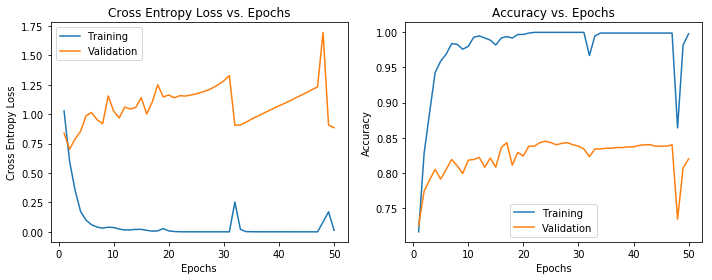

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.73, 0.716, 1.0527580762221143, 0.8137285153071085]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.816, 0.765, 0.6080019111726799, 0.7394686857859294]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.89, 0.801, 0.35885738013616575, 0.7128764629364014]
Starting epoch 4 / 50
progress: [0.932, 0.788, 0.1766274517341182, 0.8321873009204864]
Starting epoch 5 / 50
progress: [0.948, 0.794, 0.1041546695494379, 0.8998148063818614]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.98, 0.814, 0.060001996854697565, 0.888011360168457]
Starting epoch 7 / 50
progress: [0.988, 0.811, 0.03619449962405305, 0.9807179609934489]
Starting epoch 8 / 50
progress: [0.978, 0.811, 0.04434067220214048, 1.0020277162392934]
Starting epoch 9 / 50
progress: [0.984, 0.812, 0.04239109832294334, 0.9942315260569254]
Starting epoch 10 / 50
better val accuracy: update model.
progress: [0.979,

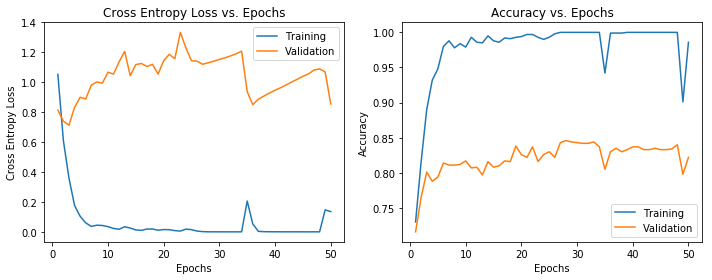

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.718, 0.733, 1.0469472844226688, 0.7936804135640462]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.813, 0.77, 0.59251265050539, 0.7131060103575388]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.882, 0.771, 0.3417451944226533, 0.8033939023812612]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.944, 0.795, 0.1636587603516828, 0.8202252745628357]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.959, 0.819, 0.09397972097462104, 0.7991986354192098]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.985, 0.83, 0.05858641913026766, 0.8327933490276337]
Starting epoch 7 / 50
progress: [0.974, 0.809, 0.04013244075323242, 0.9338130354881287]
Starting epoch 8 / 50
progress: [0.984, 0.799, 0.0396021058935112, 0.951108439763387]
Starting epoch 9 / 50
progress: [0.983, 0.792, 0.038142503791312184, 1.0669623772303263]
Startin

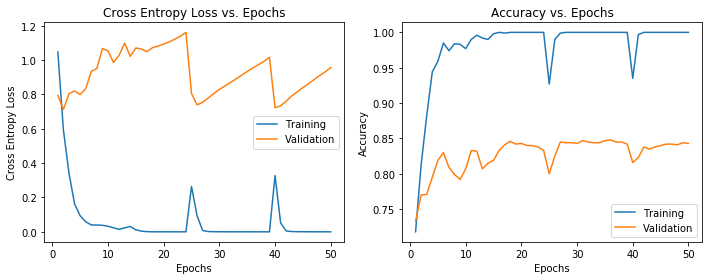

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.735, 0.751, 1.0102117471835192, 0.7690514723459879]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.834, 0.792, 0.5830933648776385, 0.6344302554925283]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.897, 0.799, 0.34408300776107636, 0.6719635546207428]
Starting epoch 4 / 50
progress: [0.924, 0.788, 0.168962498566781, 0.7700802505016326]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.97, 0.814, 0.0915318431137921, 0.7880022287368774]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.978, 0.816, 0.051170969562105886, 0.8328626394271851]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.986, 0.817, 0.031406336887648295, 0.8939047376314799]
Starting epoch 8 / 50
progress: [0.969, 0.805, 0.035742532974413405, 1.0503338972727458]
Starting epoch 9 / 50
better val accuracy: update model.
progress: [0.984, 0.823, 0.03765

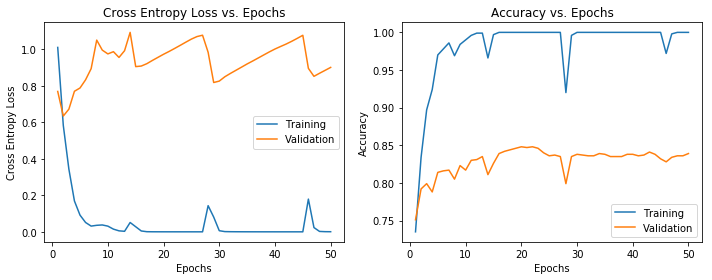

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.729, 0.725, 1.0832769459758709, 0.8033632516860962]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.841, 0.793, 0.6178647162477955, 0.6675000826517741]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.901, 0.801, 0.3621732252875185, 0.7011691749095916]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.95, 0.807, 0.16948106147689757, 0.7531353394190471]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.959, 0.811, 0.09773570347114716, 0.8586091299851736]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.978, 0.831, 0.05266725343524241, 0.9173011898994445]
Starting epoch 7 / 50
progress: [0.986, 0.826, 0.032905444165606514, 0.9532347202301026]
Starting epoch 8 / 50
progress: [0.979, 0.825, 0.031943307625239385, 0.9929635683695476]
Starting epoch 9 / 50
progress: [0.985, 0.815, 0.0410990395711041, 0.979716428120931]
St

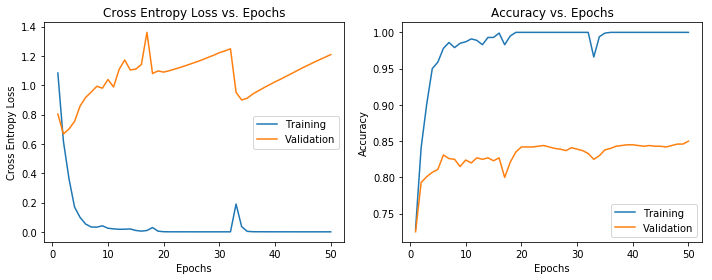

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.733, 0.733, 1.044558700821758, 0.7670197327931721]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.823, 0.776, 0.6021958695128073, 0.6926569203535716]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.892, 0.801, 0.35388123161262935, 0.675026532014211]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.925, 0.807, 0.1684870528580706, 0.770000410079956]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.957, 0.814, 0.09920837290682434, 0.791912990808487]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.968, 0.834, 0.0598855755358837, 0.8231239199638367]
Starting epoch 7 / 50
progress: [0.983, 0.82, 0.03735533952773883, 0.8988283336162567]
Starting epoch 8 / 50
progress: [0.971, 0.817, 0.03401679104510573, 0.955827526251475]
Starting epoch 9 / 50
progress: [0.978, 0.824, 0.03767900610452189, 0.980999497572581]
Starting 

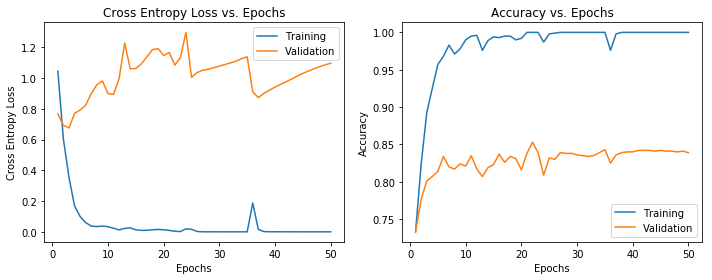

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.72, 0.727, 1.0769035555957969, 0.8088337202866872]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.835, 0.783, 0.6107506927711511, 0.6957042495409648]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.894, 0.798, 0.36275857508766884, 0.7151414593060811]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.929, 0.816, 0.17532217326555766, 0.8200241267681122]
Starting epoch 5 / 50
progress: [0.953, 0.815, 0.10096850230973335, 0.8730207661787669]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.975, 0.817, 0.05784796264655644, 0.8699904163678487]
Starting epoch 7 / 50
progress: [0.978, 0.809, 0.04197015602725978, 0.9493370076020559]
Starting epoch 8 / 50
progress: [0.969, 0.815, 0.04128166223857917, 1.1242773294448853]
Starting epoch 9 / 50
progress: [0.982, 0.807, 0.03579818677922613, 1.070439386367798]
Starting epoch 10 / 50
progress: [0.9

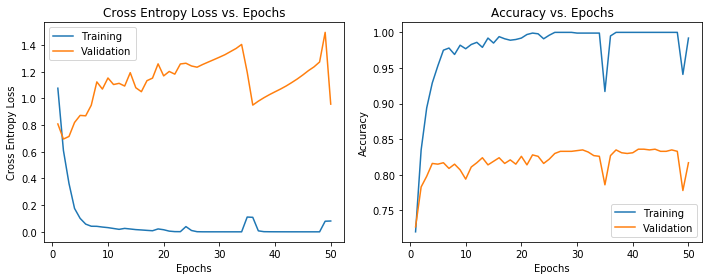

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.746, 0.747, 0.9778124472674201, 0.7513970136642456]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.839, 0.8, 0.5687175783066968, 0.6672874192396799]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.914, 0.811, 0.3310001228808188, 0.678974042336146]
Starting epoch 4 / 50
progress: [0.939, 0.801, 0.16249078161819697, 0.7623306492964427]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.97, 0.827, 0.09063457676690388, 0.7197133878866832]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.978, 0.835, 0.058844361532163, 0.7968055744965871]
Starting epoch 7 / 50
progress: [0.986, 0.831, 0.03517796679679913, 0.8179018894831339]
Starting epoch 8 / 50
progress: [0.971, 0.832, 0.03249524257395392, 0.860653430223465]
Starting epoch 9 / 50
progress: [0.983, 0.827, 0.03412357066983199, 0.874264125029246]
Starting epoch 10 / 50
progress: [0.984, 0.8

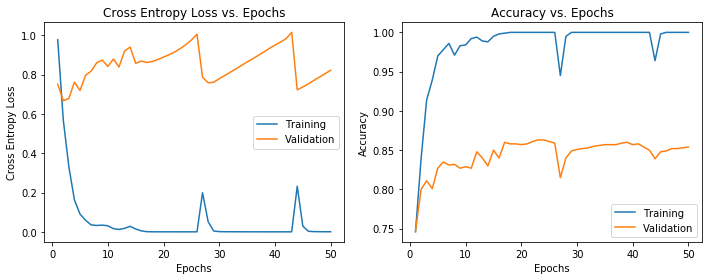

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.721, 0.721, 1.0125108913268919, 0.7889692823092143]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.837, 0.788, 0.5893111467166664, 0.7044306874275208]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.905, 0.8, 0.3420489258918108, 0.6897008379300436]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.931, 0.82, 0.1624724218950552, 0.81094438234965]
Starting epoch 5 / 50
progress: [0.949, 0.799, 0.09491219071099181, 0.8611299912134807]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.979, 0.825, 0.052246860557180995, 0.839690633614858]
Starting epoch 7 / 50
progress: [0.985, 0.821, 0.029315558494086943, 0.9003190994262695]
Starting epoch 8 / 50
progress: [0.964, 0.801, 0.03845702774481836, 1.0580535491307577]
Starting epoch 9 / 50
progress: [0.983, 0.802, 0.04259907706865883, 1.0521791994571685]
Starting epoch 10 / 50
progress: [0.988, 

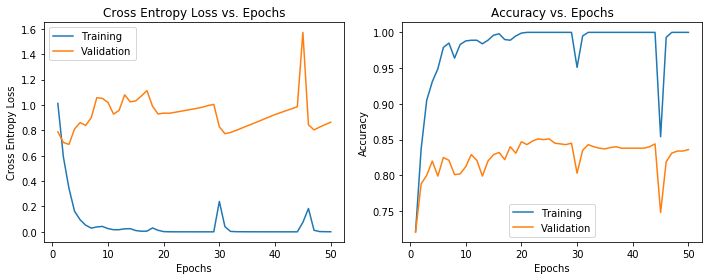

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.733, 0.733, 0.9898541723201477, 0.7807496110598247]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.833, 0.789, 0.573762269717416, 0.6769306222597758]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.896, 0.796, 0.34090538884397426, 0.6998048742612203]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.934, 0.799, 0.16119184331371894, 0.7829131603240966]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.968, 0.819, 0.09474467654389883, 0.8528219819068908]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.982, 0.82, 0.05457017798025429, 0.865951943397522]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.988, 0.825, 0.036461824816621205, 0.8963026523590087]
Starting epoch 8 / 50
progress: [0.974, 0.82, 0.0365483047191078, 1.0285682717959086]
Starting epoch 9 / 50
progress: [0.98, 0.805, 0.030448934

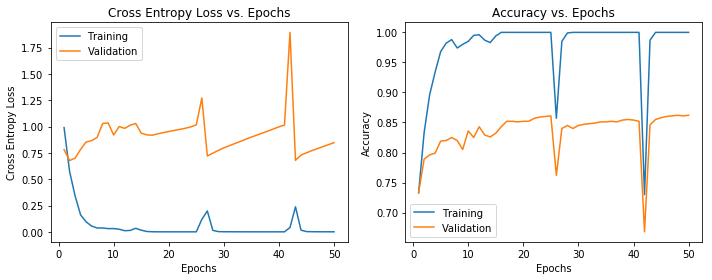

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.744, 0.748, 0.9724436272593106, 0.7595650553703308]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.83, 0.813, 0.5668857715098686, 0.6260006050268809]
Starting epoch 3 / 50
progress: [0.9, 0.792, 0.3322421609771018, 0.706469335158666]
Starting epoch 4 / 50
progress: [0.949, 0.81, 0.16153556627580543, 0.7107483923435212]
Starting epoch 5 / 50
progress: [0.966, 0.808, 0.08731081133428352, 0.7969141562779745]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.98, 0.82, 0.054449214867857934, 0.7955963710943857]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.985, 0.831, 0.03158059120756495, 0.8443050463994344]
Starting epoch 8 / 50
progress: [0.974, 0.824, 0.037642121926144835, 0.8137605905532836]
Starting epoch 9 / 50
progress: [0.992, 0.822, 0.03677556476513155, 0.8238392988840739]
Starting epoch 10 / 50
progress: [0.979, 0.831, 0.024439121055982862, 0.8648

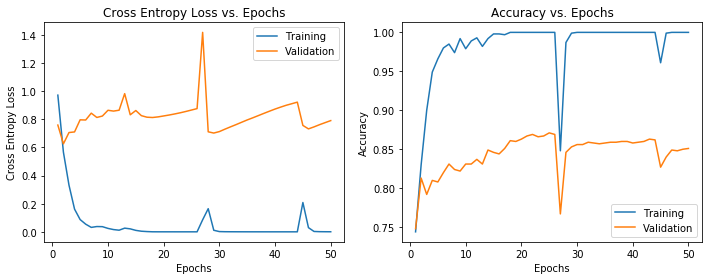

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.739, 0.729, 0.9827338476586186, 0.7956707715988159]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.825, 0.782, 0.5712422127817192, 0.6829553961753845]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.887, 0.799, 0.3334464075810769, 0.6804162005583445]
Starting epoch 4 / 50
progress: [0.933, 0.794, 0.15387555579198342, 0.8112027982870738]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.96, 0.809, 0.09012281396517567, 0.8064889272054037]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.98, 0.811, 0.054507274181868126, 0.8487202207247416]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.985, 0.826, 0.03177178129919019, 0.9108970562616984]
Starting epoch 8 / 50
progress: [0.983, 0.801, 0.02944433696787147, 0.9960157950719197]
Starting epoch 9 / 50
progress: [0.983, 0.807, 0.03671882303821203, 0.9618784825007121]
St

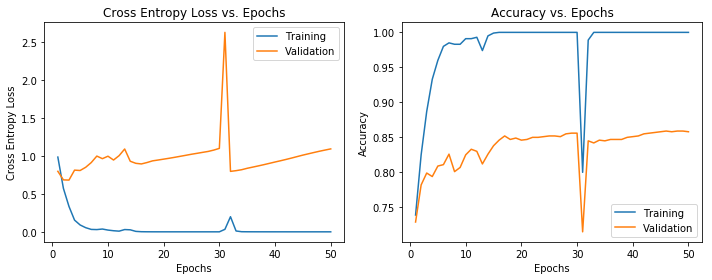

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.729, 0.73, 1.0582210185481054, 0.8085676749547323]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.842, 0.788, 0.6064701246864656, 0.6898106833299001]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.897, 0.803, 0.35242709305161746, 0.7204639414946238]
Starting epoch 4 / 50
progress: [0.929, 0.794, 0.16488250736755872, 0.8008935550848643]
Starting epoch 5 / 50
progress: [0.955, 0.802, 0.09968232776653144, 0.895770420630773]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.98, 0.818, 0.054098861970104814, 0.8484529495239258]
Starting epoch 7 / 50
progress: [0.976, 0.807, 0.03110569828658614, 1.0224393685658772]
Starting epoch 8 / 50
progress: [0.975, 0.8, 0.04334693026844583, 0.9747579614321391]
Starting epoch 9 / 50
progress: [0.98, 0.804, 0.04185138412757344, 1.0596401810646057]
Starting epoch 10 / 50
progress: [0.986, 0.814, 0.029375380986777982, 1.084

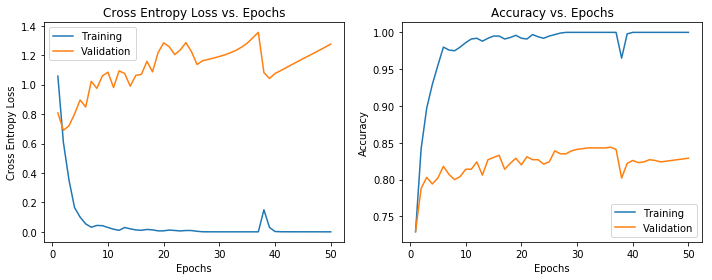

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.742, 0.74, 1.0021087284181631, 0.7948802868525188]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.825, 0.781, 0.5753701750749077, 0.6855276525020599]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.904, 0.807, 0.3361110643721094, 0.7012212077776591]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.934, 0.812, 0.16630414698053808, 0.8324710587660472]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.962, 0.822, 0.09362921674364533, 0.827682779232661]
Starting epoch 6 / 50
progress: [0.972, 0.807, 0.05350038691064696, 0.9404591123263041]
Starting epoch 7 / 50
progress: [0.981, 0.808, 0.03716412446479879, 0.9409703254699707]
Starting epoch 8 / 50
better val accuracy: update model.
progress: [0.984, 0.828, 0.03500971962923026, 0.8919876535733541]
Starting epoch 9 / 50
better val accuracy: update model.
progress: [0.982, 0.834, 0.0343299

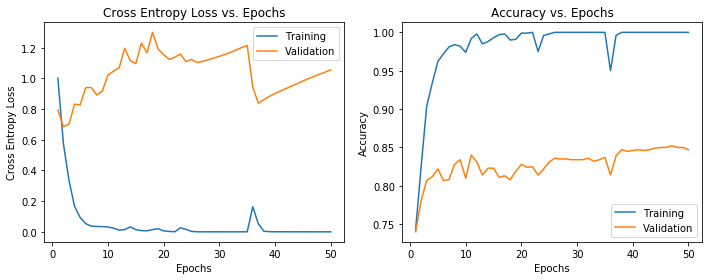

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.733, 0.758, 1.0439671212941213, 0.7392621298631032]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.837, 0.805, 0.586803276593389, 0.6342417180538178]
Starting epoch 3 / 50
progress: [0.899, 0.803, 0.33912239765224894, 0.7354461153348287]
Starting epoch 4 / 50
progress: [0.941, 0.795, 0.16165322674547924, 0.915183440844218]
Starting epoch 5 / 50
progress: [0.963, 0.782, 0.09815581482804679, 1.0121899684270224]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.98, 0.82, 0.05371854566281138, 0.9043805241584778]
Starting epoch 7 / 50
progress: [0.988, 0.818, 0.03495733224500725, 1.0357604066530863]
Starting epoch 8 / 50
progress: [0.978, 0.816, 0.03611658017753678, 1.0661028583844503]
Starting epoch 9 / 50
progress: [0.977, 0.788, 0.03966515041960805, 1.2017830650011698]
Starting epoch 10 / 50
progress: [0.992, 0.81, 0.029901534612016643, 1.0691515723864238]
Starting epoch 11 / 

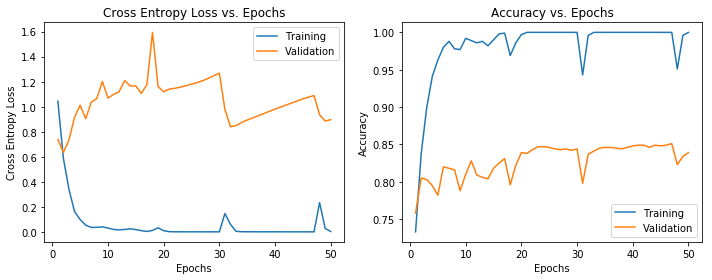

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.717, 0.737, 1.0627910859834135, 0.7844699025154114]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.807, 0.783, 0.6108732022491156, 0.7035746375719706]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.899, 0.799, 0.36221078918650257, 0.717235267162323]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.924, 0.809, 0.1825048205631426, 0.7989247838656107]
Starting epoch 5 / 50
progress: [0.958, 0.808, 0.09991261368751331, 0.8918912430604299]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.97, 0.828, 0.061198948217811536, 0.9003368258476258]
Starting epoch 7 / 50
progress: [0.978, 0.811, 0.041541190186113706, 1.082329418261846]
Starting epoch 8 / 50
progress: [0.975, 0.811, 0.0438299417775733, 1.0281203587849934]
Starting epoch 9 / 50
progress: [0.979, 0.8, 0.042735531423362644, 1.0391411701838176]
Starting epoch 10 / 50
progress: [0.977

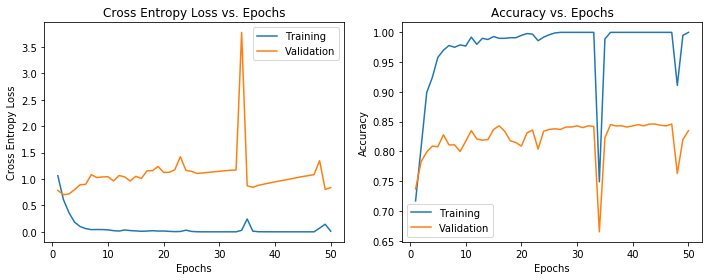

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.734, 0.732, 1.0093064342059341, 0.7896283626556396]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.844, 0.795, 0.5813248727251502, 0.6939238965511322]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.901, 0.801, 0.34448286539881057, 0.6938449283440907]
Starting epoch 4 / 50
progress: [0.933, 0.79, 0.16521834836773622, 0.8267163117726644]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.969, 0.815, 0.09740055982096522, 0.850344838698705]
Starting epoch 6 / 50
progress: [0.977, 0.815, 0.05749288641184179, 0.880970815817515]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.976, 0.817, 0.033667436550109606, 0.9026399672031402]
Starting epoch 8 / 50
progress: [0.969, 0.805, 0.031211629835280037, 1.0301848073800406]
Starting epoch 9 / 50
better val accuracy: update model.
progress: [0.982, 0.827, 0.03531399079555877, 0.945577069123586]
St

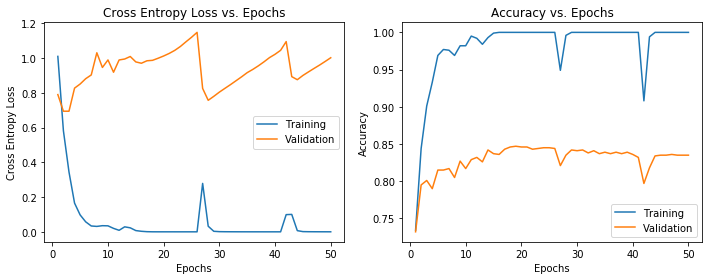

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.753, 0.757, 0.9837731831214007, 0.7297642787297567]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.851, 0.788, 0.5686345558540494, 0.6311042030652364]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.905, 0.8, 0.3350981680347639, 0.6950275977452596]
Starting epoch 4 / 50
progress: [0.946, 0.789, 0.16091861032631272, 0.7768706540266673]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.952, 0.807, 0.0902799830473716, 0.8906962037086487]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.977, 0.81, 0.05586269233022737, 0.7922828455766042]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.983, 0.817, 0.03464786691767669, 0.8698849201202392]
Starting epoch 8 / 50
progress: [0.979, 0.816, 0.031114309042497398, 0.8443739473819732]
Starting epoch 9 / 50
better val accuracy: update model.
progress: [0.985, 0.823, 0.03285316

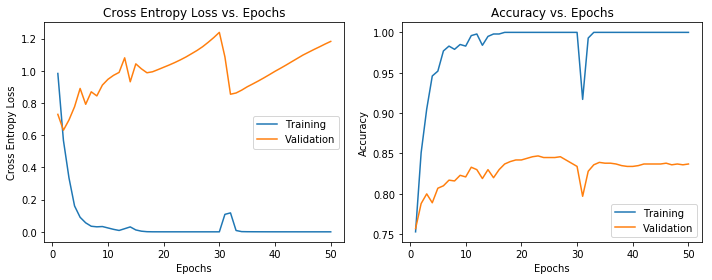

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.713, 0.734, 1.0069290819900487, 0.7820900440216064]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.835, 0.793, 0.5843198317717883, 0.677299420038859]
Starting epoch 3 / 50
progress: [0.9, 0.787, 0.3433111499045409, 0.7601888656616211]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.935, 0.809, 0.16660773802329512, 0.7835226436456044]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.967, 0.821, 0.09519218688502032, 0.8049343307813008]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.979, 0.825, 0.058914300876066965, 0.7958482921123504]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.986, 0.831, 0.03325571941236168, 0.8381022850672404]
Starting epoch 8 / 50
progress: [0.984, 0.815, 0.03696194968119361, 1.0222848534584046]
Starting epoch 9 / 50
progress: [0.984, 0.81, 0.036391115522779086, 0.9526307344436645]
Sta

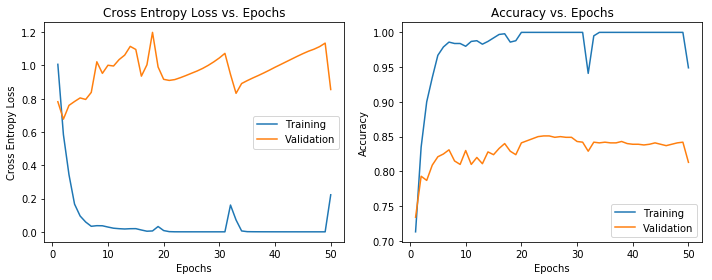

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.734, 0.735, 0.9967898462722504, 0.7699763019879658]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.838, 0.791, 0.5830937906612758, 0.6708457628885905]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.9, 0.798, 0.342690013037398, 0.7347314993540446]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.942, 0.811, 0.16581265917108728, 0.7641363561153411]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.97, 0.816, 0.09317242699657001, 0.8119862496852874]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.979, 0.828, 0.05624113412744372, 0.8597276449203491]
Starting epoch 7 / 50
progress: [0.982, 0.82, 0.03771507035137391, 0.9659357666969299]
Starting epoch 8 / 50
progress: [0.988, 0.812, 0.03545415883189907, 0.9738838096459707]
Starting epoch 9 / 50
progress: [0.98, 0.808, 0.040355965400759884, 1.0605768700440725]
Starti

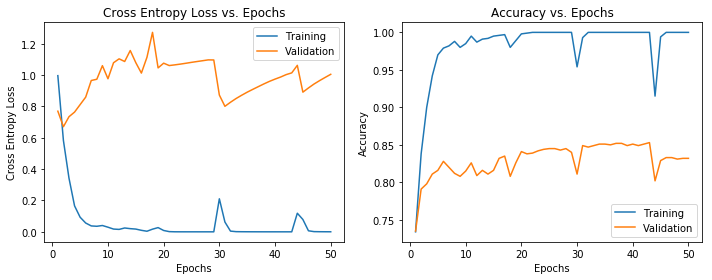

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.731, 0.736, 1.0608835706913393, 0.7909571886062622]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.816, 0.779, 0.602033463529512, 0.7162614703178406]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.896, 0.806, 0.3462085713553273, 0.7216399172941844]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.94, 0.808, 0.1660157486163323, 0.8443956057230632]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.962, 0.811, 0.10063900150650856, 0.854839273293813]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.982, 0.817, 0.05521426691119772, 0.9081532041231791]
Starting epoch 7 / 50
progress: [0.981, 0.808, 0.036520286843034565, 0.969941512743632]
Starting epoch 8 / 50
progress: [0.972, 0.817, 0.038995067346415, 1.0769132296244304]
Starting epoch 9 / 50
progress: [0.978, 0.812, 0.04265925702943278, 1.091300936539968]
Starting

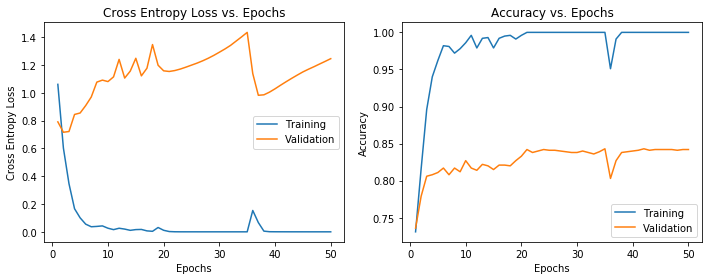

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.721, 0.734, 1.047551712646983, 0.8132311463356018]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.832, 0.788, 0.5916636792273303, 0.7040959775447846]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.884, 0.794, 0.34115402703386505, 0.7569469809532166]
Starting epoch 4 / 50
progress: [0.939, 0.793, 0.15856701027772396, 0.8336849669615428]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.953, 0.805, 0.0913613496847402, 0.9452641646067301]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.973, 0.811, 0.057707234570646984, 0.8981047868728638]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.99, 0.831, 0.03649901431906068, 0.9088279167811076]
Starting epoch 8 / 50
progress: [0.98, 0.815, 0.03389863820649148, 1.014474833011627]
Starting epoch 9 / 50
progress: [0.979, 0.811, 0.03646409504444283, 0.9776566505432129]
Star

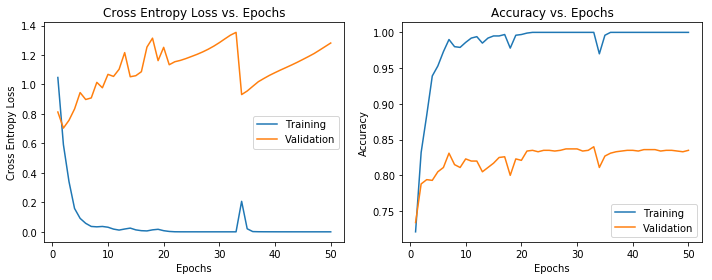

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.722, 0.72, 1.0304808400814829, 0.7910293062527974]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.845, 0.789, 0.6055396521013546, 0.6602306167284647]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.895, 0.793, 0.35775731302359526, 0.6751228908697764]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.943, 0.799, 0.17274720285063475, 0.7170198520024618]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.958, 0.825, 0.09356668275214877, 0.7851698080698649]
Starting epoch 6 / 50
progress: [0.985, 0.817, 0.05640364791589235, 0.789639804760615]
Starting epoch 7 / 50
progress: [0.975, 0.822, 0.031910657443812274, 0.9149344543615977]
Starting epoch 8 / 50
progress: [0.981, 0.809, 0.036011610360316984, 0.9205788950125376]
Starting epoch 9 / 50
progress: [0.985, 0.806, 0.03564442361893704, 1.1000483135382335]
Starting epoch 10 / 50
progress: [0

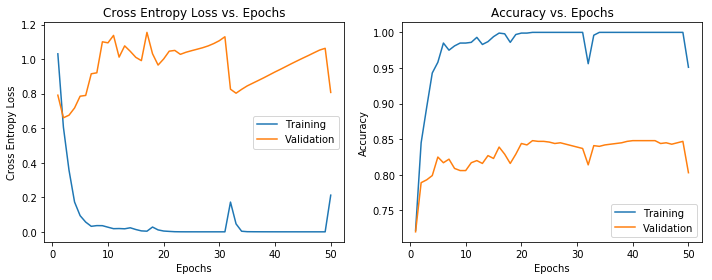

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.69, 0.718, 1.0477677895742303, 0.8648131489753723]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.83, 0.789, 0.6156855093497856, 0.6665392259756724]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.879, 0.796, 0.36483444862700753, 0.7369729499022166]
Starting epoch 4 / 50
progress: [0.943, 0.785, 0.17367242017359125, 0.841063630580902]
Starting epoch 5 / 50
progress: [0.938, 0.796, 0.09671310349276253, 0.9300680081049602]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.97, 0.814, 0.058573192941158814, 0.9388654390970866]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.982, 0.819, 0.03473002497605931, 0.8710431019465129]
Starting epoch 8 / 50
progress: [0.985, 0.806, 0.029452529605904144, 1.0022470116615296]
Starting epoch 9 / 50
progress: [0.991, 0.815, 0.044028230120117466, 1.0224334160486857]
Starting epoch 10 / 50
progress: [0.

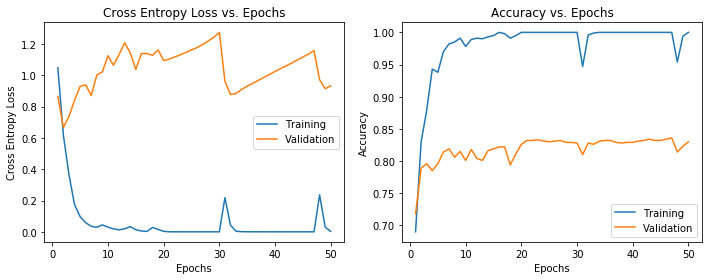

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.72, 0.728, 1.0496294969826743, 0.8040109634399414]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.831, 0.794, 0.6044380887661105, 0.671481051047643]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.91, 0.805, 0.34927410270556125, 0.695993310213089]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.938, 0.806, 0.1658532958502084, 0.8085124254226684]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.962, 0.821, 0.09959092067883295, 0.8076088587443034]
Starting epoch 6 / 50
progress: [0.972, 0.814, 0.055048625604584324, 0.9127947747707367]
Starting epoch 7 / 50
progress: [0.979, 0.807, 0.034269097886882184, 0.9524040977160136]
Starting epoch 8 / 50
progress: [0.973, 0.786, 0.04048885264817406, 1.0143741408983866]
Starting epoch 9 / 50
progress: [0.988, 0.81, 0.04033898566271257, 0.9724739591280619]
Starting epoch 10 / 50
progress: [0.99,

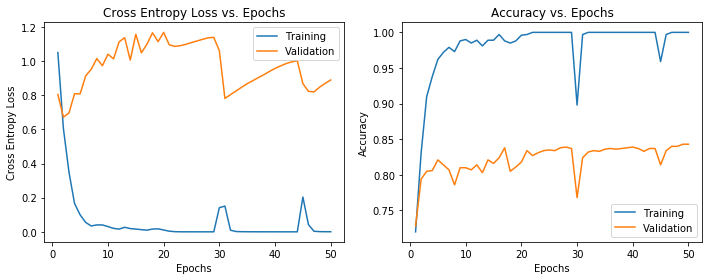

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.718, 0.71, 1.0389621395301196, 0.8202672600746155]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.832, 0.786, 0.6009657915511163, 0.66510023077329]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.892, 0.796, 0.3534104576103048, 0.7082553585370381]
Starting epoch 4 / 50
progress: [0.929, 0.785, 0.17027034512629696, 0.8769910295804342]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.966, 0.801, 0.09486284738077837, 0.8375885089238485]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.968, 0.806, 0.05292670308533155, 0.9409283558527629]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.97, 0.807, 0.033096801614985356, 1.023004937171936]
Starting epoch 8 / 50
progress: [0.977, 0.804, 0.03461613823976246, 1.0210841159025827]
Starting epoch 9 / 50
better val accuracy: update model.
progress: [0.983, 0.816, 0.037856817

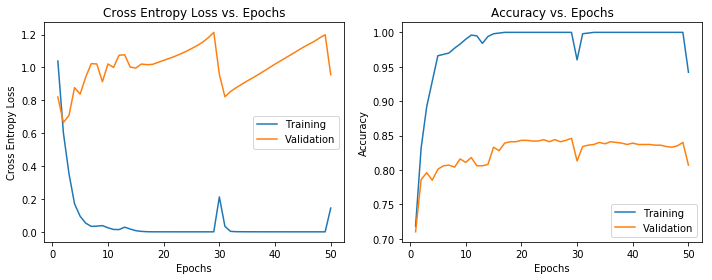

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.725, 0.729, 1.0693151853832543, 0.8012043039004008]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.821, 0.774, 0.6086713769077475, 0.6972399095694224]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.888, 0.796, 0.3573228363799893, 0.7372104942798614]
Starting epoch 4 / 50
progress: [0.94, 0.778, 0.1719743581281768, 0.8082629998524984]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.965, 0.802, 0.1021651056065571, 0.8166624188423157]
Starting epoch 6 / 50
progress: [0.967, 0.802, 0.061689574259266355, 0.8881332874298096]
Starting epoch 7 / 50
progress: [0.972, 0.8, 0.04387556316233636, 0.9402732690175374]
Starting epoch 8 / 50
better val accuracy: update model.
progress: [0.988, 0.811, 0.04012916535199955, 0.9279315352439881]
Starting epoch 9 / 50
better val accuracy: update model.
progress: [0.988, 0.815, 0.04028496205368463, 0.9929157773653666]
Start

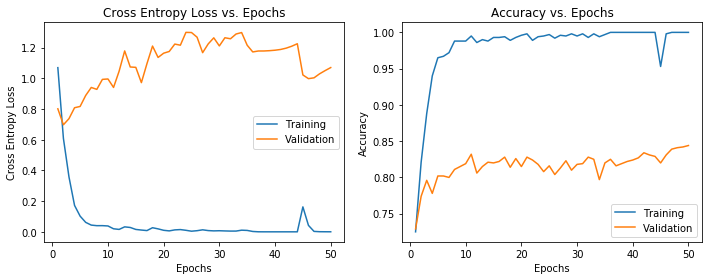

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.726, 0.728, 1.0625065703407612, 0.7994451324144999]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.821, 0.771, 0.6109172609506869, 0.7202470302581787]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.859, 0.779, 0.3609350078635746, 0.7944295942783356]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.916, 0.791, 0.17618070198770833, 0.8633541345596314]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.967, 0.804, 0.10908179279976811, 0.84114395181338]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.981, 0.812, 0.05476036708120232, 0.9085539221763611]
Starting epoch 7 / 50
progress: [0.977, 0.784, 0.03915976128705284, 1.0986672540505726]
Starting epoch 8 / 50
progress: [0.97, 0.812, 0.047265005005779216, 1.008454477787018]
Starting epoch 9 / 50
better val accuracy: update model.
progress: [0.985, 0.82, 0.042722861

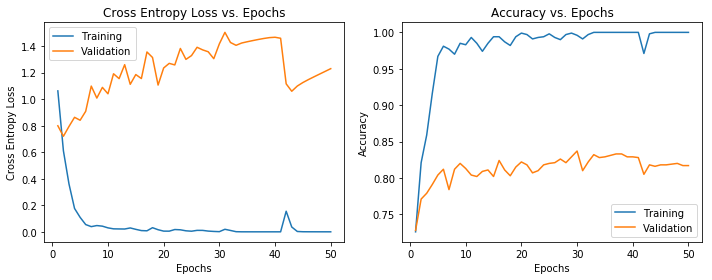

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.741, 0.744, 1.015938437686247, 0.772024405002594]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.831, 0.786, 0.5938952888538634, 0.6836585223674774]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.887, 0.792, 0.351228828728199, 0.7683466037114461]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.947, 0.802, 0.18001037060824873, 0.8040024797121684]
Starting epoch 5 / 50
progress: [0.959, 0.789, 0.09849360727163312, 0.9108620524406433]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.978, 0.811, 0.05479466056365982, 0.9320510943730672]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.975, 0.813, 0.037085492943042246, 0.9441789090633392]
Starting epoch 8 / 50
progress: [0.975, 0.811, 0.04068034625204365, 1.0323995431264241]
Starting epoch 9 / 50
progress: [0.981, 0.802, 0.04320091338907338, 1.0697856664657592]
Sta

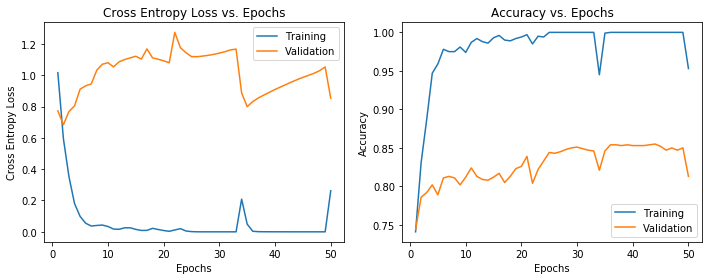

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.724, 0.732, 1.0729087811669493, 0.7869485894838969]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.813, 0.795, 0.6147259308232201, 0.6489953756332397]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.901, 0.814, 0.3650509327065711, 0.6595868368943533]
Starting epoch 4 / 50
progress: [0.932, 0.814, 0.18142117928543122, 0.7374816457430522]
Starting epoch 5 / 50
progress: [0.959, 0.795, 0.10007589760851236, 0.9282836894194285]
Starting epoch 6 / 50
progress: [0.969, 0.805, 0.06122030029621194, 0.9031575520833334]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.984, 0.817, 0.035612038403652076, 0.9617729981740316]
Starting epoch 8 / 50
progress: [0.983, 0.815, 0.03800009595157177, 1.0161888519922893]
Starting epoch 9 / 50
progress: [0.973, 0.801, 0.04438223821031891, 0.9596299648284912]
Starting epoch 10 / 50
progress: [0.981, 0.809, 0.029379301423852155, 

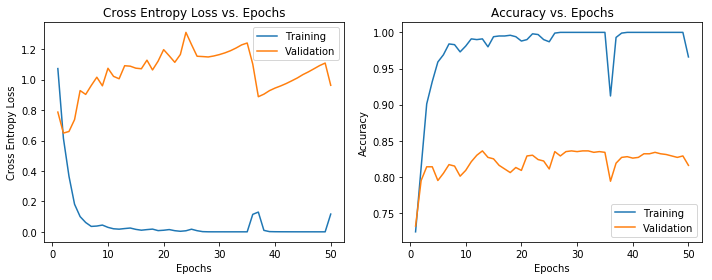

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.729, 0.736, 1.0568763714989806, 0.8022755980491638]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.814, 0.779, 0.5978019271411148, 0.7458116928736369]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.91, 0.797, 0.3449632886091089, 0.7391869227091471]
Starting epoch 4 / 50
progress: [0.942, 0.781, 0.16728640938652498, 0.8067392150561015]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.964, 0.801, 0.10068652721280172, 0.8511433442433675]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.967, 0.803, 0.06299740371166491, 1.0149404803911846]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.97, 0.813, 0.04047520014463492, 1.0099708358446757]
Starting epoch 8 / 50
progress: [0.967, 0.798, 0.04422012554463364, 1.1191537618637084]
Starting epoch 9 / 50
progress: [0.983, 0.8, 0.04468822927135073, 1.110482386747996]
Starti

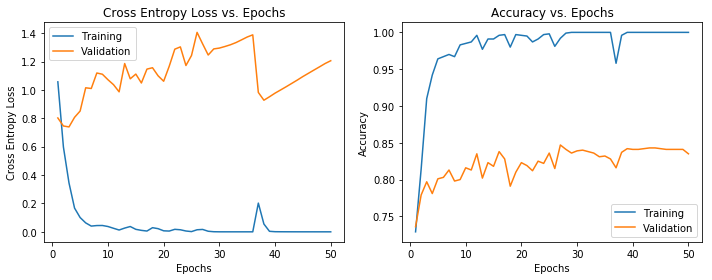

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.72, 0.749, 1.071828079106761, 0.7867927372455596]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.825, 0.787, 0.6115645949747048, 0.6774084349473317]
Starting epoch 3 / 50
progress: [0.891, 0.779, 0.3624546435825965, 0.7566165824731191]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.95, 0.794, 0.18117826465590328, 0.8132480005423228]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.96, 0.805, 0.09980859834384295, 0.8863014062245687]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.975, 0.819, 0.06143252007127587, 0.9162749548753103]
Starting epoch 7 / 50
progress: [0.975, 0.815, 0.03808815822224407, 0.9902807593345642]
Starting epoch 8 / 50
progress: [0.981, 0.806, 0.03259927226060064, 1.0065138419469197]
Starting epoch 9 / 50
progress: [0.977, 0.809, 0.04489897867220338, 1.0043446938196818]
Starting epoch 10 / 50
progress: [0.974,

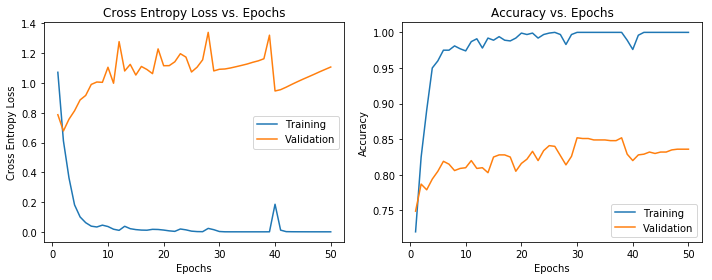

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.743, 0.745, 0.9994522025772169, 0.7527960081895192]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.833, 0.794, 0.5794825028749853, 0.6613903522491456]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.911, 0.815, 0.3407199662982249, 0.6763193209966024]
Starting epoch 4 / 50
progress: [0.934, 0.798, 0.1661791408008415, 0.8004220485687256]
Starting epoch 5 / 50
progress: [0.966, 0.811, 0.09512914369990623, 0.8254608829816182]
Starting epoch 6 / 50
progress: [0.981, 0.808, 0.056721146515071444, 0.8942012667655945]
Starting epoch 7 / 50
progress: [0.982, 0.808, 0.03507946485842219, 0.9205525279045105]
Starting epoch 8 / 50
progress: [0.965, 0.812, 0.034500388104736414, 0.9890232563018799]
Starting epoch 9 / 50
better val accuracy: update model.
progress: [0.979, 0.826, 0.04473528117124064, 0.8537818630536397]
Starting epoch 10 / 50
progress: [0.988, 0.804, 0.02843402445109354, 0

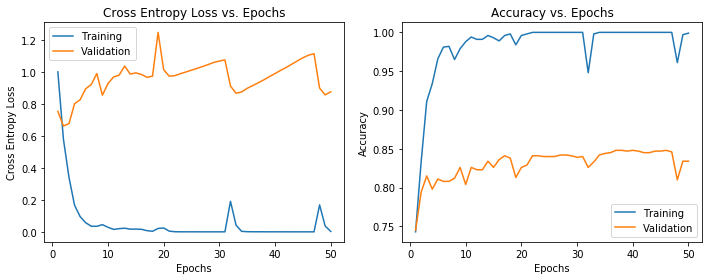

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.71, 0.719, 1.0618713912621043, 0.8318861842155456]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.837, 0.793, 0.5980544403487561, 0.6655617972215017]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.925, 0.797, 0.35183926723361797, 0.6701185524463653]
Starting epoch 4 / 50
progress: [0.939, 0.794, 0.17324127202330072, 0.794059677918752]
Starting epoch 5 / 50
progress: [0.945, 0.797, 0.09801630733132946, 0.8963051994641622]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.98, 0.815, 0.059740194575435, 0.8596843322118123]
Starting epoch 7 / 50
progress: [0.988, 0.81, 0.03284518531602777, 0.8757581253846486]
Starting epoch 8 / 50
progress: [0.98, 0.809, 0.028154167666227792, 0.985109011332194]
Starting epoch 9 / 50
better val accuracy: update model.
progress: [0.985, 0.816, 0.04640704662739938, 0.9022546629110972]
Starting epoch 10 / 50
better val accuracy

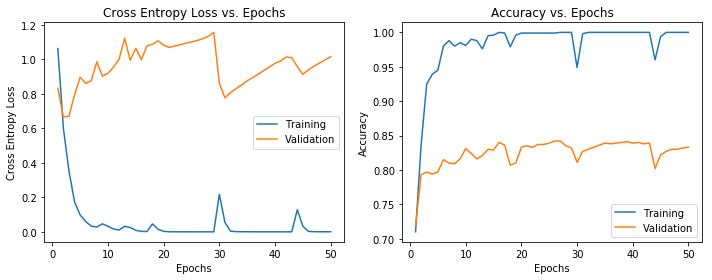

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.72, 0.72, 1.0154252179307874, 0.8106738646825155]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.829, 0.805, 0.5896784407251021, 0.682279646396637]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.898, 0.807, 0.3444552021819392, 0.6890072405338288]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.926, 0.808, 0.16833464197473588, 0.7765472193559011]
Starting epoch 5 / 50
progress: [0.965, 0.798, 0.08867570910773247, 0.8571730772654216]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.965, 0.823, 0.060041789965417994, 0.8591318925221761]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.975, 0.826, 0.04408298204805142, 0.8898792386054992]
Starting epoch 8 / 50
better val accuracy: update model.
progress: [0.978, 0.838, 0.03315637594977625, 0.8731781641642252]
Starting epoch 9 / 50
progress: [0.982, 0.817, 0.0317453

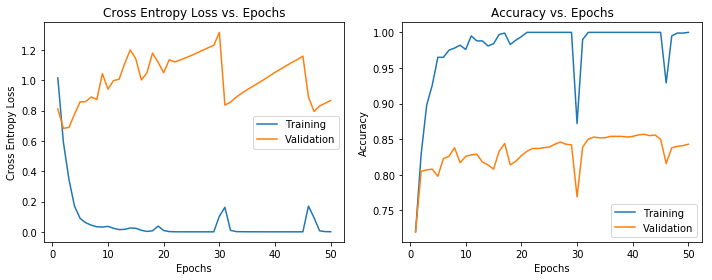

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.72, 0.739, 1.048741371335547, 0.7825744132200877]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.827, 0.801, 0.6072198710799996, 0.6561356683572134]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.888, 0.813, 0.35678743235036436, 0.6870798389116923]
Starting epoch 4 / 50
progress: [0.935, 0.799, 0.17713213711733522, 0.8348019182682037]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.949, 0.815, 0.10344629693484189, 0.8993562817573547]
Starting epoch 6 / 50
progress: [0.958, 0.806, 0.06258355967116122, 1.0007348736127217]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.976, 0.821, 0.03908250947647235, 0.9246397813161215]
Starting epoch 8 / 50
progress: [0.977, 0.816, 0.037634489702340825, 0.9648245255152385]
Starting epoch 9 / 50
progress: [0.975, 0.818, 0.04618435159349948, 0.9296777248382568]
Starting epoch 10 / 50
better val ac

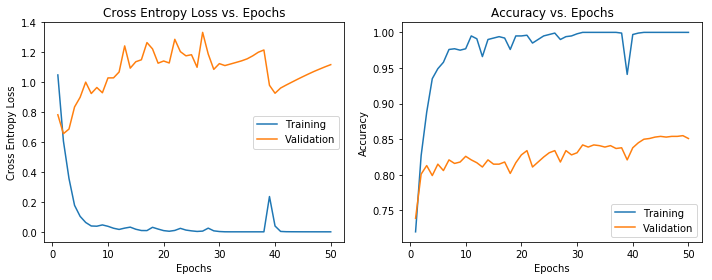

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.731, 0.732, 1.0420569087165632, 0.8121793826421102]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.827, 0.775, 0.5982506737210392, 0.6743573248386383]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.912, 0.812, 0.3541620851829161, 0.6667861978212992]
Starting epoch 4 / 50
progress: [0.929, 0.806, 0.17367392401484882, 0.815390529235204]
Starting epoch 5 / 50
progress: [0.97, 0.795, 0.09914438472025924, 0.8440236945947012]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.978, 0.818, 0.05776345089589264, 0.8334656476974487]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.979, 0.819, 0.0343924907224825, 0.9154164512952169]
Starting epoch 8 / 50
progress: [0.974, 0.814, 0.03484172812401275, 0.9296768089135488]
Starting epoch 9 / 50
progress: [0.988, 0.808, 0.0387523936856465, 1.025223481655121]
Starting epoch 10 / 50
progress: [0.979, 

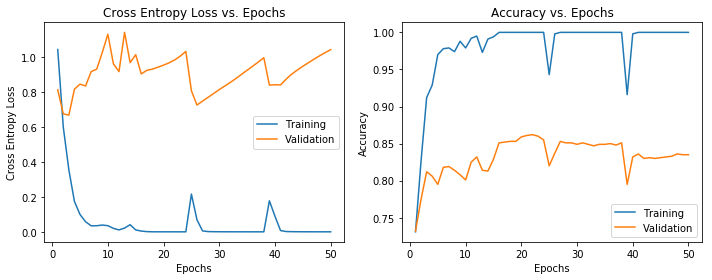

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.725, 0.734, 1.0124251565122917, 0.8041866421699524]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.839, 0.782, 0.5895277777918024, 0.6834570527076721]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.916, 0.806, 0.35227701863140065, 0.7326429009437561]
Starting epoch 4 / 50
progress: [0.93, 0.799, 0.17288653947461663, 0.842551193634669]
Starting epoch 5 / 50
progress: [0.953, 0.806, 0.09905143297624354, 0.8828057050704956]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.987, 0.829, 0.06249870153302266, 0.86110946337382]
Starting epoch 7 / 50
progress: [0.968, 0.819, 0.03604242127766114, 1.0494280775388083]
Starting epoch 8 / 50
progress: [0.982, 0.815, 0.0366477217300022, 1.0649107575416565]
Starting epoch 9 / 50
progress: [0.984, 0.815, 0.03968054955076499, 1.0964061975479127]
Starting epoch 10 / 50
progress: [0.976, 0.81, 0.03370992268733924, 1.09862

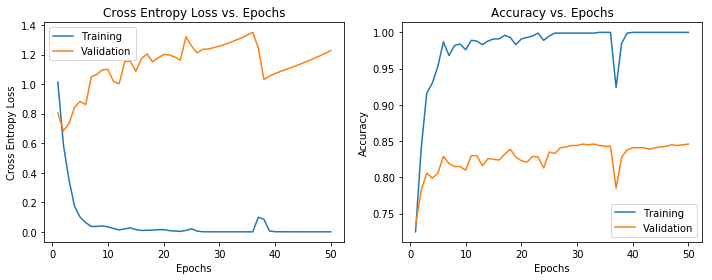

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.736, 0.738, 1.0475598201642629, 0.7788083950678507]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.826, 0.787, 0.601603050111166, 0.6783669153849284]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.87, 0.796, 0.35276978746348736, 0.7383386850357055]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.925, 0.803, 0.17019534478195353, 0.8292444666226705]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.953, 0.806, 0.100801307693416, 0.8305523316065471]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.978, 0.821, 0.05822564350940238, 0.8381402273972829]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.982, 0.822, 0.041065165863731524, 0.9216959198315938]
Starting epoch 8 / 50
progress: [0.969, 0.806, 0.03731255499353888, 1.0571974118550618]
Starting epoch 9 / 50
better val accuracy: update model.

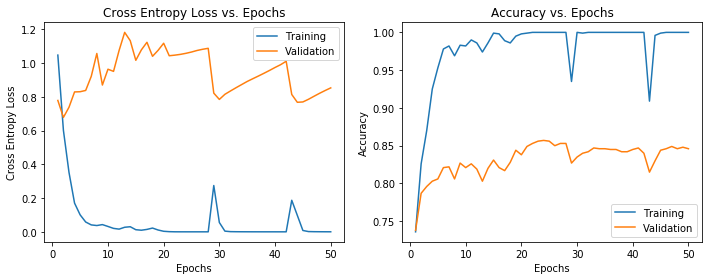

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.728, 0.739, 1.022316071371627, 0.7830156564712525]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.843, 0.798, 0.5913568334641799, 0.659379102786382]
Starting epoch 3 / 50
progress: [0.9, 0.796, 0.3481306432508955, 0.7504830519358318]
Starting epoch 4 / 50
progress: [0.95, 0.796, 0.16476477425472408, 0.8572263379891714]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.949, 0.799, 0.09570847487722348, 0.88426620165507]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.978, 0.817, 0.05543134267794979, 0.8696804861227672]
Starting epoch 7 / 50
progress: [0.978, 0.798, 0.03525950910913107, 0.9786750515302022]
Starting epoch 8 / 50
progress: [0.974, 0.8, 0.03663877249677099, 0.9920100708802541]
Starting epoch 9 / 50
progress: [0.979, 0.817, 0.037888518464903716, 1.0156970560550689]
Starting epoch 10 / 50
progress: [0.988, 0.811, 0.028285088896442486, 1.1028630

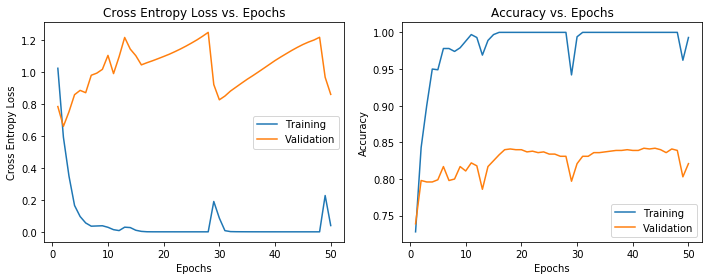

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.731, 0.731, 1.0139075348190232, 0.7684668103853861]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.842, 0.779, 0.5876143122031019, 0.6711075266202291]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.896, 0.797, 0.34367688669293533, 0.7135152161121369]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.944, 0.818, 0.16387193408959053, 0.7526305158933003]
Starting epoch 5 / 50
progress: [0.967, 0.816, 0.0970322382289405, 0.8077010869979858]
Starting epoch 6 / 50
progress: [0.979, 0.817, 0.05459580630843156, 0.925931437810262]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.983, 0.826, 0.03310000831443889, 0.896437398592631]
Starting epoch 8 / 50
progress: [0.979, 0.812, 0.03882315221540873, 1.028904096285502]
Starting epoch 9 / 50
progress: [0.983, 0.824, 0.04122393149486895, 0.9806313554445902]
Starting epoch 10 / 50
progress: [0.99,

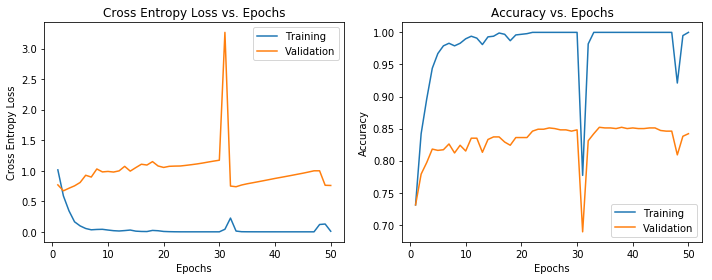

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.724, 0.71, 1.0244232074887145, 0.8461286862691243]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.83, 0.777, 0.5900084492427851, 0.6850888868172963]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.915, 0.801, 0.3453602206083684, 0.6682123303413391]
Starting epoch 4 / 50
progress: [0.921, 0.782, 0.1724025181062471, 0.8672694802284241]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.958, 0.814, 0.10447623092754214, 0.808759884039561]
Starting epoch 6 / 50
progress: [0.966, 0.812, 0.05983189878790499, 0.8676262100537618]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.98, 0.819, 0.038761139603855174, 0.9544377485911052]
Starting epoch 8 / 50
progress: [0.979, 0.815, 0.03898847900586678, 0.9683060884475708]
Starting epoch 9 / 50
progress: [0.978, 0.795, 0.03990409048152418, 1.1627394636472066]
Starting epoch 10 / 50
progress: [0.983,

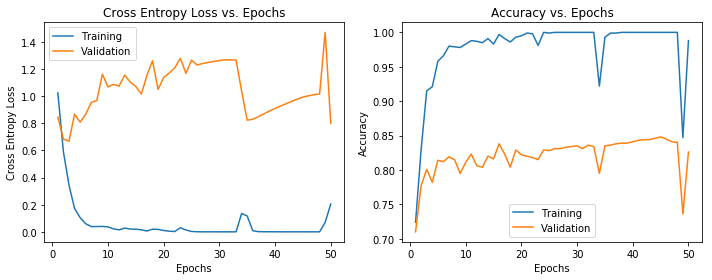

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.746, 0.73, 1.0436085433352227, 0.804749071598053]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.845, 0.786, 0.6028428910994063, 0.6849204560120901]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.908, 0.789, 0.35511346329855764, 0.7347443958123525]
Starting epoch 4 / 50
progress: [0.937, 0.788, 0.17016161079792416, 0.8462116837501525]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.948, 0.811, 0.0981565830851692, 0.8310974876085917]
Starting epoch 6 / 50
progress: [0.983, 0.807, 0.06078120763565785, 0.8555594344933828]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.979, 0.815, 0.038447319063680624, 0.9288821597894033]
Starting epoch 8 / 50
progress: [0.98, 0.815, 0.03660023025255285, 0.9948933998743693]
Starting epoch 9 / 50
progress: [0.971, 0.813, 0.04007265787127312, 1.097375710805257]
Starting epoch 10 / 50
better val accur

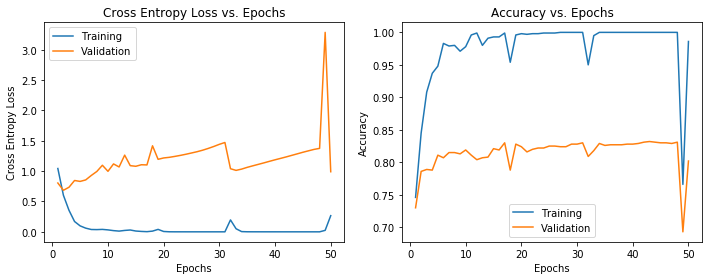

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.725, 0.729, 1.0165127837580015, 0.7768784920374553]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.828, 0.779, 0.5897930696898815, 0.6722744305928549]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.908, 0.8, 0.3501172216012587, 0.6920317749182383]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.95, 0.816, 0.1722179884614508, 0.7580772995948791]
Starting epoch 5 / 50
progress: [0.956, 0.81, 0.10044651923128982, 0.8621498227119446]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.973, 0.821, 0.05638353937226378, 0.8521691660086314]
Starting epoch 7 / 50
progress: [0.977, 0.812, 0.03449023756399459, 0.9906103889147441]
Starting epoch 8 / 50
progress: [0.982, 0.813, 0.03619989920224921, 0.9605854868888855]
Starting epoch 9 / 50
better val accuracy: update model.
progress: [0.982, 0.824, 0.041788222125786194, 0.9067960858345032]
Start

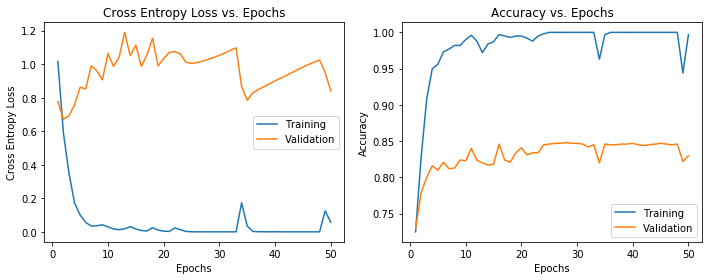

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.745, 0.742, 1.0056190161923177, 0.7657750904560089]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.847, 0.796, 0.5866394194512585, 0.6425848444302876]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.91, 0.805, 0.34369560233712976, 0.6951304455598195]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.955, 0.815, 0.16750645691565438, 0.7684555550416311]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.965, 0.826, 0.0913623210919254, 0.7900189816951751]
Starting epoch 6 / 50
progress: [0.983, 0.82, 0.049898476946149385, 0.8847365697224935]
Starting epoch 7 / 50
progress: [0.981, 0.818, 0.027586999781478463, 0.9648635903994243]
Starting epoch 8 / 50
progress: [0.964, 0.812, 0.03532637860199887, 0.9868933121363322]
Starting epoch 9 / 50
progress: [0.982, 0.815, 0.04143397395310351, 1.0024439692497253]
Starting epoch 10 / 50
progress: [0.

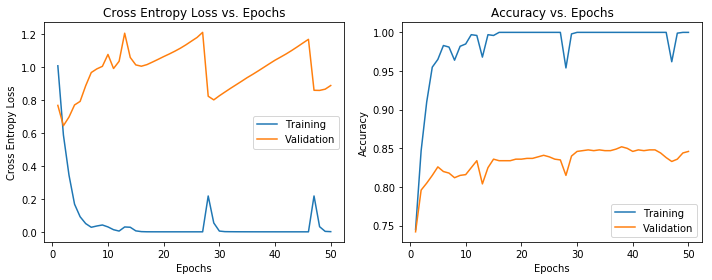

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.736, 0.743, 1.0036350576316608, 0.7586213787396748]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.844, 0.801, 0.5786310573418935, 0.6291623373826345]
Starting epoch 3 / 50
progress: [0.898, 0.799, 0.3369726474378623, 0.6812684456507365]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.943, 0.818, 0.16425199734132273, 0.7292618771394094]
Starting epoch 5 / 50
progress: [0.974, 0.805, 0.09390650739028952, 0.7755109071731567]
Starting epoch 6 / 50
progress: [0.977, 0.817, 0.05367109495172508, 0.9090550700823467]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.986, 0.822, 0.0345431517048745, 0.8763023654619853]
Starting epoch 8 / 50
better val accuracy: update model.
progress: [0.989, 0.825, 0.03284606143247847, 0.8673150142033895]
Starting epoch 9 / 50
progress: [0.984, 0.82, 0.03454185358242564, 0.9671972076098124]
Starting epoch 10 / 50
progress: [0.98

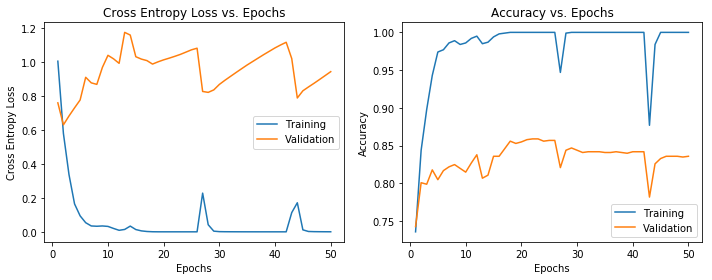

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.722, 0.716, 1.044344097687528, 0.837089995543162]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.834, 0.76, 0.6058847347116159, 0.7379209597905477]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.917, 0.8, 0.34986157378827043, 0.7015311419963837]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.938, 0.812, 0.16817945692858666, 0.7232875923315684]
Starting epoch 5 / 50
progress: [0.96, 0.804, 0.10172413513916576, 0.8462136109670003]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.976, 0.817, 0.06303059523986056, 0.8588631470998128]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.981, 0.821, 0.03911566419551283, 0.8845384895801545]
Starting epoch 8 / 50
progress: [0.976, 0.803, 0.03784264454958972, 1.130006162325541]
Starting epoch 9 / 50
progress: [0.986, 0.812, 0.0378393115086201, 1.1151922782262167]
Starting

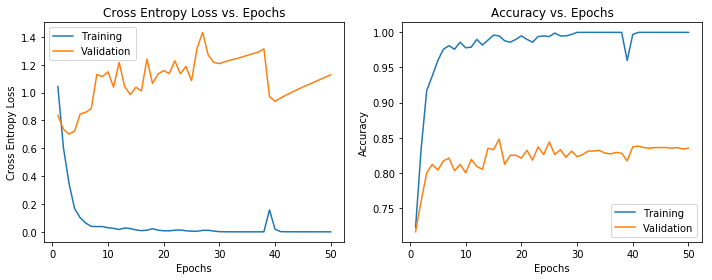

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.725, 0.745, 1.0579361487058252, 0.7816689213116964]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.816, 0.777, 0.6087988297144572, 0.7079856038093567]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.878, 0.795, 0.3596981277944995, 0.7637772858142853]
Starting epoch 4 / 50
progress: [0.949, 0.779, 0.17582391352435342, 0.8134451647599538]
Starting epoch 5 / 50
progress: [0.946, 0.787, 0.10305851437881881, 0.9532743235429127]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.97, 0.814, 0.06505296177236862, 0.8937065293391545]
Starting epoch 7 / 50
progress: [0.976, 0.814, 0.04280715906822116, 0.902371750275294]
Starting epoch 8 / 50
progress: [0.985, 0.809, 0.04159617287660736, 0.971576452255249]
Starting epoch 9 / 50
progress: [0.971, 0.812, 0.039336649910394664, 1.0016348759333293]
Starting epoch 10 / 50
progress: [0.989, 0.813, 0.034955952714008635, 1.0

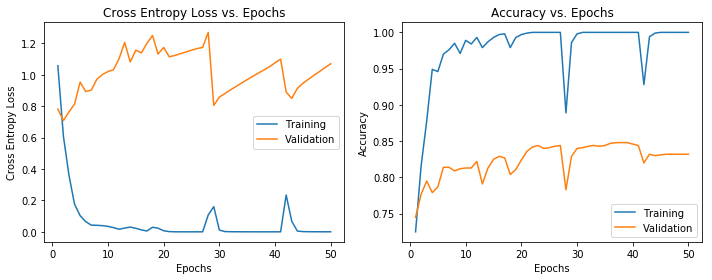

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.713, 0.716, 1.037955152871562, 0.8699164986610413]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.823, 0.781, 0.6033885918995914, 0.6852674742539724]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.902, 0.798, 0.3600973750641143, 0.7166213512420654]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.94, 0.807, 0.17360250931841875, 0.7806791623433431]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.957, 0.822, 0.10362051976418574, 0.849715119600296]
Starting epoch 6 / 50
progress: [0.976, 0.81, 0.06083344151965933, 0.9240884820620219]
Starting epoch 7 / 50
progress: [0.97, 0.808, 0.038531942151219044, 1.0172775864601136]
Starting epoch 8 / 50
progress: [0.98, 0.82, 0.039182389489210705, 0.9441076139609019]
Starting epoch 9 / 50
progress: [0.976, 0.811, 0.044021521456344845, 1.1322112321853637]
Starting epoch 10 / 50
progress: [0.988,

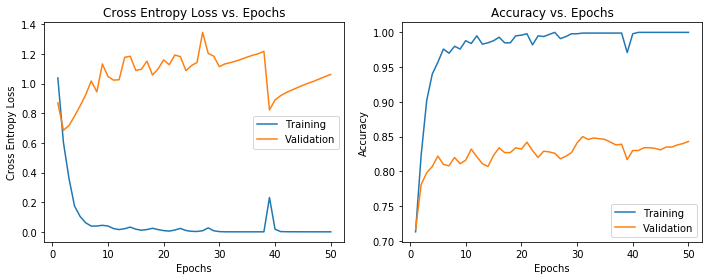

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.723, 0.726, 1.080895118853625, 0.8485708753267924]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.827, 0.798, 0.6129180017834396, 0.6631118019421895]
Starting epoch 3 / 50
progress: [0.882, 0.784, 0.3632351381180723, 0.73720250527064]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.95, 0.808, 0.17836983130356066, 0.8157523989677429]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.956, 0.82, 0.10250845198196913, 0.8247987647851308]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.967, 0.824, 0.06546804603262275, 0.8588143666585286]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.984, 0.829, 0.046808739721142, 0.8657493154207866]
Starting epoch 8 / 50
progress: [0.976, 0.827, 0.03763243903351181, 0.9422459761301677]
Starting epoch 9 / 50
progress: [0.955, 0.809, 0.0385361010537428, 1.0615722676118216]
Starting 

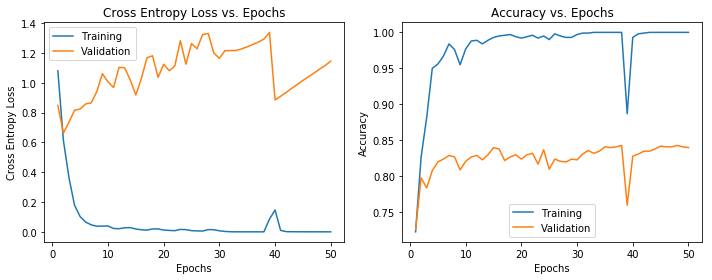

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.731, 0.742, 1.0184715808217042, 0.7989450335502625]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.832, 0.795, 0.5806886837762945, 0.6565684378147125]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.909, 0.813, 0.3390950705685647, 0.6121624112129211]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.95, 0.819, 0.16385253220553103, 0.6557953933874766]
Starting epoch 5 / 50
progress: [0.969, 0.818, 0.08360532464496061, 0.7164810081322988]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.976, 0.83, 0.057149035399597065, 0.7859556496143341]
Starting epoch 7 / 50
progress: [0.988, 0.826, 0.03307084816453212, 0.8283377707004547]
Starting epoch 8 / 50
progress: [0.981, 0.819, 0.03218560694515997, 0.9568167726198832]
Starting epoch 9 / 50
progress: [0.97, 0.822, 0.03818258886755097, 0.9586320916811625]
Starting epoch 10 / 50
progress: [0.97

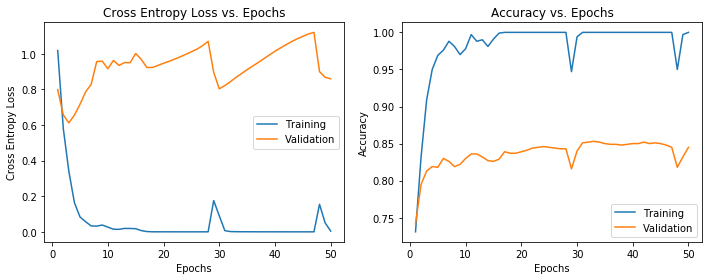

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.733, 0.728, 1.020247379081701, 0.7977114001909892]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.822, 0.78, 0.602866598281985, 0.6801114976406097]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.902, 0.795, 0.3556354998470911, 0.6558341324329376]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.93, 0.814, 0.17339100160702967, 0.7567804018656413]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.957, 0.827, 0.09459938573973631, 0.7441749274730682]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.978, 0.833, 0.05424966979284886, 0.7720804582039515]
Starting epoch 7 / 50
progress: [0.975, 0.824, 0.04003966531953683, 0.9052022834618886]
Starting epoch 8 / 50
progress: [0.977, 0.815, 0.029627190264294934, 0.932677427927653]
Starting epoch 9 / 50
progress: [0.98, 0.821, 0.03465406381786844, 0.9670345743497213]
Starti

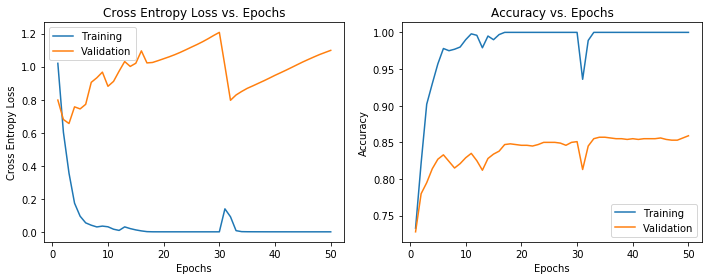

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.745, 0.755, 0.9811739643025242, 0.74897700548172]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.842, 0.8, 0.5683124106304318, 0.6256683150927226]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.909, 0.815, 0.33078190137455665, 0.6572189092636108]
Starting epoch 4 / 50
progress: [0.932, 0.808, 0.16219829797890842, 0.7818547526995341]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.963, 0.819, 0.09190827960428459, 0.8145293911298116]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.985, 0.83, 0.05368701251698475, 0.8081488609313965]
Starting epoch 7 / 50
progress: [0.976, 0.826, 0.03527107469956665, 0.8955389698346455]
Starting epoch 8 / 50
progress: [0.987, 0.826, 0.031769018548425114, 0.9068502426147461]
Starting epoch 9 / 50
better val accuracy: update model.
progress: [0.986, 0.833, 0.032337619614440434, 0.940596604347229]
Star

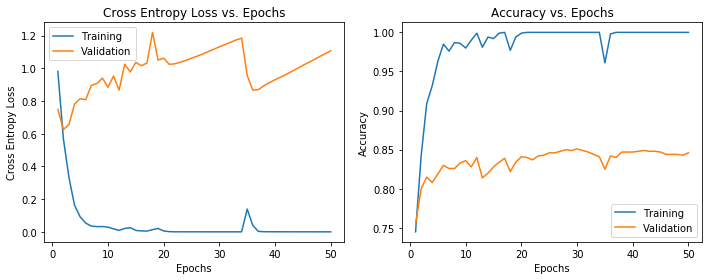

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.754, 0.739, 0.9989517316709157, 0.7601309855779012]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.838, 0.786, 0.5789884705753887, 0.6446759144465128]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.902, 0.787, 0.3392208038591871, 0.6746328274408976]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.935, 0.822, 0.1652709350233374, 0.729782885313034]
Starting epoch 5 / 50
progress: [0.967, 0.815, 0.0939775223253307, 0.7256985147794087]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.989, 0.823, 0.05198071827393731, 0.7784826238950093]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.986, 0.824, 0.03259542865520404, 0.8484542886416118]
Starting epoch 8 / 50
progress: [0.97, 0.823, 0.035714030111805094, 0.8989328503608703]
Starting epoch 9 / 50
better val accuracy: update model.
progress: [0.976, 0.84, 0.038068073

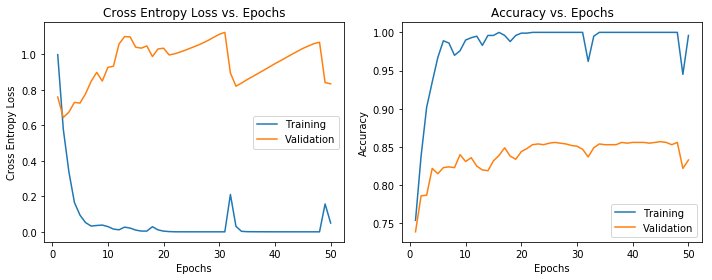

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.735, 0.752, 1.0115997557157006, 0.7677631696065267]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.835, 0.804, 0.5858151176201751, 0.6434539139270783]
Starting epoch 3 / 50
progress: [0.9, 0.8, 0.3471126869126083, 0.6917144219080608]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.934, 0.815, 0.16940220300522116, 0.7479767620563507]
Starting epoch 5 / 50
progress: [0.957, 0.813, 0.09066565042617274, 0.7845062712828318]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.972, 0.826, 0.05745031461850101, 0.8498525063196818]
Starting epoch 7 / 50
progress: [0.981, 0.803, 0.0411439260553106, 0.8242027918497722]
Starting epoch 8 / 50
progress: [0.981, 0.81, 0.03809008566857455, 1.0055250962575277]
Starting epoch 9 / 50
progress: [0.974, 0.825, 0.03390723169336911, 0.9018416961034139]
Starting epoch 10 / 50
progress: [0.985, 0.812, 0.030607131548116312, 0.96302

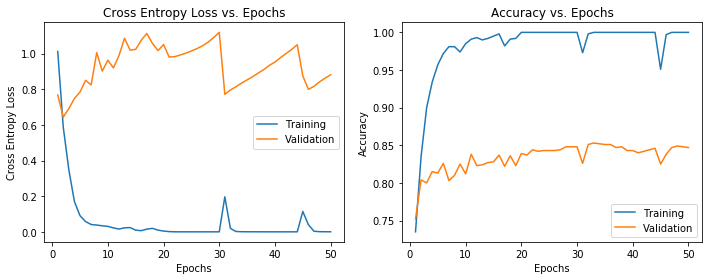

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.72, 0.74, 1.0266332833205953, 0.7975217779477437]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.821, 0.768, 0.5942445554764442, 0.7221120039621989]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.902, 0.787, 0.35007494390010835, 0.7463465491930644]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.947, 0.808, 0.1611982305942018, 0.8236605544885]
Starting epoch 5 / 50
progress: [0.954, 0.798, 0.09732624432376397, 1.0394260168075562]
Starting epoch 6 / 50
progress: [0.982, 0.805, 0.060599585870901744, 0.8968809465567271]
Starting epoch 7 / 50
progress: [0.981, 0.799, 0.0329367728289095, 1.068664308389028]
Starting epoch 8 / 50
progress: [0.985, 0.799, 0.035043266239070815, 1.1689787725607554]
Starting epoch 9 / 50
better val accuracy: update model.
progress: [0.986, 0.81, 0.03558381877328251, 1.0251281102498373]
Starting epoch 10 / 50
better val accuracy

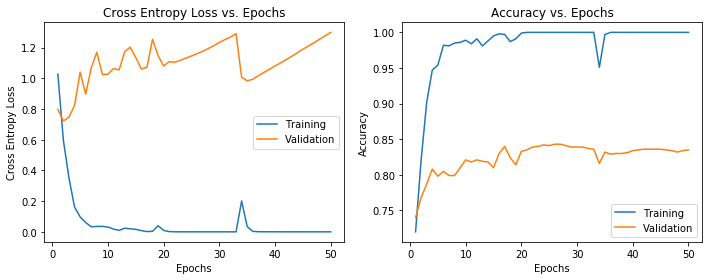

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.708, 0.709, 1.027031514068055, 0.8377372701962789]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.831, 0.764, 0.5920998719977397, 0.7239684363206228]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.892, 0.797, 0.3501037096762969, 0.7196752448876699]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.961, 0.802, 0.16566585848728815, 0.7821201244990031]
Starting epoch 5 / 50
progress: [0.962, 0.797, 0.09426655245007448, 0.9689875324567159]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.979, 0.806, 0.0573531039448735, 0.9492136359214782]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.974, 0.811, 0.033715457166088564, 0.9540411233901978]
Starting epoch 8 / 50
progress: [0.983, 0.808, 0.03663320124478025, 0.9116067846616109]
Starting epoch 9 / 50
progress: [0.98, 0.809, 0.03213337079463587, 1.074542800585429]
Star

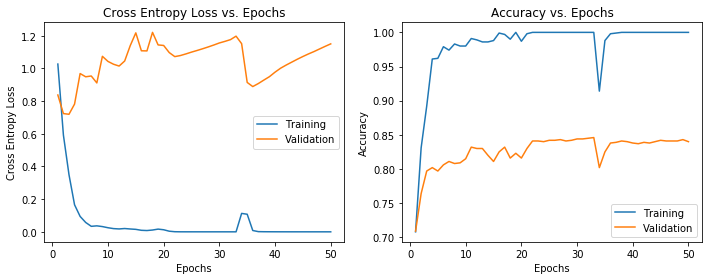

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.743, 0.741, 1.0627064247926077, 0.7779384215672811]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.836, 0.78, 0.604925926448473, 0.6717322409152985]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.908, 0.784, 0.3524751539713417, 0.7440015236536662]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.951, 0.795, 0.169852246495049, 0.7858487109343211]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.967, 0.8, 0.09476815707299834, 0.8346589883168538]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.972, 0.805, 0.059281933737395244, 0.9161654869715373]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.986, 0.815, 0.03812165431726992, 0.8865842739741008]
Starting epoch 8 / 50
progress: [0.96, 0.802, 0.03838092142417784, 1.0594399094581604]
Starting epoch 9 / 50
progress: [0.97, 0.814, 0.031837179881

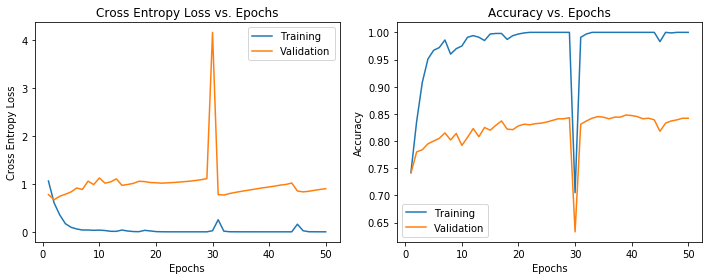

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.728, 0.739, 1.0250354685424978, 0.7406381269296011]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.83, 0.802, 0.5934335502923703, 0.6128573417663574]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.898, 0.809, 0.3498405164022461, 0.6752328793207805]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.935, 0.815, 0.16803130750465237, 0.7529627581437429]
Starting epoch 5 / 50
progress: [0.956, 0.809, 0.09103429495460458, 0.7969478448232015]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.977, 0.82, 0.055521865302295074, 0.7960792462031047]
Starting epoch 7 / 50
progress: [0.981, 0.814, 0.03465890946670198, 0.9032256325085958]
Starting epoch 8 / 50
better val accuracy: update model.
progress: [0.988, 0.821, 0.0286014386093597, 0.9998217980066936]
Starting epoch 9 / 50
progress: [0.975, 0.815, 0.0406848897725295, 0.9288089235623678]
Star

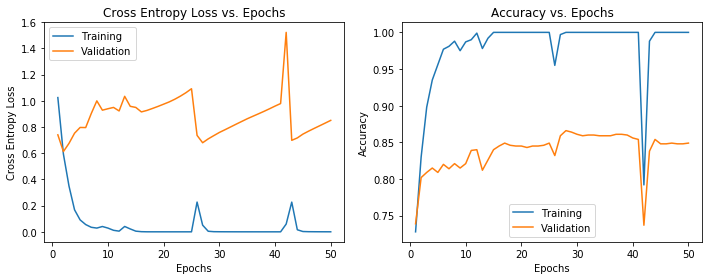

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.725, 0.724, 1.000765267696256, 0.7959542791048686]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.838, 0.78, 0.5907090943428426, 0.6651574651400248]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.907, 0.82, 0.354954998458133, 0.6348453323046367]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.941, 0.823, 0.17568354903190744, 0.673010669151942]
Starting epoch 5 / 50
progress: [0.946, 0.823, 0.1010207126075341, 0.7649287720521291]
Starting epoch 6 / 50
progress: [0.972, 0.821, 0.061856306612102036, 0.7824943741162618]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.982, 0.827, 0.03818119152637771, 0.8732587814331054]
Starting epoch 8 / 50
progress: [0.983, 0.816, 0.034235974283146314, 1.0450260082880656]
Starting epoch 9 / 50
better val accuracy: update model.
progress: [0.979, 0.829, 0.044231009117504154, 0.8809385001659393]
Star

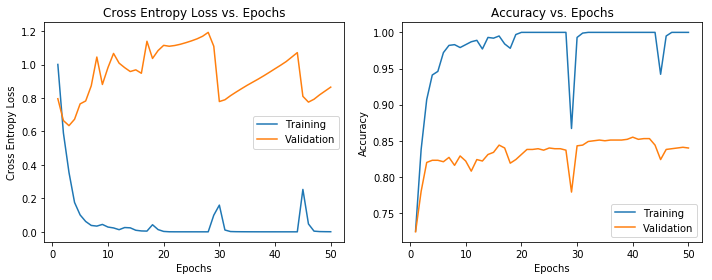

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.737, 0.717, 1.0515174361225825, 0.7854564746220907]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.824, 0.783, 0.5975958611840516, 0.664878123998642]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.916, 0.791, 0.3514804405616779, 0.7080159445603689]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.924, 0.801, 0.17286592373271395, 0.8069711784521739]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.96, 0.808, 0.09725224503553381, 0.8113985776901245]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.975, 0.81, 0.05957834531790485, 0.8180513719717661]
Starting epoch 7 / 50
progress: [0.976, 0.807, 0.034052032287676934, 0.8592672308286031]
Starting epoch 8 / 50
better val accuracy: update model.
progress: [0.975, 0.822, 0.03878503554421507, 0.8060869197050731]
Starting epoch 9 / 50
progress: [0.985, 0.821, 0.0373376

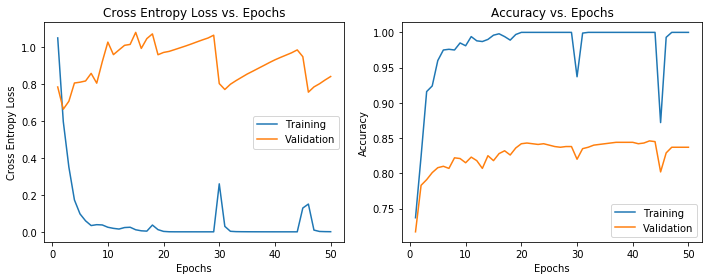

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.74, 0.741, 0.9947183118147008, 0.7588607390721639]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.841, 0.793, 0.573582036004347, 0.6483755350112915]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.901, 0.809, 0.33154753953023675, 0.6824168821175893]
Starting epoch 4 / 50
progress: [0.952, 0.806, 0.1640073011611022, 0.7709853768348693]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.952, 0.828, 0.08957178813277507, 0.8141021132469177]
Starting epoch 6 / 50
progress: [0.979, 0.82, 0.052795543896606546, 0.8781458993752798]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.988, 0.841, 0.03472291663398638, 0.9176881869633993]
Starting epoch 8 / 50
progress: [0.977, 0.822, 0.035283339502642945, 1.0285005291303]
Starting epoch 9 / 50
progress: [0.981, 0.82, 0.03698368901873823, 1.0354848146438598]
Starting epoch 10 / 50
progress: [0.987, 

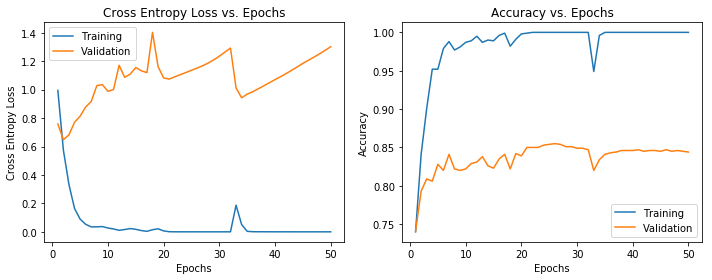

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.73, 0.749, 1.038463246666528, 0.7779804329077403]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.821, 0.785, 0.5984692052298901, 0.7050967574119568]
Starting epoch 3 / 50
progress: [0.884, 0.784, 0.3457437688910883, 0.7885447303454082]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.96, 0.815, 0.16580272324724135, 0.8073861757914226]
Starting epoch 5 / 50
progress: [0.952, 0.813, 0.0971337461953654, 0.8684951384862264]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.978, 0.822, 0.0579840200021863, 0.8998042543729147]
Starting epoch 7 / 50
progress: [0.984, 0.813, 0.040545435393460436, 0.9408297538757324]
Starting epoch 8 / 50
better val accuracy: update model.
progress: [0.987, 0.825, 0.03150229386595729, 0.9794023672739665]
Starting epoch 9 / 50
progress: [0.98, 0.818, 0.03613138533337346, 0.9425246775150299]
Starting epoch 10 / 50
better val accurac

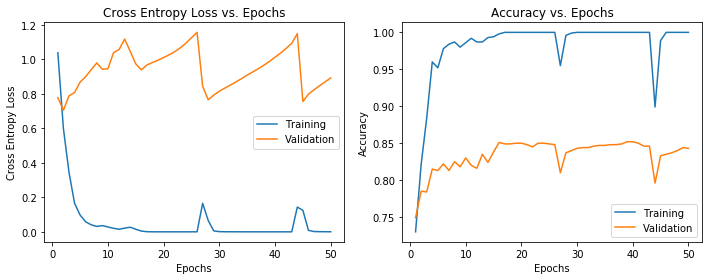

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.734, 0.746, 1.0037716083277284, 0.7337241252263387]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.835, 0.796, 0.5715946402035508, 0.6456791579723358]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.901, 0.816, 0.32796901052002037, 0.6386541247367858]
Starting epoch 4 / 50
progress: [0.939, 0.811, 0.1584957029999179, 0.741231906414032]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.985, 0.826, 0.08837500683038063, 0.7797558685143788]
Starting epoch 6 / 50
progress: [0.978, 0.822, 0.05416475366679282, 0.7801313916842143]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.973, 0.833, 0.03518823280297463, 0.8979918698469798]
Starting epoch 8 / 50
better val accuracy: update model.
progress: [0.984, 0.834, 0.03823217171993033, 0.8019409080346426]
Starting epoch 9 / 50
progress: [0.98, 0.823, 0.03533321543493205, 0.8768175125122071]
Sta

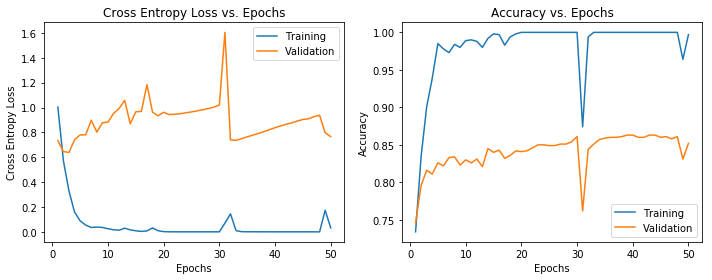

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.723, 0.717, 1.0526362735071992, 0.844863478342692]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.834, 0.792, 0.6063640118424409, 0.6633610804875691]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.895, 0.802, 0.35245673380840836, 0.733551029364268]
Starting epoch 4 / 50
progress: [0.927, 0.8, 0.17114629341301577, 0.8017186085383098]
Starting epoch 5 / 50
progress: [0.937, 0.792, 0.10517167956659607, 1.0416613201300302]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.979, 0.813, 0.06452594755302651, 0.88516486287117]
Starting epoch 7 / 50
progress: [0.97, 0.813, 0.035562364516621515, 1.0490983525911968]
Starting epoch 8 / 50
progress: [0.97, 0.81, 0.036606909433270204, 0.9545265396436056]
Starting epoch 9 / 50
progress: [0.984, 0.812, 0.040518422697494234, 1.105130656560262]
Starting epoch 10 / 50
progress: [0.98, 0.812, 0.02755205607349114, 1.1201722

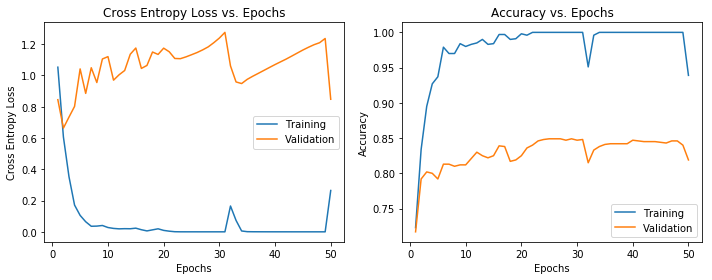

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.744, 0.758, 0.9708248971724043, 0.7232785582542419]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.84, 0.802, 0.5702391773657082, 0.6319842954476674]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.9, 0.806, 0.3362415790947434, 0.6479440073172251]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.929, 0.807, 0.16423552611148826, 0.7548804978529612]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.97, 0.819, 0.09061084534072018, 0.7557077884674073]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.985, 0.833, 0.05409307383195637, 0.8037407139937083]
Starting epoch 7 / 50
progress: [0.985, 0.831, 0.03501989266232532, 0.8630625089009603]
Starting epoch 8 / 50
better val accuracy: update model.
progress: [0.979, 0.834, 0.03416743932194472, 0.8323123534520467]
Starting epoch 9 / 50
progress: [0.989, 0.818, 0.030189049

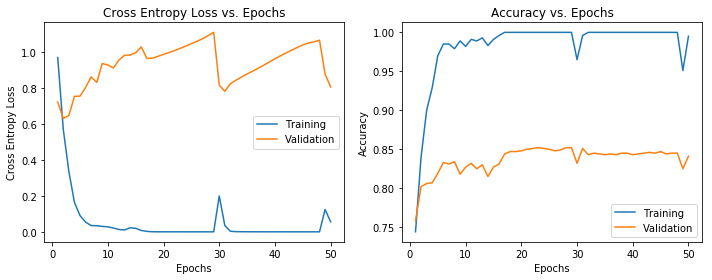

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.748, 0.752, 0.9682347509985656, 0.7318115810553233]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.839, 0.794, 0.559102017836633, 0.6481729785601298]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.91, 0.804, 0.32931247439746764, 0.6779401461283366]
Starting epoch 4 / 50
progress: [0.95, 0.796, 0.15660026277981554, 0.8350903391838074]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.971, 0.829, 0.0913319049123066, 0.7058541556199391]
Starting epoch 6 / 50
progress: [0.983, 0.825, 0.049430862721664456, 0.8323547065258026]
Starting epoch 7 / 50
progress: [0.98, 0.813, 0.030795888778041392, 0.946196448802948]
Starting epoch 8 / 50
progress: [0.974, 0.811, 0.034615872139902484, 0.9187134305636088]
Starting epoch 9 / 50
progress: [0.98, 0.819, 0.04206128890802658, 0.9016789635022481]
Starting epoch 10 / 50
better val accuracy: update model.
progress: [0.991

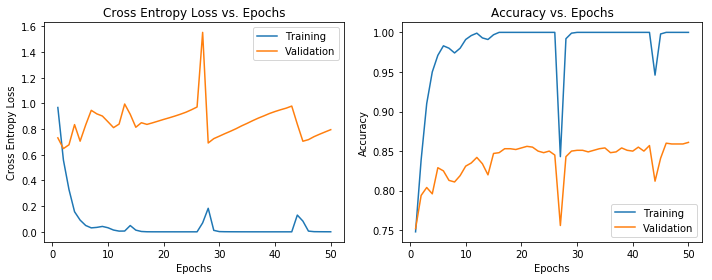

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.74, 0.742, 0.9957799172479342, 0.7738513867060344]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.846, 0.786, 0.5863987373565537, 0.6758858064810435]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.895, 0.797, 0.34143721492948875, 0.748677663008372]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.931, 0.809, 0.169667702888936, 0.7527542968591054]
Starting epoch 5 / 50
progress: [0.963, 0.803, 0.09606295348772037, 0.8072399377822876]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.981, 0.819, 0.05356371439262932, 0.8672669172286988]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.987, 0.83, 0.03544929925827127, 0.8862459023793539]
Starting epoch 8 / 50
progress: [0.978, 0.824, 0.03490922123230263, 0.9340802828470866]
Starting epoch 9 / 50
progress: [0.984, 0.826, 0.038482794115697244, 0.9295149445533752]
Star

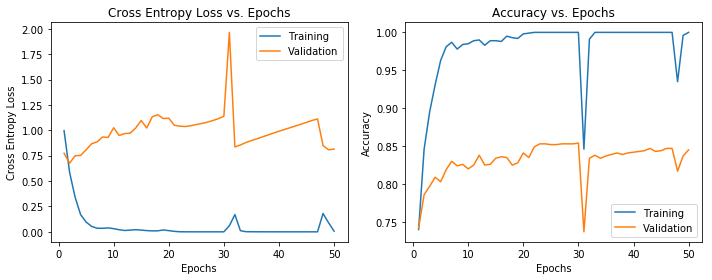

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.729, 0.733, 1.0185996392583536, 0.7797262668609619]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.843, 0.78, 0.5818266423699123, 0.6684970120588939]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.926, 0.814, 0.3364195985049983, 0.6801468153794606]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.936, 0.815, 0.16242485242147073, 0.8045329332351685]
Starting epoch 5 / 50
progress: [0.959, 0.811, 0.09745650511673268, 0.854703684647878]
Starting epoch 6 / 50
progress: [0.979, 0.814, 0.059238619765181556, 0.9028440674146017]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.98, 0.818, 0.03670910006157713, 0.9254377285639445]
Starting epoch 8 / 50
progress: [0.98, 0.816, 0.038557068699836924, 1.0114646196365356]
Starting epoch 9 / 50
progress: [0.983, 0.813, 0.03787192180996237, 0.9554663181304932]
Starting epoch 10 / 50
better val accu

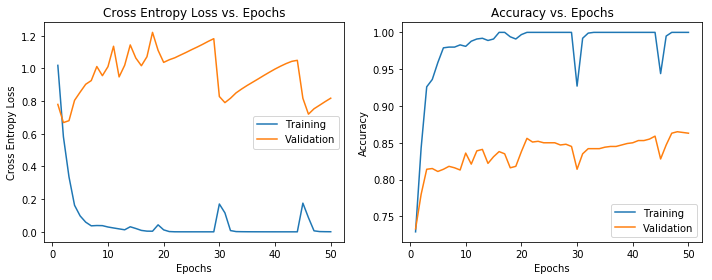

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.729, 0.755, 1.0241135672416561, 0.7465566754341125]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.838, 0.796, 0.5949185413667579, 0.6420005738735199]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.903, 0.803, 0.3563787601839483, 0.6786123971144359]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.938, 0.81, 0.1747608269936119, 0.774120052655538]
Starting epoch 5 / 50
progress: [0.947, 0.794, 0.09544392223743832, 0.8926423589388529]
Starting epoch 6 / 50
progress: [0.979, 0.805, 0.057554598547079984, 0.8731168746948242]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.987, 0.834, 0.0333683688217908, 0.8727574745814005]
Starting epoch 8 / 50
progress: [0.978, 0.809, 0.0344375848721445, 1.016743814945221]
Starting epoch 9 / 50
progress: [0.983, 0.813, 0.03911602383881223, 0.956218284368515]
Starting epoch 10 / 50
progress: [0.979, 0

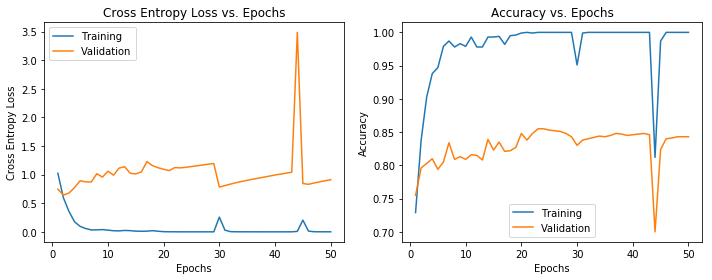

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.731, 0.756, 1.007500863425872, 0.7518166263898214]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.826, 0.789, 0.5733561293362013, 0.6729314863681793]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.906, 0.793, 0.32966992439203013, 0.7532094081242879]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.948, 0.8, 0.1598164713168456, 0.8268004735310872]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.962, 0.815, 0.09005733684094902, 0.837907467285792]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.983, 0.833, 0.05766890188618228, 0.8355280717213949]
Starting epoch 7 / 50
progress: [0.988, 0.823, 0.03319965173593826, 0.8864688316980998]
Starting epoch 8 / 50
progress: [0.985, 0.81, 0.033419608025890744, 0.8986674547195435]
Starting epoch 9 / 50
progress: [0.981, 0.816, 0.03695067933218834, 0.9002132058143616]
Start

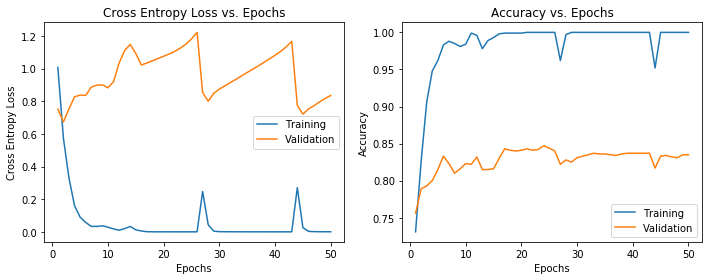

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.72, 0.735, 1.0475951500577865, 0.7827390789985657]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.836, 0.777, 0.6057972071022769, 0.6652586062749227]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.905, 0.786, 0.3559709364390062, 0.7176957666873932]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.923, 0.789, 0.1705141527444319, 0.830414726336797]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.961, 0.797, 0.10000073207797958, 0.8275937080383301]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.974, 0.816, 0.06039282296437259, 0.9482255379358927]
Starting epoch 7 / 50
progress: [0.97, 0.8, 0.036644410529460006, 1.0181373993555705]
Starting epoch 8 / 50
progress: [0.977, 0.798, 0.04068843575644922, 1.072275125980377]
Starting epoch 9 / 50
progress: [0.984, 0.811, 0.03468505266195565, 1.0958413283030193]
Startin

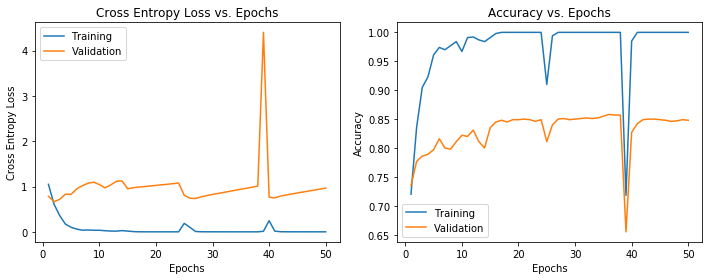

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.706, 0.745, 1.0304559982290455, 0.821267282962799]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.822, 0.788, 0.5959064073617162, 0.6817439575990041]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.902, 0.795, 0.3522944613706832, 0.7251695493857065]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.944, 0.804, 0.1733304884625611, 0.8264967620372772]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.963, 0.827, 0.10036430430957695, 0.762540090084076]
Starting epoch 6 / 50
progress: [0.986, 0.804, 0.0551789389764951, 0.8749780436356862]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.983, 0.828, 0.03791781779731703, 0.9175618608792623]
Starting epoch 8 / 50
progress: [0.988, 0.812, 0.029640878667580146, 0.9245032548904419]
Starting epoch 9 / 50
progress: [0.979, 0.817, 0.040145329146773795, 0.9763694882392884]
Sta

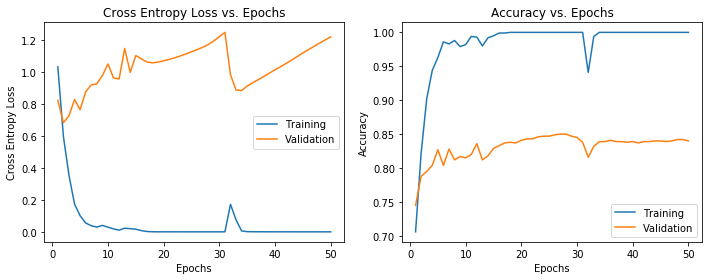

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.759, 0.758, 0.9717859248320262, 0.7205625077088674]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.836, 0.795, 0.5609875188154333, 0.6443406720956166]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.903, 0.796, 0.32768472838245966, 0.6492008884747823]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.94, 0.817, 0.15813774761372532, 0.6581421454747518]
Starting epoch 5 / 50
progress: [0.953, 0.817, 0.09123417091817637, 0.7955415487289429]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.971, 0.828, 0.053817292463545705, 0.8052244106928508]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.988, 0.83, 0.03621122616105804, 0.7727216760317485]
Starting epoch 8 / 50
progress: [0.984, 0.828, 0.030280097024028306, 0.9054151018460591]
Starting epoch 9 / 50
progress: [0.98, 0.824, 0.03641337994059998, 0.8715052604675293]
S

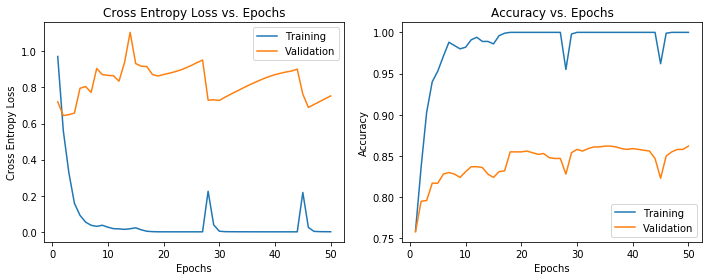

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.713, 0.718, 1.0286356654821658, 0.8086302598317464]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.836, 0.778, 0.5932994461527058, 0.6944125374158223]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.895, 0.801, 0.34099743527914184, 0.7393656571706136]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.922, 0.811, 0.16383997191206304, 0.7923157831033071]
Starting epoch 5 / 50
progress: [0.953, 0.803, 0.10202843607738127, 0.9613419453303019]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.983, 0.814, 0.05638947920642452, 0.9011022965113322]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.984, 0.819, 0.03133312621963472, 0.9115192214647929]
Starting epoch 8 / 50
progress: [0.979, 0.803, 0.04128868781164094, 1.0401334901650747]
Starting epoch 9 / 50
progress: [0.981, 0.808, 0.03695037617238567, 0.960114041964213]
S

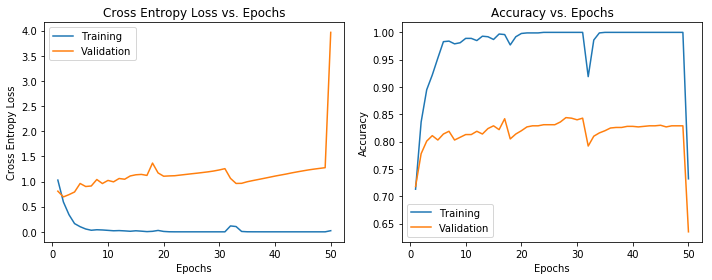

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.724, 0.731, 1.076802278577892, 0.8197041749954224]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.832, 0.763, 0.6118784555812287, 0.7312832633654277]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.89, 0.8, 0.36019129251537757, 0.756219599644343]
Starting epoch 4 / 50
progress: [0.919, 0.771, 0.1792744574447473, 0.8760464350382487]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.957, 0.804, 0.10197864637704067, 0.919019607702891]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.983, 0.82, 0.06209923068998881, 0.838179886341095]
Starting epoch 7 / 50
progress: [0.975, 0.796, 0.03773611098089639, 0.9533641040325165]
Starting epoch 8 / 50
progress: [0.98, 0.808, 0.04214561601303323, 1.0085695107777914]
Starting epoch 9 / 50
better val accuracy: update model.
progress: [0.98, 0.823, 0.044223924729291327, 0.9877318819363912]
Starting e

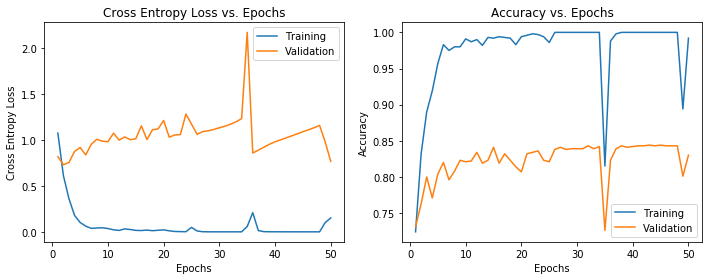

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.732, 0.729, 1.0570295032332926, 0.8078961292902629]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.827, 0.785, 0.598596356740964, 0.6891099989414216]
Starting epoch 3 / 50
progress: [0.906, 0.777, 0.34354454508793897, 0.7521242121855418]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.93, 0.802, 0.16454175291156847, 0.771817688147227]
Starting epoch 5 / 50
progress: [0.961, 0.775, 0.09141468552300354, 0.9069740732510885]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.974, 0.81, 0.05890919398090321, 0.8793536921342214]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.976, 0.813, 0.03685077765676516, 0.9694681962331136]
Starting epoch 8 / 50
progress: [0.984, 0.804, 0.0341922637172579, 1.015500279267629]
Starting epoch 9 / 50
better val accuracy: update model.
progress: [0.979, 0.823, 0.03735886436150549, 1.0289596279462179]
Starti

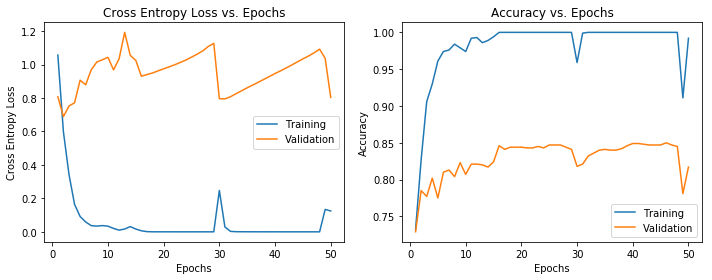

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.724, 0.734, 1.0369143459142423, 0.7976277311642964]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.834, 0.776, 0.6012625968339397, 0.6872850835323334]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.917, 0.783, 0.34401058119301703, 0.7362172424793243]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.949, 0.795, 0.16814115766216728, 0.8121698339780171]
Starting epoch 5 / 50
better val accuracy: update model.
progress: [0.971, 0.809, 0.09519623765368866, 0.9035700559616089]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.977, 0.811, 0.0513572190407347, 0.8830889523029327]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.984, 0.812, 0.03582956917778729, 0.9823273460070292]
Starting epoch 8 / 50
better val accuracy: update model.
progress: [0.977, 0.82, 0.035059483640894194, 0.9950888593991597]
Starting epoch 9 / 

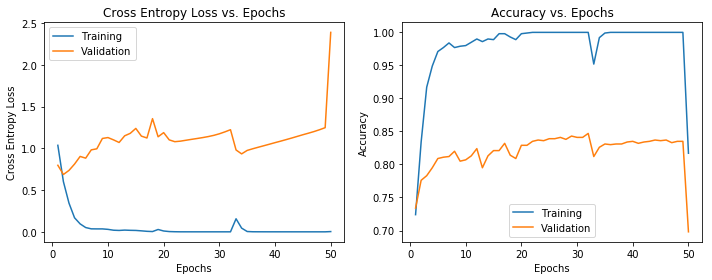

Starting epoch 1 / 50
better val accuracy: update model.
progress: [0.721, 0.707, 1.045065353041381, 0.836986490090688]
Starting epoch 2 / 50
better val accuracy: update model.
progress: [0.832, 0.791, 0.6070624708350187, 0.6472373167673747]
Starting epoch 3 / 50
better val accuracy: update model.
progress: [0.871, 0.801, 0.35543074891263365, 0.704173215230306]
Starting epoch 4 / 50
better val accuracy: update model.
progress: [0.916, 0.812, 0.17087654319950957, 0.7295122424761454]
Starting epoch 5 / 50
progress: [0.959, 0.8, 0.10028852277916242, 0.8134896139303843]
Starting epoch 6 / 50
better val accuracy: update model.
progress: [0.963, 0.815, 0.05305169174581571, 0.8823446393013]
Starting epoch 7 / 50
better val accuracy: update model.
progress: [0.969, 0.819, 0.04432205513935366, 0.9430970509847005]
Starting epoch 8 / 50
progress: [0.976, 0.814, 0.036637899991782276, 0.9189911206563314]
Starting epoch 9 / 50
better val accuracy: update model.
progress: [0.983, 0.827, 0.03153329942

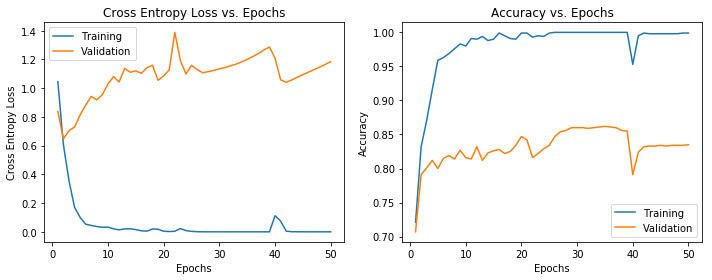

In [131]:
epochs = 50

max_count = 100  # Run random 
for count in range(max_count):
    
    reg = random.uniform(5e-8,1e-6)
    lr = random.uniform(1e-3,3e-3)
    
    best_val_acc=0.0
    model = generator().type(gpu_dtype)

    loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
    
# lr=0.0012 gives consistent 83+% test accuracy
# optimizer = optim.Adam(model.parameters(), lr=0.0012, weight_decay=reg)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

    start = time.time()

    file_name = 'm2-50ep-results/model2'+'_reg='+str('{:.4e}'.format(reg))+'lr='+str('{:.4e}'.format(lr)) \
            +'ep='+str(epochs)+'bestacc.pt'
    best_val_acc, results = train_detailed(model, loss_fn, optimizer, file_name, 
                                                    num_epochs=epochs, verbose=False)

    end = time.time()

    print('lr = {}, reg = {}.'.format(lr, reg))    
    print('Best validation accuracy is {0}. Training time for {1} epochs: {2:.2f} sec'.format(best_val_acc, 
                                                                                              epochs, end-start))
    # Plot out the accuracies and losses
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(list(range(1,len(np.array(results)[:,2])+1)), np.array(results)[:,2], label='Training')
    plt.plot(list(range(1,len(np.array(results)[:,3])+1)), np.array(results)[:,3], label='Validation')
    plt.title('Cross Entropy Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Cross Entropy Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(list(range(1,len(np.array(results)[:,0])+1)), np.array(results)[:,0], label='Training')
    plt.plot(list(range(1,len(np.array(results)[:,1])+1)), np.array(results)[:,1], label='Validation')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()

    #plt.savefig('sgd_model_plot_batch_norm_hidden_256x256.png')
    plt.show()

## Switch to Per Epoch LR Annealing

We may get better results.

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.721, 0.734, 0.016620601720347697, 0.011655039846897126]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.835, 0.771, 0.009420007047604541, 0.010414407432079316]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.886, 0.789, 0.0052293376884594255, 0.011459604382514954]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.946, 0.816, 0.0023817460384904124, 0.011404282152652741]
Starting epoch 5 / 30
progress: [0.98, 0.805, 0.0011834648706741174, 0.012246056854724885]
Starting epoch 6 / 30
progress: [0.97, 0.796, 0.0006791317120042383, 0.015157760381698608]
Starting epoch 7 / 30
better val accuracy: update model.
progress: [0.987, 0.826, 0.0005314491207578353, 0.013932252407073974]
Starting epoch 8 / 30
better val accuracy: update model.
progress: [0.994, 0.828, 0.0004097481647040695, 0.01439145365357399]
Starting epoch 9 / 30
progress: [0.989, 0.821, 0.0002640592

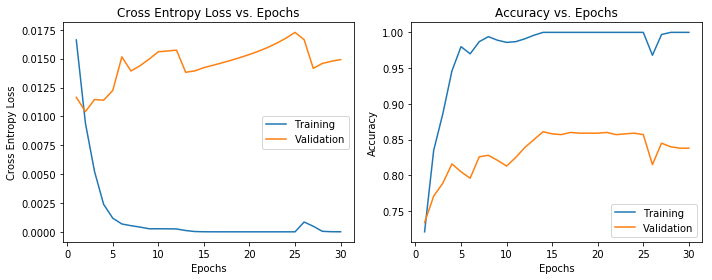

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.734, 0.734, 0.01666329436581962, 0.011646896719932557]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.813, 0.773, 0.009385692455026568, 0.01004270139336586]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.9, 0.81, 0.005446590240056418, 0.009908000081777573]
Starting epoch 4 / 30
progress: [0.948, 0.797, 0.002529607561321891, 0.011760364890098572]
Starting epoch 5 / 30
better val accuracy: update model.
progress: [0.965, 0.816, 0.0011545518947651192, 0.011640616208314896]
Starting epoch 6 / 30
progress: [0.976, 0.793, 0.0007409551721826499, 0.01422066906094551]
Starting epoch 7 / 30
progress: [0.984, 0.81, 0.00046222502191798113, 0.014028242170810699]
Starting epoch 8 / 30
progress: [0.984, 0.813, 0.0003475372423655449, 0.015349871575832367]
Starting epoch 9 / 30
better val accuracy: update model.
progress: [0.988, 0.823, 0.00042700756374480466, 0.014980229258537292]
Starti

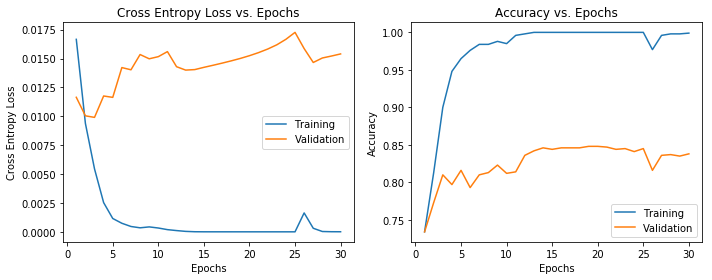

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.717, 0.719, 0.01590983825557086, 0.012629613399505616]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.833, 0.781, 0.009180634259569402, 0.010295607805252075]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.898, 0.799, 0.005443892587508474, 0.010356595367193222]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.929, 0.803, 0.0025851767574798087, 0.011575104802846908]
Starting epoch 5 / 30
better val accuracy: update model.
progress: [0.957, 0.805, 0.0013918419409049104, 0.012274010002613068]
Starting epoch 6 / 30
better val accuracy: update model.
progress: [0.966, 0.823, 0.000943501775076955, 0.012708710134029388]
Starting epoch 7 / 30
progress: [0.982, 0.812, 0.0006778198607379989, 0.012198605239391327]
Starting epoch 8 / 30
better val accuracy: update model.
progress: [0.991, 0.829, 0.00044516682928922224, 0.013047044396400451]
Starting epoch 9 / 30
p

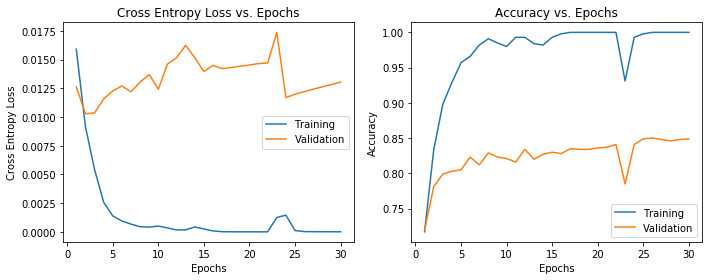

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.731, 0.747, 0.015997409731757884, 0.011412814676761628]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.85, 0.796, 0.009155350844166717, 0.009559002697467804]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.905, 0.813, 0.005311131308729552, 0.00966349795460701]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.958, 0.826, 0.002383217640905356, 0.010028510689735412]
Starting epoch 5 / 30
progress: [0.977, 0.822, 0.0010821829039261352, 0.012061077654361724]
Starting epoch 6 / 30
better val accuracy: update model.
progress: [0.98, 0.83, 0.000722868524263708, 0.012218076765537262]
Starting epoch 7 / 30
progress: [0.987, 0.826, 0.0005271462946845104, 0.012363201558589935]
Starting epoch 8 / 30
progress: [0.986, 0.826, 0.0003163306228198795, 0.01275691556930542]
Starting epoch 9 / 30
progress: [0.987, 0.825, 0.00029206373602655547, 0.0133940809071064]
Starting

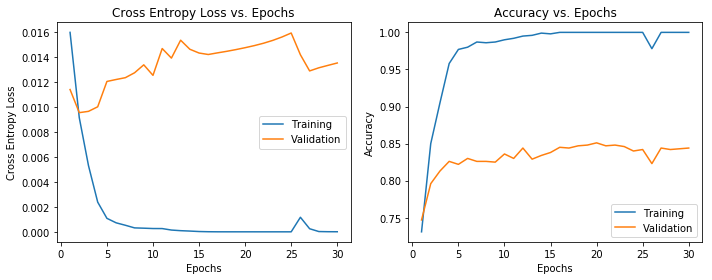

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.733, 0.739, 0.015741413379810294, 0.012267695188522339]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.84, 0.789, 0.008955697149646525, 0.010163392961025239]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.888, 0.802, 0.005140687986143998, 0.0108707917034626]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.952, 0.809, 0.0024245961524774224, 0.011420604705810546]
Starting epoch 5 / 30
progress: [0.968, 0.803, 0.0013018233834252674, 0.01234050315618515]
Starting epoch 6 / 30
better val accuracy: update model.
progress: [0.972, 0.817, 0.0008716777433090064, 0.012640258610248565]
Starting epoch 7 / 30
better val accuracy: update model.
progress: [0.985, 0.822, 0.000549008082541428, 0.012774925410747527]
Starting epoch 8 / 30
progress: [0.981, 0.818, 0.0004940564780572087, 0.013047298520803451]
Starting epoch 9 / 30
better val accuracy: update model.
progr

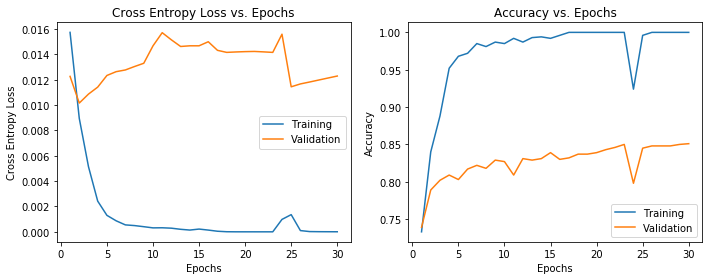

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.729, 0.751, 0.015590021752581304, 0.011453680753707885]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.839, 0.789, 0.00895548584053711, 0.01013385745882988]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.894, 0.79, 0.005171086487113213, 0.010461254090070725]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.956, 0.828, 0.002375294304661909, 0.010706067383289337]
Starting epoch 5 / 30
progress: [0.961, 0.806, 0.0011458650538602806, 0.013664206326007842]
Starting epoch 6 / 30
progress: [0.975, 0.802, 0.0007788600517360836, 0.013989838600158691]
Starting epoch 7 / 30
progress: [0.988, 0.818, 0.0004691544729379975, 0.014167239308357239]
Starting epoch 8 / 30
progress: [0.994, 0.821, 0.0004031204755788631, 0.014060232698917388]
Starting epoch 9 / 30
progress: [0.994, 0.818, 0.00035387510378673975, 0.013762678682804107]
Starting epoch 10 / 30
progress: [0.98

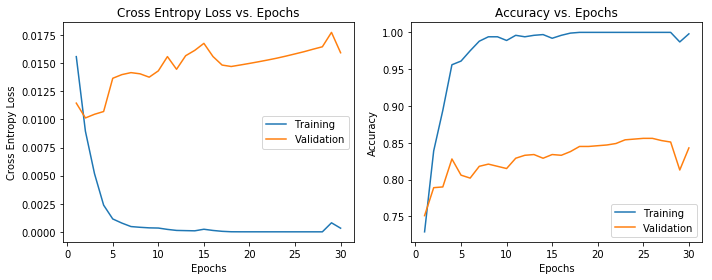

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.725, 0.737, 0.015671870375774343, 0.011721584141254425]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.835, 0.791, 0.009030552059412002, 0.00968138986825943]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.897, 0.817, 0.005149491855836645, 0.009527543097734452]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.953, 0.825, 0.002284172332712582, 0.010244398444890977]
Starting epoch 5 / 30
better val accuracy: update model.
progress: [0.974, 0.828, 0.0011047854064298527, 0.01131150797009468]
Starting epoch 6 / 30
better val accuracy: update model.
progress: [0.976, 0.829, 0.000629782260965784, 0.012051286548376084]
Starting epoch 7 / 30
progress: [0.98, 0.829, 0.00045650292370392353, 0.01349385181069374]
Starting epoch 8 / 30
progress: [0.985, 0.825, 0.0004208749580406109, 0.013656184673309327]
Starting epoch 9 / 30
progress: [0.989, 0.821, 0.0003443931111

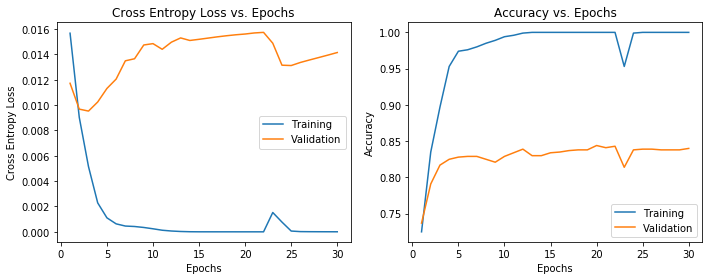

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.713, 0.724, 0.015580098687994237, 0.012507738769054413]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.832, 0.784, 0.00893802140227386, 0.010857333809137344]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.903, 0.799, 0.005092724627225983, 0.010988193839788437]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.942, 0.818, 0.0023193726054943947, 0.011150280565023422]
Starting epoch 5 / 30
progress: [0.967, 0.809, 0.0012115717443010332, 0.012877045035362243]
Starting epoch 6 / 30
progress: [0.987, 0.806, 0.0007868406621701255, 0.013653155028820039]
Starting epoch 7 / 30
progress: [0.984, 0.804, 0.0005241447185375252, 0.01399079418182373]
Starting epoch 8 / 30
progress: [0.987, 0.811, 0.00042556184436175594, 0.014436499118804931]
Starting epoch 9 / 30
better val accuracy: update model.
progress: [0.988, 0.832, 0.00034201257204047726, 0.01392403358221054]
S

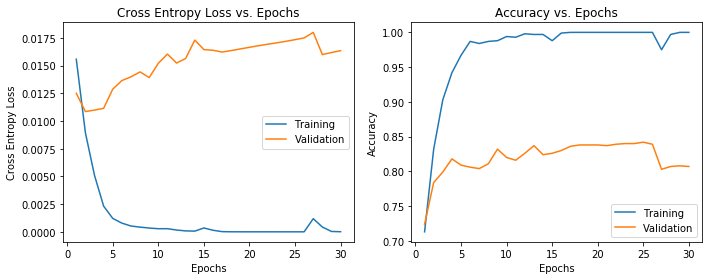

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.722, 0.758, 0.015326698173673785, 0.01123237657546997]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.83, 0.789, 0.008725391488902423, 0.009924210637807846]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.899, 0.804, 0.004986778484163235, 0.009804881811141967]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.947, 0.812, 0.0023427361539584035, 0.010505268692970277]
Starting epoch 5 / 30
better val accuracy: update model.
progress: [0.969, 0.825, 0.001289303980577661, 0.011289976567029953]
Starting epoch 6 / 30
progress: [0.982, 0.823, 0.0008264285231636343, 0.012049265503883362]
Starting epoch 7 / 30
progress: [0.979, 0.808, 0.0005375088591945871, 0.013779602020978927]
Starting epoch 8 / 30
progress: [0.99, 0.818, 0.00039916313322717133, 0.01430176156759262]
Starting epoch 9 / 30
progress: [0.986, 0.813, 0.0004916553504251856, 0.013903336465358735]
Star

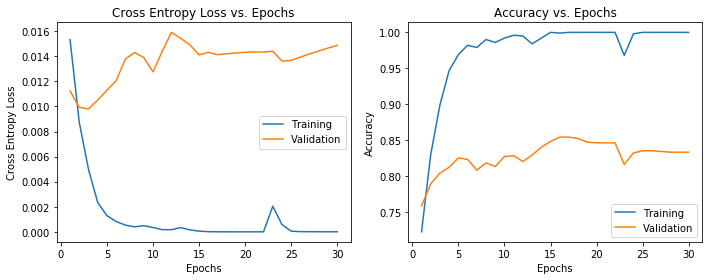

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.727, 0.732, 0.016335415113337186, 0.01192677390575409]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.821, 0.779, 0.009235333479788839, 0.010459820717573166]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.92, 0.78, 0.005253245023744447, 0.011135788172483445]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.943, 0.79, 0.0023898145889065096, 0.012172622859477997]
Starting epoch 5 / 30
better val accuracy: update model.
progress: [0.96, 0.812, 0.0013641507964847342, 0.01181702435016632]
Starting epoch 6 / 30
better val accuracy: update model.
progress: [0.975, 0.818, 0.0008034061123331895, 0.012236370861530304]
Starting epoch 7 / 30
better val accuracy: update model.
progress: [0.979, 0.819, 0.0005678638551878381, 0.013430702209472655]
Starting epoch 8 / 30
progress: [0.98, 0.81, 0.0004819200945713994, 0.014499347865581512]
Starting epoch 9 / 30
progress

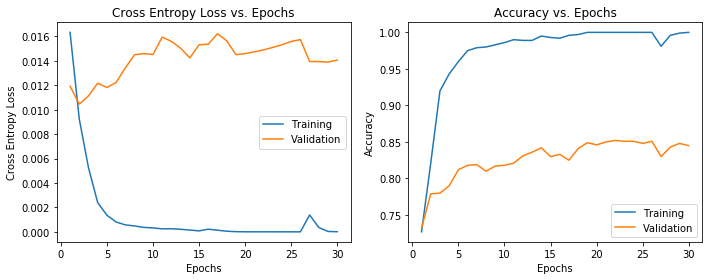

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.728, 0.737, 0.01613531250065687, 0.011713015258312226]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.83, 0.768, 0.009293200053122579, 0.010402329981327056]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.904, 0.789, 0.005392426074615547, 0.01107350116968155]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.93, 0.808, 0.0025025363176376845, 0.012129382908344269]
Starting epoch 5 / 30
better val accuracy: update model.
progress: [0.958, 0.81, 0.0013555940926949285, 0.012829100251197816]
Starting epoch 6 / 30
better val accuracy: update model.
progress: [0.983, 0.812, 0.0008549354897089759, 0.01394511017203331]
Starting epoch 7 / 30
progress: [0.984, 0.81, 0.0006055937024707697, 0.015390648782253265]
Starting epoch 8 / 30
better val accuracy: update model.
progress: [0.986, 0.823, 0.00048573278548309995, 0.014060281366109848]
Starting epoch 9 / 30
progre

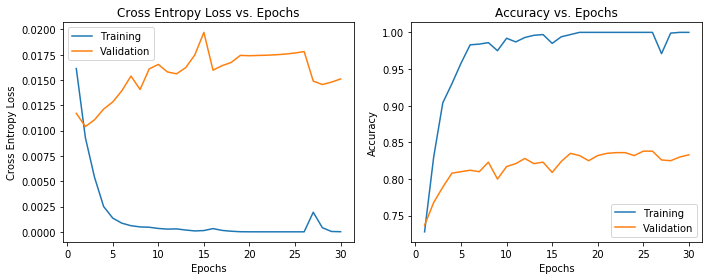

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.72, 0.711, 0.016022182948127083, 0.012412681639194489]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.819, 0.765, 0.00915392420425707, 0.010745950669050217]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.889, 0.785, 0.005179955038337075, 0.011011081546545029]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.942, 0.805, 0.0023191140086523125, 0.012541315972805023]
Starting epoch 5 / 30
better val accuracy: update model.
progress: [0.966, 0.827, 0.0012598772305539069, 0.012616047084331512]
Starting epoch 6 / 30
progress: [0.985, 0.806, 0.0007659882808446276, 0.014384276300668717]
Starting epoch 7 / 30
progress: [0.989, 0.814, 0.000501432044191609, 0.01479651317000389]
Starting epoch 8 / 30
progress: [0.983, 0.815, 0.00037079278293198774, 0.015240497708320618]
Starting epoch 9 / 30
progress: [0.99, 0.824, 0.00035749953871174736, 0.01617576986551285]
Star

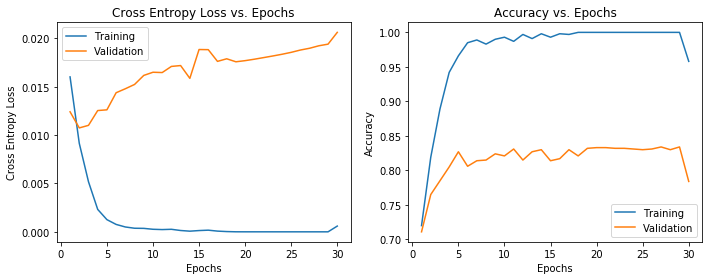

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.745, 0.757, 0.015633139321390464, 0.011139361917972565]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.846, 0.807, 0.00899259359009412, 0.008944225758314132]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.91, 0.813, 0.005190134941771322, 0.009481515914201736]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.954, 0.82, 0.0024356188248766926, 0.009972701191902161]
Starting epoch 5 / 30
better val accuracy: update model.
progress: [0.963, 0.831, 0.0011878593307444636, 0.010497935116291046]
Starting epoch 6 / 30
progress: [0.986, 0.813, 0.0006829073961862192, 0.0119757060110569]
Starting epoch 7 / 30
progress: [0.984, 0.827, 0.0004427491306726422, 0.012750775873661042]
Starting epoch 8 / 30
progress: [0.987, 0.82, 0.00037358223210678113, 0.013676804006099701]
Starting epoch 9 / 30
progress: [0.984, 0.823, 0.00031525378153488345, 0.014125021159648895]
Star

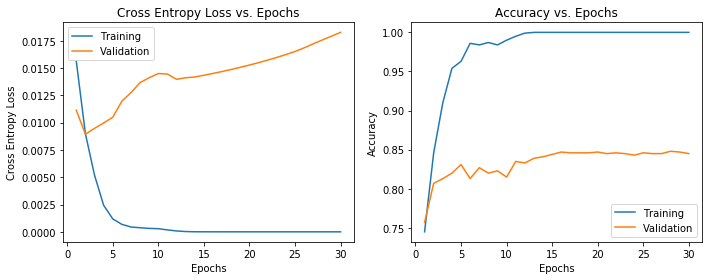

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.735, 0.744, 0.016407938816717694, 0.012070143043994903]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.832, 0.799, 0.009395976428170593, 0.009583179384469986]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.906, 0.809, 0.005451633420677817, 0.010328382283449173]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.943, 0.813, 0.0025990202020929783, 0.011543595433235168]
Starting epoch 5 / 30
better val accuracy: update model.
progress: [0.957, 0.817, 0.001453283624381435, 0.013143812268972398]
Starting epoch 6 / 30
better val accuracy: update model.
progress: [0.977, 0.83, 0.0009527328423015317, 0.012518335223197938]
Starting epoch 7 / 30
progress: [0.982, 0.819, 0.000673950158838867, 0.014162622183561326]
Starting epoch 8 / 30
better val accuracy: update model.
progress: [0.986, 0.832, 0.0005690067890005148, 0.013852735936641693]
Starting epoch 9 / 30
pro

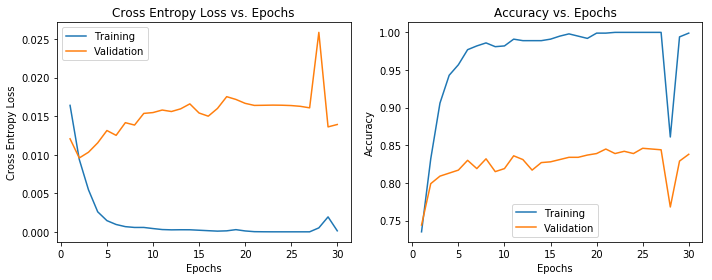

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.738, 0.739, 0.015704011378239614, 0.011666735172271729]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.84, 0.783, 0.008983368535431064, 0.01006402513384819]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.919, 0.811, 0.005126167386922301, 0.01003361800312996]
Starting epoch 4 / 30
progress: [0.954, 0.81, 0.0023684101536565897, 0.011403526544570924]
Starting epoch 5 / 30
better val accuracy: update model.
progress: [0.974, 0.834, 0.0012011578294771666, 0.012013487368822098]
Starting epoch 6 / 30
progress: [0.985, 0.826, 0.0007100031398122712, 0.013003826320171356]
Starting epoch 7 / 30
progress: [0.987, 0.827, 0.0004549669446233584, 0.013892978221178055]
Starting epoch 8 / 30
progress: [0.991, 0.818, 0.00031019818478701064, 0.014183416426181794]
Starting epoch 9 / 30
progress: [0.988, 0.826, 0.00030055387268717194, 0.01430676954984665]
Starting epoch 10 / 30
progress: [0.99

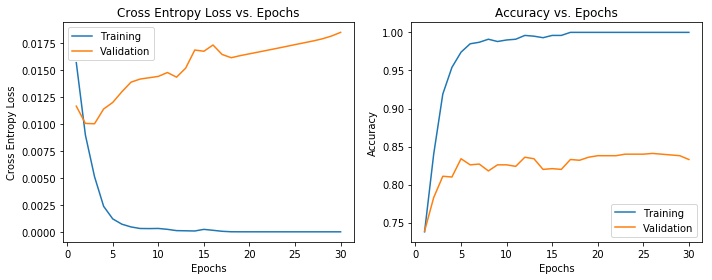

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.724, 0.725, 0.01649790420094315, 0.011959555089473724]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.822, 0.773, 0.00926933531797662, 0.010751902848482132]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.911, 0.794, 0.005287974841588614, 0.010952068537473679]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.939, 0.795, 0.0025434237285232057, 0.012664217799901963]
Starting epoch 5 / 30
better val accuracy: update model.
progress: [0.961, 0.818, 0.0014507633464753019, 0.012810916304588318]
Starting epoch 6 / 30
progress: [0.984, 0.806, 0.0009088884043526285, 0.014480079054832458]
Starting epoch 7 / 30
progress: [0.983, 0.8, 0.0005954457440185456, 0.016558911442756653]
Starting epoch 8 / 30
progress: [0.985, 0.793, 0.0005641140465396552, 0.015060241430997849]
Starting epoch 9 / 30
progress: [0.982, 0.816, 0.0005484581731250319, 0.01599848824739456]
Start

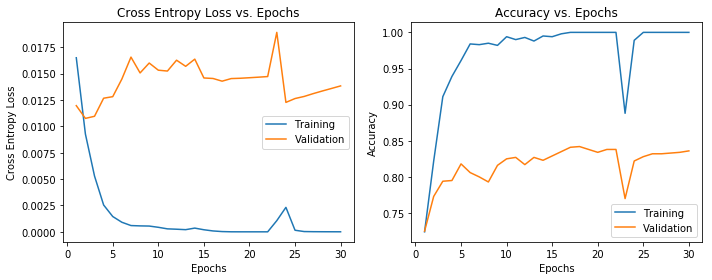

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.73, 0.731, 0.01618993786463932, 0.012119349539279938]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.825, 0.781, 0.00937289822101593, 0.01007595643401146]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.897, 0.786, 0.005419689276844871, 0.01039983332157135]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.943, 0.799, 0.0024403524477110833, 0.011677925765514375]
Starting epoch 5 / 30
better val accuracy: update model.
progress: [0.974, 0.811, 0.0012901522560919425, 0.012550705969333649]
Starting epoch 6 / 30
better val accuracy: update model.
progress: [0.978, 0.814, 0.0008166258259847456, 0.012938329577445984]
Starting epoch 7 / 30
progress: [0.981, 0.807, 0.0005470477386700864, 0.015245806276798248]
Starting epoch 8 / 30
better val accuracy: update model.
progress: [0.989, 0.818, 0.00046015728903193103, 0.014572968780994415]
Starting epoch 9 / 30
prog

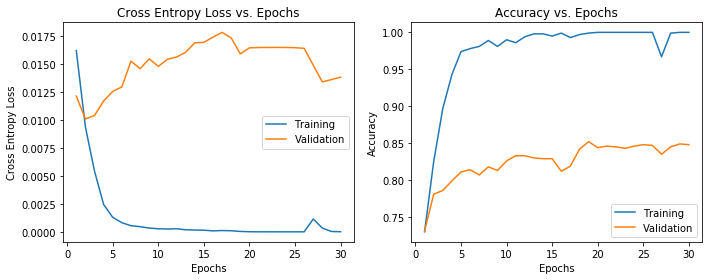

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.729, 0.731, 0.0168828785413382, 0.011850382387638091]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.828, 0.776, 0.009410323885022378, 0.00960990884900093]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.902, 0.815, 0.0053096914910236185, 0.009675148338079453]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.957, 0.825, 0.002341790284087159, 0.011021228849887849]
Starting epoch 5 / 30
progress: [0.972, 0.816, 0.0011405616880641603, 0.012349648743867875]
Starting epoch 6 / 30
progress: [0.972, 0.824, 0.0006826934832699445, 0.014033765256404877]
Starting epoch 7 / 30
progress: [0.983, 0.82, 0.000492504765897305, 0.014535427272319794]
Starting epoch 8 / 30
progress: [0.982, 0.814, 0.0004304161928261497, 0.016036169469356536]
Starting epoch 9 / 30
progress: [0.985, 0.815, 0.00032907994759592173, 0.016714601039886475]
Starting epoch 10 / 30
better val accur

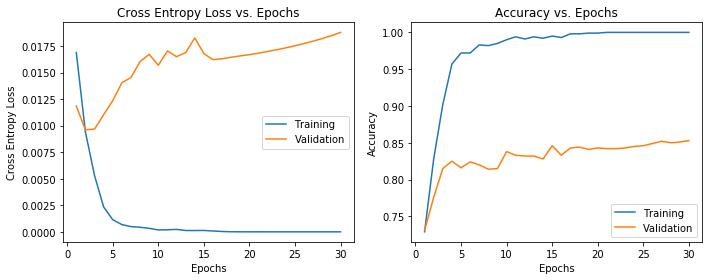

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.712, 0.708, 0.016551564829690116, 0.012120714604854584]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.814, 0.779, 0.009351592224167317, 0.010589377731084823]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.906, 0.79, 0.005335616478582426, 0.01081920838356018]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.943, 0.796, 0.002359038805703119, 0.012465675324201585]
Starting epoch 5 / 30
better val accuracy: update model.
progress: [0.973, 0.8, 0.0012260971950101, 0.012319743931293488]
Starting epoch 6 / 30
better val accuracy: update model.
progress: [0.975, 0.824, 0.0007953327007648745, 0.012642782509326935]
Starting epoch 7 / 30
progress: [0.98, 0.823, 0.0005477123461207565, 0.014023170650005341]
Starting epoch 8 / 30
progress: [0.983, 0.817, 0.00046111749746475595, 0.014067615598440171]
Starting epoch 9 / 30
progress: [0.989, 0.824, 0.0003266996705419

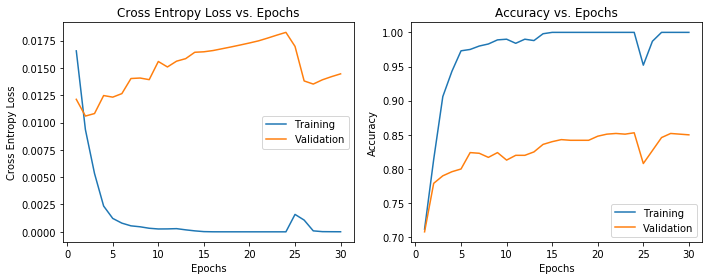

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.71, 0.73, 0.015964873779793175, 0.012194078862667084]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.824, 0.778, 0.009173276438396804, 0.010704537659883499]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.911, 0.816, 0.005419538480286696, 0.010559538275003433]
Starting epoch 4 / 30
progress: [0.936, 0.805, 0.002528786990981625, 0.011664936006069184]
Starting epoch 5 / 30
progress: [0.97, 0.812, 0.001308309968560934, 0.012953309237957001]
Starting epoch 6 / 30
progress: [0.977, 0.811, 0.0007792174702852356, 0.013845673561096191]
Starting epoch 7 / 30
better val accuracy: update model.
progress: [0.987, 0.822, 0.0005374066401795693, 0.01421876335144043]
Starting epoch 8 / 30
progress: [0.983, 0.816, 0.0004362490036410793, 0.014169994175434113]
Starting epoch 9 / 30
better val accuracy: update model.
progress: [0.983, 0.828, 0.0004965481941151071, 0.014628010094165802]
Starti

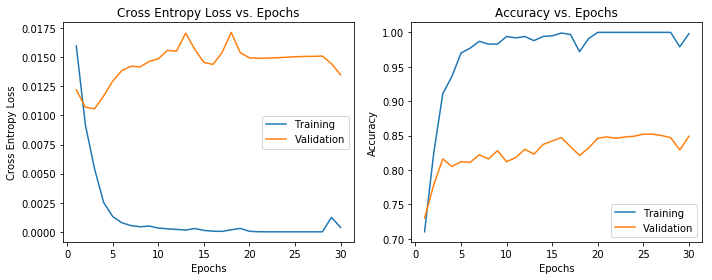

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.746, 0.737, 0.01576718750170299, 0.011357313722372055]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.856, 0.792, 0.008927121807421957, 0.009734652072191239]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.924, 0.812, 0.005052732874240194, 0.009875192284584045]
Starting epoch 4 / 30
progress: [0.944, 0.8, 0.0022627555528389556, 0.0111003757417202]
Starting epoch 5 / 30
better val accuracy: update model.
progress: [0.972, 0.821, 0.0011751403337800686, 0.012053546726703643]
Starting epoch 6 / 30
progress: [0.979, 0.821, 0.0006961010390398453, 0.01311812835931778]
Starting epoch 7 / 30
better val accuracy: update model.
progress: [0.986, 0.832, 0.0005207783717053885, 0.012930384933948517]
Starting epoch 8 / 30
better val accuracy: update model.
progress: [0.993, 0.834, 0.0004477403976821474, 0.012851491898298264]
Starting epoch 9 / 30
progress: [0.987, 0.828, 0.00029708777310

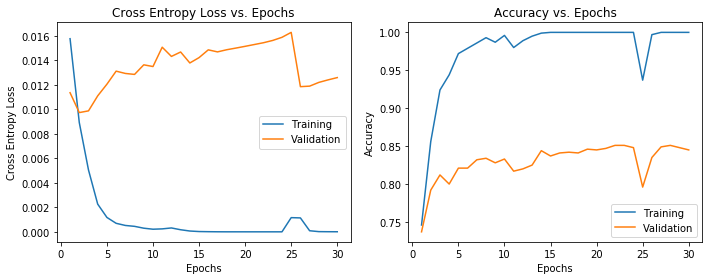

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.742, 0.761, 0.016197585679438648, 0.011283193528652192]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.835, 0.797, 0.009063432576704998, 0.01008714011311531]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.892, 0.809, 0.005186048365369135, 0.009920235067605972]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.947, 0.815, 0.002417829609342984, 0.011528482764959335]
Starting epoch 5 / 30
better val accuracy: update model.
progress: [0.963, 0.825, 0.0012411408197058706, 0.012193744003772735]
Starting epoch 6 / 30
better val accuracy: update model.
progress: [0.977, 0.829, 0.0007753030536126117, 0.012006611049175263]
Starting epoch 7 / 30
progress: [0.985, 0.817, 0.0006406244921963661, 0.012693369626998902]
Starting epoch 8 / 30
progress: [0.98, 0.806, 0.0004799440496230536, 0.015152614295482635]
Starting epoch 9 / 30
progress: [0.992, 0.829, 0.00033130945

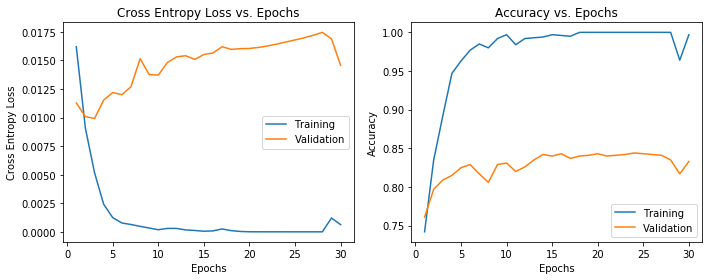

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.746, 0.734, 0.01614606055191585, 0.012159110188484193]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.846, 0.806, 0.009195156063048207, 0.009598020642995834]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.905, 0.809, 0.005390689006721487, 0.01017377233505249]
Starting epoch 4 / 30
progress: [0.933, 0.801, 0.002702003969449778, 0.011928981244564056]
Starting epoch 5 / 30
progress: [0.959, 0.809, 0.0014712364627618572, 0.011977299839258194]
Starting epoch 6 / 30
better val accuracy: update model.
progress: [0.979, 0.82, 0.0009857511586528651, 0.012935400635004044]
Starting epoch 7 / 30
progress: [0.984, 0.81, 0.0006335816299162653, 0.014138347119092941]
Starting epoch 8 / 30
progress: [0.98, 0.807, 0.0005042430268486544, 0.01565254318714142]
Starting epoch 9 / 30
better val accuracy: update model.
progress: [0.99, 0.833, 0.000485172723572017, 0.013326986610889435]
Starting 

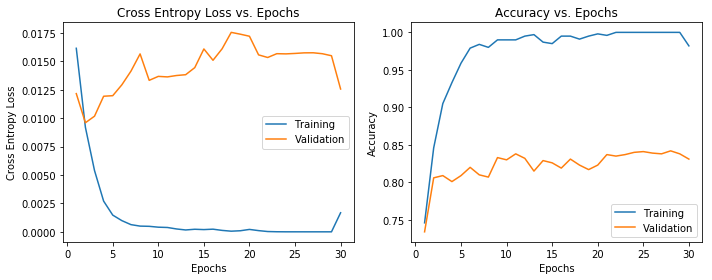

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.725, 0.74, 0.01569509071050858, 0.011909860491752624]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.824, 0.785, 0.009068130893974888, 0.010968369096517563]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.9, 0.803, 0.005306750327500762, 0.011009128957986832]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.948, 0.816, 0.002584434702498268, 0.01175054806470871]
Starting epoch 5 / 30
better val accuracy: update model.
progress: [0.96, 0.818, 0.0012996846409704611, 0.012090074062347413]
Starting epoch 6 / 30
progress: [0.972, 0.799, 0.0007447926397364092, 0.01493116083741188]
Starting epoch 7 / 30
better val accuracy: update model.
progress: [0.972, 0.82, 0.0006230565468134473, 0.014824761927127839]
Starting epoch 8 / 30
better val accuracy: update model.
progress: [0.984, 0.829, 0.0004714130866151227, 0.013766562342643738]
Starting epoch 9 / 30
progress:

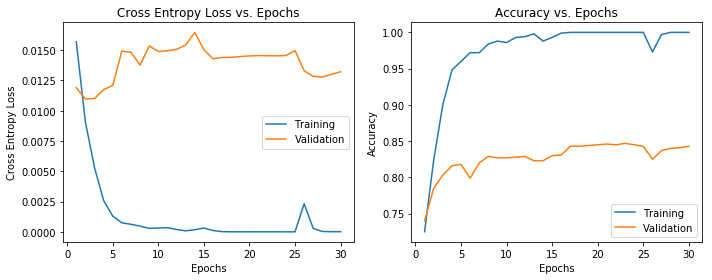

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.721, 0.736, 0.016356833831388123, 0.012123106479644775]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.799, 0.767, 0.00949415281323754, 0.010626546174287797]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.886, 0.808, 0.005659403260569183, 0.010348316818475723]
Starting epoch 4 / 30
progress: [0.941, 0.796, 0.002740483712290927, 0.011717987179756164]
Starting epoch 5 / 30
better val accuracy: update model.
progress: [0.952, 0.81, 0.0015072681356449516, 0.012949855953454971]
Starting epoch 6 / 30
progress: [0.968, 0.809, 0.0009308403337146251, 0.013906928688287735]
Starting epoch 7 / 30
progress: [0.976, 0.798, 0.0006320761155375108, 0.01571223869919777]
Starting epoch 8 / 30
better val accuracy: update model.
progress: [0.981, 0.814, 0.0005892346152104437, 0.015309555530548096]
Starting epoch 9 / 30
better val accuracy: update model.
progress: [0.979, 0.819, 0.000450403457

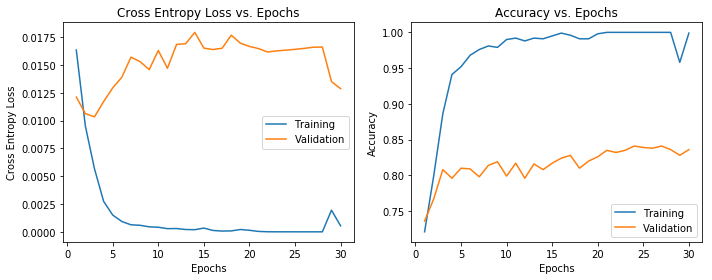

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.713, 0.716, 0.016341564748968397, 0.012352100670337677]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.82, 0.793, 0.009367600772757919, 0.01035662093758583]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.9, 0.796, 0.005470619029232434, 0.010714213401079177]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.955, 0.818, 0.0025307547925610325, 0.011492441236972809]
Starting epoch 5 / 30
progress: [0.963, 0.8, 0.0012816699139241662, 0.013230852037668227]
Starting epoch 6 / 30
progress: [0.965, 0.799, 0.0008751821298798432, 0.013590041041374207]
Starting epoch 7 / 30
progress: [0.982, 0.811, 0.0006260180529777189, 0.013467540234327316]
Starting epoch 8 / 30
progress: [0.987, 0.812, 0.00043297497434921717, 0.013458684206008912]
Starting epoch 9 / 30
better val accuracy: update model.
progress: [0.99, 0.823, 0.0003771126326696225, 0.015101356953382493]
Starti

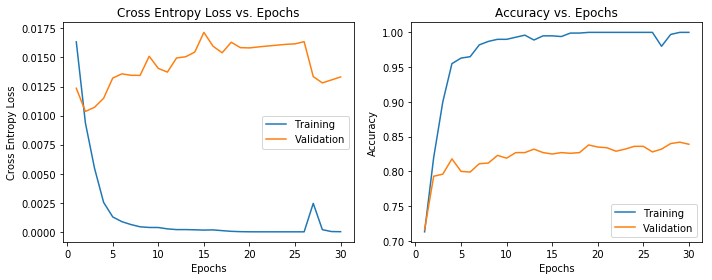

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.748, 0.741, 0.01616846962121068, 0.011781837433576584]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.828, 0.788, 0.009153424236847429, 0.010276400178670883]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.896, 0.801, 0.00532000643820787, 0.010227662533521652]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.95, 0.811, 0.002559241099283099, 0.010920591413974763]
Starting epoch 5 / 30
progress: [0.955, 0.797, 0.0013362345428263047, 0.01274137109518051]
Starting epoch 6 / 30
progress: [0.963, 0.809, 0.0009118799912192079, 0.01332305359840393]
Starting epoch 7 / 30
progress: [0.979, 0.806, 0.0006409231588928676, 0.013695171773433686]
Starting epoch 8 / 30
progress: [0.983, 0.802, 0.00047081681016870603, 0.014684993505477905]
Starting epoch 9 / 30
better val accuracy: update model.
progress: [0.98, 0.818, 0.0003939975042333256, 0.014559979677200317]
Starti

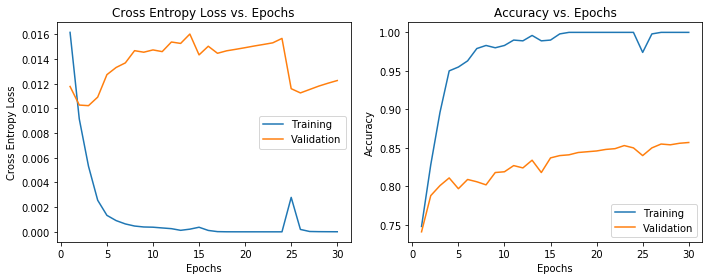

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.733, 0.73, 0.015454930641821452, 0.011589301526546478]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.83, 0.79, 0.008822031615035874, 0.009643586903810501]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.902, 0.805, 0.0050633448175325686, 0.009669850081205368]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.96, 0.812, 0.0023439804662247093, 0.011298139303922653]
Starting epoch 5 / 30
progress: [0.978, 0.805, 0.0011901895185286292, 0.011739425599575042]
Starting epoch 6 / 30
better val accuracy: update model.
progress: [0.987, 0.814, 0.0006628312044301811, 0.01224876356124878]
Starting epoch 7 / 30
better val accuracy: update model.
progress: [0.975, 0.818, 0.0004989381265655464, 0.013389138191938401]
Starting epoch 8 / 30
better val accuracy: update model.
progress: [0.987, 0.822, 0.0004718245374685039, 0.012981275022029877]
Starting epoch 9 / 30
bett

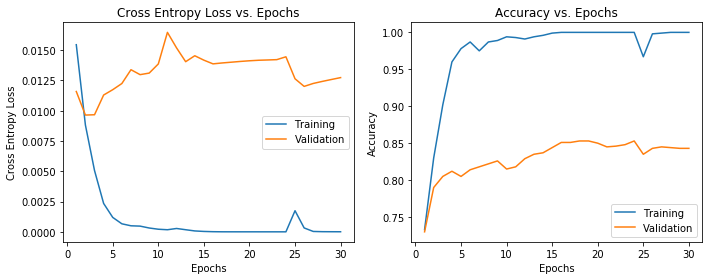

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.728, 0.717, 0.016388390032612547, 0.012211993277072907]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.823, 0.768, 0.009313308702439679, 0.010515467166900635]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.912, 0.817, 0.005272221012155012, 0.0101048084795475]
Starting epoch 4 / 30
progress: [0.953, 0.807, 0.0022984470324020605, 0.01130294817686081]
Starting epoch 5 / 30
progress: [0.97, 0.806, 0.0012176194353105158, 0.013344653815031051]
Starting epoch 6 / 30
better val accuracy: update model.
progress: [0.983, 0.818, 0.0007510072128961281, 0.013598265647888184]
Starting epoch 7 / 30
progress: [0.98, 0.804, 0.000522465705348901, 0.013313471794128418]
Starting epoch 8 / 30
progress: [0.982, 0.812, 0.0004111994843150736, 0.01528538578748703]
Starting epoch 9 / 30
better val accuracy: update model.
progress: [0.993, 0.82, 0.00024770229578265275, 0.014601731270551681]
Startin

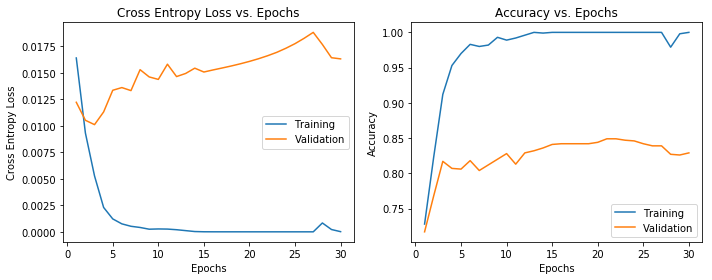

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.733, 0.743, 0.015341904734470406, 0.01176467514038086]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.846, 0.813, 0.008825737979947304, 0.009421407103538513]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.914, 0.822, 0.005007271175329783, 0.00927219220995903]
Starting epoch 4 / 30
progress: [0.958, 0.813, 0.0022701014703785886, 0.010617002338171005]
Starting epoch 5 / 30
progress: [0.962, 0.819, 0.0010857457956584284, 0.012247965544462204]
Starting epoch 6 / 30
progress: [0.988, 0.821, 0.0007358246646555407, 0.012583063662052155]
Starting epoch 7 / 30
better val accuracy: update model.
progress: [0.985, 0.832, 0.0005110340899008573, 0.01309086748957634]
Starting epoch 8 / 30
better val accuracy: update model.
progress: [0.978, 0.835, 0.0004569573154749007, 0.013226667702198028]
Starting epoch 9 / 30
progress: [0.986, 0.826, 0.00026639143755298337, 0.014672080010175705]
St

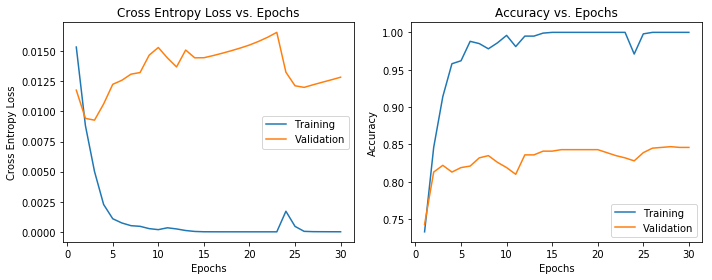

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.705, 0.741, 0.015623142992963596, 0.012100203037261963]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.83, 0.816, 0.008986241374088794, 0.009731267869472504]
Starting epoch 3 / 30
progress: [0.91, 0.811, 0.005138948534976463, 0.009562988460063935]
Starting epoch 4 / 30
progress: [0.94, 0.805, 0.002443019998544941, 0.01121973353624344]
Starting epoch 5 / 30
progress: [0.967, 0.815, 0.001285727320048882, 0.012181348204612731]
Starting epoch 6 / 30
progress: [0.973, 0.798, 0.0007809131981006691, 0.013299434125423431]
Starting epoch 7 / 30
progress: [0.987, 0.799, 0.0004918633926260684, 0.01393506121635437]
Starting epoch 8 / 30
progress: [0.988, 0.814, 0.0003483152555453838, 0.01301211416721344]
Starting epoch 9 / 30
progress: [0.977, 0.811, 0.00041932609148931745, 0.013064733982086182]
Starting epoch 10 / 30
better val accuracy: update model.
progress: [0.991, 0.829, 0.00034502150459994314, 0.013

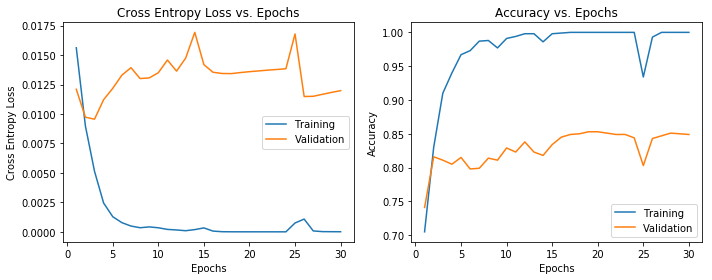

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.744, 0.746, 0.015947061715685593, 0.01166107639670372]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.824, 0.779, 0.009417987283395261, 0.010536351025104522]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.897, 0.796, 0.005628327826304095, 0.010201720297336578]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.962, 0.817, 0.002716512826328375, 0.010649846702814101]
Starting epoch 5 / 30
progress: [0.966, 0.817, 0.0014098452838251785, 0.01258423724770546]
Starting epoch 6 / 30
progress: [0.976, 0.811, 0.0008262175469355164, 0.013298598825931549]
Starting epoch 7 / 30
better val accuracy: update model.
progress: [0.978, 0.822, 0.0005493704269887233, 0.01323963987827301]
Starting epoch 8 / 30
progress: [0.987, 0.817, 0.000415216788126878, 0.013767625629901886]
Starting epoch 9 / 30
progress: [0.991, 0.817, 0.0004361363124881624, 0.014412796169519425]
Start

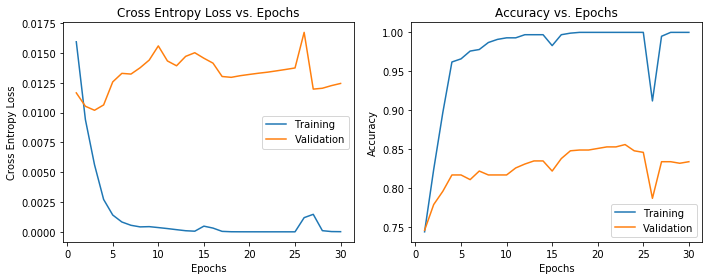

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.709, 0.725, 0.01607578534861, 0.012344166994094848]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.823, 0.789, 0.009195103962202461, 0.009823524981737136]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.9, 0.805, 0.005291980854254596, 0.010641385197639465]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.946, 0.825, 0.002445643426090175, 0.011507511973381042]
Starting epoch 5 / 30
progress: [0.979, 0.816, 0.0012252157937488234, 0.011848724871873856]
Starting epoch 6 / 30
progress: [0.971, 0.81, 0.0007759953659141855, 0.013567029058933259]
Starting epoch 7 / 30
progress: [0.981, 0.821, 0.0004937226213419772, 0.01239981922507286]
Starting epoch 8 / 30
progress: [0.979, 0.812, 0.00040047982181137316, 0.014726959228515624]
Starting epoch 9 / 30
better val accuracy: update model.
progress: [0.99, 0.827, 0.0004056700587804828, 0.01426533156633377]
Starting e

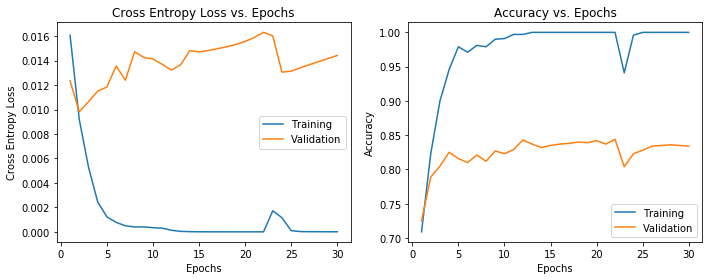

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.736, 0.749, 0.015672026585559457, 0.011357358336448669]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.832, 0.783, 0.009123594265507191, 0.00983180120587349]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.882, 0.788, 0.0052973415892647235, 0.010995168328285218]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.943, 0.796, 0.00254916798216956, 0.012446193724870682]
Starting epoch 5 / 30
better val accuracy: update model.
progress: [0.965, 0.815, 0.0012441376437223991, 0.012594765424728394]
Starting epoch 6 / 30
progress: [0.975, 0.808, 0.0007424331406245426, 0.013321004450321198]
Starting epoch 7 / 30
better val accuracy: update model.
progress: [0.99, 0.821, 0.000506696678964155, 0.014172873556613922]
Starting epoch 8 / 30
progress: [0.989, 0.805, 0.0004300848598382911, 0.014898676097393036]
Starting epoch 9 / 30
progress: [0.98, 0.806, 0.0003523669807

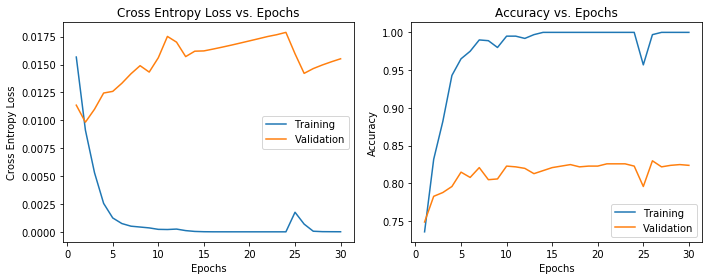

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.738, 0.745, 0.015906878833868064, 0.011416082322597504]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.834, 0.791, 0.009279460587063615, 0.009990613728761673]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.891, 0.805, 0.0054097912712972995, 0.010123359829187393]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.954, 0.813, 0.0025620842571465337, 0.011543872177600861]
Starting epoch 5 / 30
progress: [0.958, 0.803, 0.0013024826574386382, 0.012942042350769043]
Starting epoch 6 / 30
better val accuracy: update model.
progress: [0.975, 0.823, 0.0008813552275509099, 0.013768105655908585]
Starting epoch 7 / 30
better val accuracy: update model.
progress: [0.987, 0.829, 0.0005802315142176741, 0.014129914820194244]
Starting epoch 8 / 30
progress: [0.989, 0.819, 0.000460560220369727, 0.014462464511394501]
Starting epoch 9 / 30
progress: [0.975, 0.819, 0.00047485

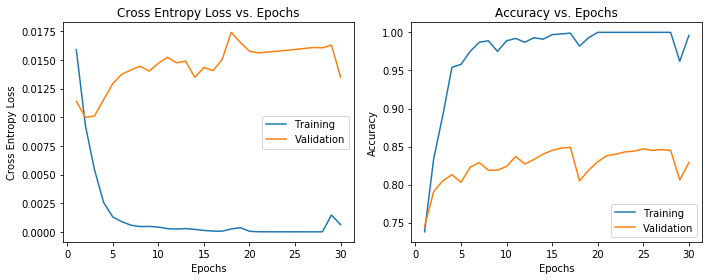

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.726, 0.739, 0.0165758440987188, 0.011448713928461075]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.823, 0.782, 0.009439860050167356, 0.010163698673248291]
Starting epoch 3 / 30
progress: [0.888, 0.774, 0.005571424828348111, 0.010954044997692107]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.934, 0.807, 0.0027113443890548483, 0.010990886628627777]
Starting epoch 5 / 30
progress: [0.959, 0.78, 0.0014611379472272738, 0.013453965336084365]
Starting epoch 6 / 30
progress: [0.968, 0.791, 0.000912752106842794, 0.01481346568465233]
Starting epoch 7 / 30
better val accuracy: update model.
progress: [0.989, 0.811, 0.00071308499709608, 0.014362191319465638]
Starting epoch 8 / 30
progress: [0.98, 0.811, 0.0005337054678714092, 0.014519262611865997]
Starting epoch 9 / 30
better val accuracy: update model.
progress: [0.985, 0.822, 0.0004730372453602601, 0.014627619206905366]
Starting

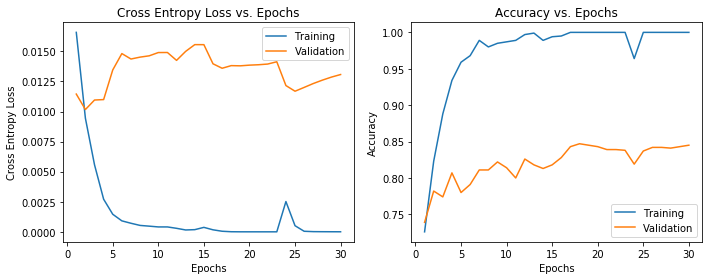

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.709, 0.725, 0.016459461516871745, 0.011910529434680938]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.815, 0.767, 0.009269357979905848, 0.01018112376332283]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.886, 0.808, 0.00537552938534289, 0.009904136002063751]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.953, 0.819, 0.0024702527223497022, 0.011014887690544128]
Starting epoch 5 / 30
progress: [0.968, 0.816, 0.0014043796655664944, 0.011588694095611573]
Starting epoch 6 / 30
better val accuracy: update model.
progress: [0.97, 0.822, 0.0009319074488986208, 0.012959125995635987]
Starting epoch 7 / 30
progress: [0.983, 0.82, 0.0006363004149146835, 0.014316488683223725]
Starting epoch 8 / 30
better val accuracy: update model.
progress: [0.985, 0.831, 0.000494906700520339, 0.01299023398756981]
Starting epoch 9 / 30
progress: [0.984, 0.823, 0.00043523300342

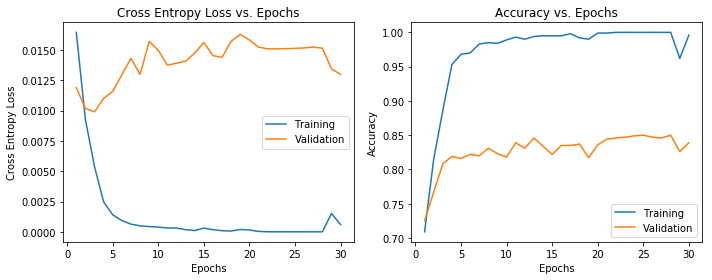

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.739, 0.747, 0.015828660282553458, 0.011382253289222717]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.827, 0.794, 0.009188695323406434, 0.01020064827799797]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.911, 0.803, 0.005363505345065983, 0.010677817702293396]
Starting epoch 4 / 30
progress: [0.936, 0.783, 0.002627578828445807, 0.013522092640399932]
Starting epoch 5 / 30
progress: [0.961, 0.798, 0.0014122281542846135, 0.013507719427347183]
Starting epoch 6 / 30
progress: [0.97, 0.792, 0.000963251165760567, 0.014527232050895691]
Starting epoch 7 / 30
better val accuracy: update model.
progress: [0.97, 0.814, 0.0006891930637386988, 0.014393215894699097]
Starting epoch 8 / 30
progress: [0.984, 0.814, 0.0004917659430042366, 0.01496887817978859]
Starting epoch 9 / 30
better val accuracy: update model.
progress: [0.983, 0.816, 0.00038642985160861694, 0.01593722516298294]
Starti

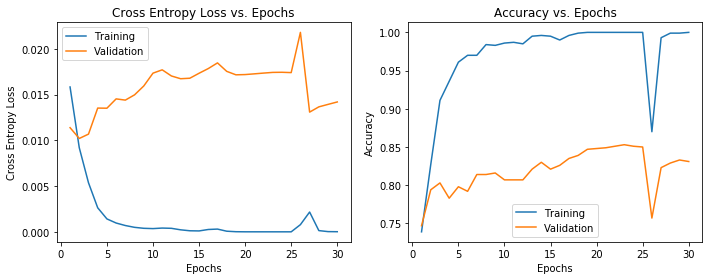

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.734, 0.733, 0.015983337041674827, 0.012146149158477783]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.829, 0.783, 0.009058756606311214, 0.010118193238973618]
Starting epoch 3 / 30
progress: [0.893, 0.783, 0.0051156372840003095, 0.011163506329059601]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.923, 0.794, 0.0022616196667433392, 0.012341713607311249]
Starting epoch 5 / 30
better val accuracy: update model.
progress: [0.971, 0.819, 0.0013111902797328574, 0.011663593977689743]
Starting epoch 6 / 30
progress: [0.979, 0.818, 0.0008317979552916118, 0.01309360021352768]
Starting epoch 7 / 30
better val accuracy: update model.
progress: [0.987, 0.826, 0.0005123722161432462, 0.013185139387845993]
Starting epoch 8 / 30
progress: [0.976, 0.826, 0.0003059772861009578, 0.0140602745115757]
Starting epoch 9 / 30
better val accuracy: update model.
progress: [0.987, 0.83, 0.00040342097

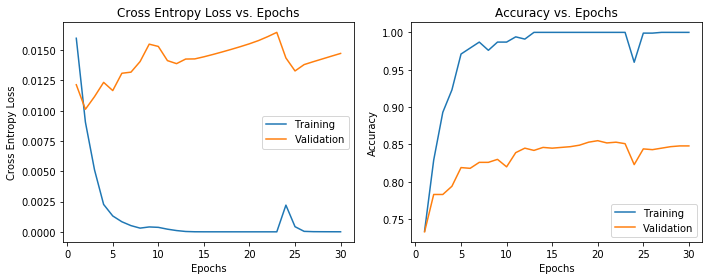

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.732, 0.724, 0.016284454637036032, 0.012172245860099792]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.824, 0.794, 0.009187873731158218, 0.009501141250133514]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.907, 0.802, 0.005241082797397156, 0.010564532369375228]
Starting epoch 4 / 30
progress: [0.942, 0.801, 0.002419807895789949, 0.012590602815151215]
Starting epoch 5 / 30
better val accuracy: update model.
progress: [0.964, 0.811, 0.0012487950303724834, 0.012593266665935516]
Starting epoch 6 / 30
progress: [0.973, 0.804, 0.0008145390724839301, 0.014905489265918732]
Starting epoch 7 / 30
better val accuracy: update model.
progress: [0.985, 0.812, 0.0005717426682442275, 0.014222353100776672]
Starting epoch 8 / 30
progress: [0.985, 0.812, 0.0004547422133737757, 0.015214709103107453]
Starting epoch 9 / 30
better val accuracy: update model.
progress: [0.982, 0.815, 0.000427862

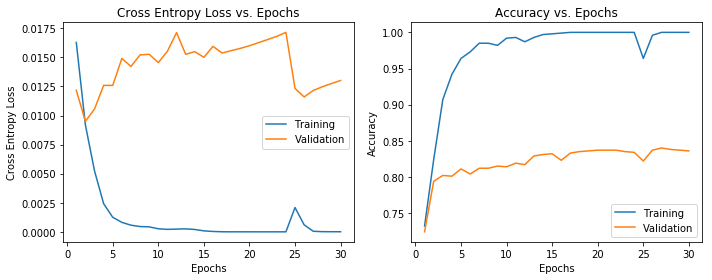

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.745, 0.743, 0.01588215217541675, 0.011469108253717422]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.836, 0.797, 0.009140589689113656, 0.009630470275878907]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.897, 0.798, 0.005434661442984124, 0.010025786370038986]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.943, 0.8, 0.002587797953614167, 0.011838776499032973]
Starting epoch 5 / 30
better val accuracy: update model.
progress: [0.95, 0.805, 0.0012942840648929076, 0.012654540956020355]
Starting epoch 6 / 30
better val accuracy: update model.
progress: [0.978, 0.807, 0.0009241271800152502, 0.012518301457166672]
Starting epoch 7 / 30
better val accuracy: update model.
progress: [0.982, 0.824, 0.0005778875633199908, 0.012924222111701964]
Starting epoch 8 / 30
progress: [0.985, 0.816, 0.00040212235831636555, 0.01514664387702942]
Starting epoch 9 / 30
bette

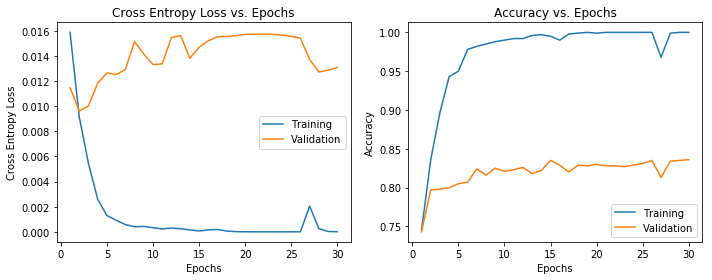

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.73, 0.746, 0.015709570982018296, 0.011757962107658386]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.832, 0.792, 0.009034620902368, 0.009883142679929733]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.912, 0.803, 0.005155969716532498, 0.010225217431783677]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.954, 0.808, 0.0023304002527527665, 0.011826039999723434]
Starting epoch 5 / 30
progress: [0.969, 0.803, 0.0011588554252699322, 0.012657680690288544]
Starting epoch 6 / 30
better val accuracy: update model.
progress: [0.973, 0.813, 0.0007435141120543133, 0.013524128317832947]
Starting epoch 7 / 30
progress: [0.985, 0.807, 0.0005087870696787628, 0.01480239713191986]
Starting epoch 8 / 30
progress: [0.991, 0.802, 0.0003885241093788752, 0.0145999094247818]
Starting epoch 9 / 30
progress: [0.991, 0.805, 0.00041257686521477846, 0.014781921982765197]
Starti

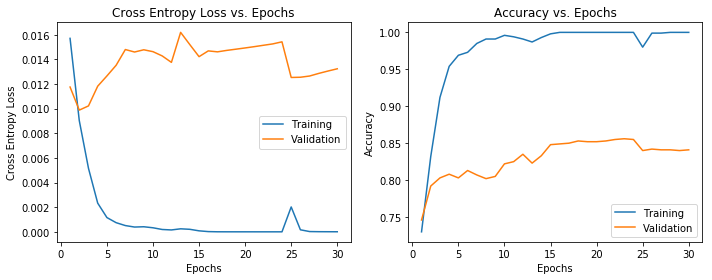

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.738, 0.742, 0.015497489407962682, 0.011618508636951446]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.862, 0.795, 0.008871793743298979, 0.009354518383741378]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.916, 0.799, 0.005121424297897183, 0.010228879749774933]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.954, 0.809, 0.002350670173194031, 0.011047589749097824]
Starting epoch 5 / 30
better val accuracy: update model.
progress: [0.978, 0.813, 0.0011459818380333635, 0.012015451937913894]
Starting epoch 6 / 30
better val accuracy: update model.
progress: [0.985, 0.823, 0.00067130830535209, 0.012381093353033066]
Starting epoch 7 / 30
progress: [0.986, 0.821, 0.0004823259237051314, 0.012868072777986527]
Starting epoch 8 / 30
progress: [0.984, 0.822, 0.0004273234249795882, 0.013923662781715394]
Starting epoch 9 / 30
better val accuracy: update model.
pro

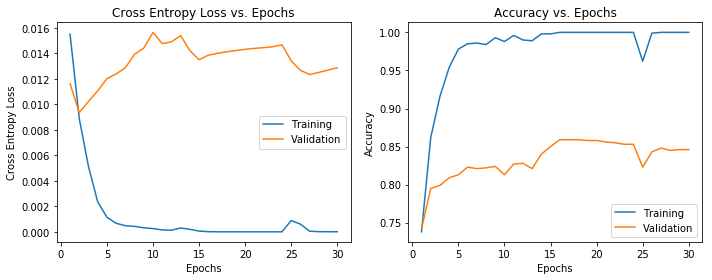

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.722, 0.731, 0.016443238465153442, 0.01203398209810257]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.836, 0.782, 0.009448174764915388, 0.010323202788829804]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.894, 0.808, 0.00554662657605142, 0.010542291462421418]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.932, 0.813, 0.0025990366465126983, 0.011703426510095597]
Starting epoch 5 / 30
progress: [0.968, 0.811, 0.0013453751817649724, 0.012450918614864349]
Starting epoch 6 / 30
better val accuracy: update model.
progress: [0.971, 0.816, 0.0008857137997615702, 0.013084758132696151]
Starting epoch 7 / 30
progress: [0.983, 0.811, 0.0006348786534627482, 0.013744187653064727]
Starting epoch 8 / 30
progress: [0.983, 0.797, 0.0004964245817700058, 0.014821995735168457]
Starting epoch 9 / 30
progress: [0.988, 0.809, 0.0005017517511352745, 0.013969381511211396]
St

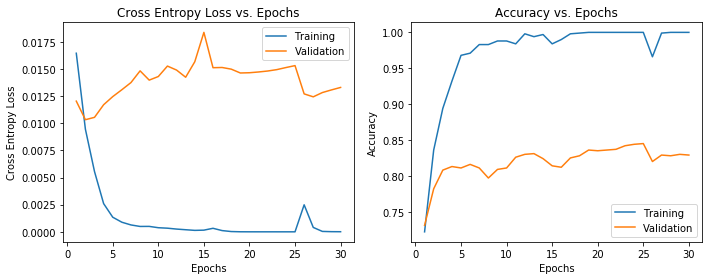

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.744, 0.769, 0.015500629908576303, 0.010935775518417358]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.833, 0.808, 0.008890928088098157, 0.009465766727924346]
Starting epoch 3 / 30
progress: [0.913, 0.803, 0.005066884737841937, 0.010206920951604843]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.965, 0.809, 0.0023300127116012937, 0.011358702659606933]
Starting epoch 5 / 30
progress: [0.97, 0.808, 0.0011263612332772844, 0.012966562449932098]
Starting epoch 6 / 30
better val accuracy: update model.
progress: [0.979, 0.814, 0.0007529410549762602, 0.013550454795360566]
Starting epoch 7 / 30
progress: [0.984, 0.81, 0.0005043113741843144, 0.014384592711925506]
Starting epoch 8 / 30
progress: [0.988, 0.79, 0.0004276543660754604, 0.015355300962924957]
Starting epoch 9 / 30
better val accuracy: update model.
progress: [0.985, 0.82, 0.00033262789341602096, 0.014429474055767059]
Sta

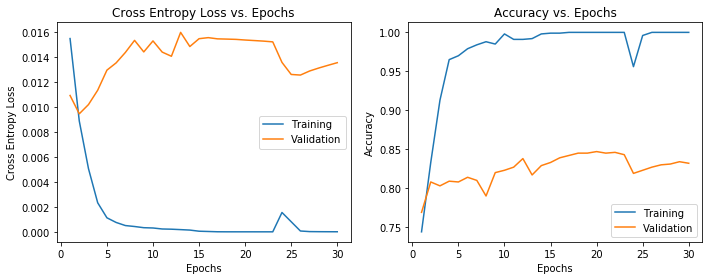

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.722, 0.736, 0.016277842599518446, 0.012179920852184296]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.837, 0.783, 0.009409841665199824, 0.010457690745592118]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.873, 0.791, 0.005554655120080831, 0.011542479068040849]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.935, 0.8, 0.0027475870116328706, 0.012541787683963775]
Starting epoch 5 / 30
better val accuracy: update model.
progress: [0.946, 0.808, 0.0014942047484219074, 0.013480172991752625]
Starting epoch 6 / 30
better val accuracy: update model.
progress: [0.982, 0.821, 0.0010528429817902494, 0.014045336186885833]
Starting epoch 7 / 30
progress: [0.988, 0.818, 0.0006947821295554084, 0.013466926336288453]
Starting epoch 8 / 30
progress: [0.981, 0.807, 0.0004836141458351393, 0.014694370865821838]
Starting epoch 9 / 30
progress: [0.981, 0.809, 0.0005506530

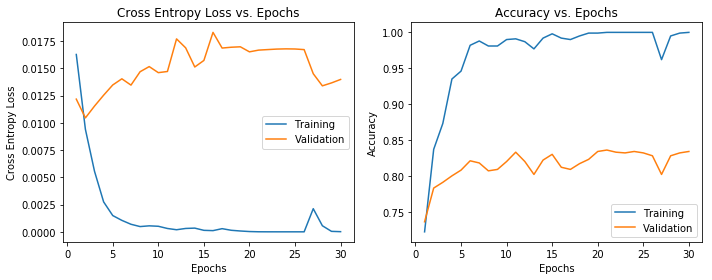

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.709, 0.721, 0.016480765163290258, 0.012354900777339936]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.819, 0.783, 0.009466057405788071, 0.009820396453142166]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.891, 0.793, 0.005605957808087067, 0.010811681598424912]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.94, 0.808, 0.0026592791233287782, 0.010810328423976898]
Starting epoch 5 / 30
progress: [0.967, 0.802, 0.0014257467622507591, 0.012099296629428864]
Starting epoch 6 / 30
progress: [0.981, 0.807, 0.000955358066634104, 0.012417093873023987]
Starting epoch 7 / 30
better val accuracy: update model.
progress: [0.976, 0.829, 0.0006856627008421537, 0.012219024270772934]
Starting epoch 8 / 30
progress: [0.987, 0.813, 0.000526901792069631, 0.013639202773571014]
Starting epoch 9 / 30
progress: [0.981, 0.806, 0.0004439574504812837, 0.01517717558145523]
Star

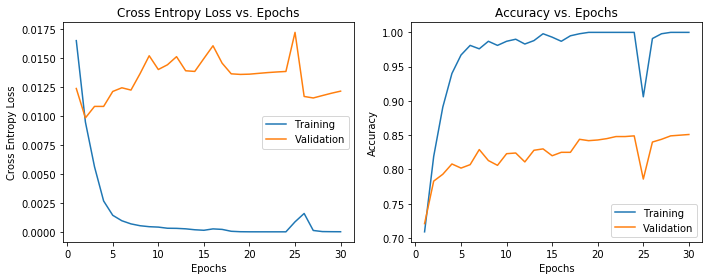

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.747, 0.755, 0.01585992302821607, 0.01096219289302826]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.826, 0.78, 0.009153232168178168, 0.009530242383480072]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.905, 0.804, 0.00534733832977256, 0.009941080808639527]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.951, 0.815, 0.0024976442920766314, 0.010831110686063766]
Starting epoch 5 / 30
progress: [0.97, 0.814, 0.0011990882418289476, 0.012505681812763214]
Starting epoch 6 / 30
progress: [0.976, 0.805, 0.0007197053004436347, 0.01473653221130371]
Starting epoch 7 / 30
progress: [0.986, 0.811, 0.0005055008445752367, 0.013714585423469544]
Starting epoch 8 / 30
progress: [0.989, 0.812, 0.00040562644732013647, 0.013991822481155396]
Starting epoch 9 / 30
progress: [0.989, 0.813, 0.0002975555186502027, 0.015553964018821717]
Starting epoch 10 / 30
progress: [0.984,

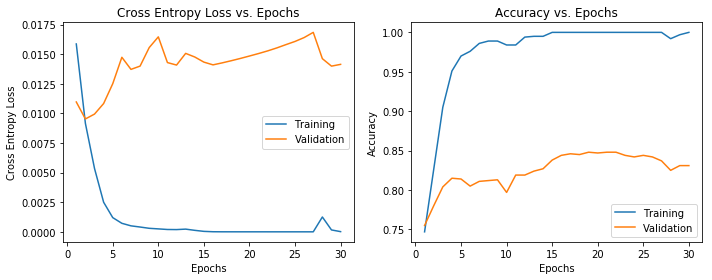

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.743, 0.744, 0.015275636557413607, 0.011428607642650605]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.838, 0.803, 0.008856324670266131, 0.009523314386606217]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.902, 0.813, 0.005149130512485091, 0.009612005293369294]
Starting epoch 4 / 30
progress: [0.952, 0.807, 0.002428397651913823, 0.011111245214939117]
Starting epoch 5 / 30
better val accuracy: update model.
progress: [0.971, 0.818, 0.0012407315214335614, 0.01153239604830742]
Starting epoch 6 / 30
progress: [0.983, 0.808, 0.000776177294124678, 0.01287713497877121]
Starting epoch 7 / 30
better val accuracy: update model.
progress: [0.989, 0.835, 0.0005088180873486004, 0.01244184085726738]
Starting epoch 8 / 30
progress: [0.985, 0.815, 0.0004108621517234311, 0.0134820556640625]
Starting epoch 9 / 30
progress: [0.993, 0.81, 0.00036330850309293186, 0.014118151903152467]
Startin

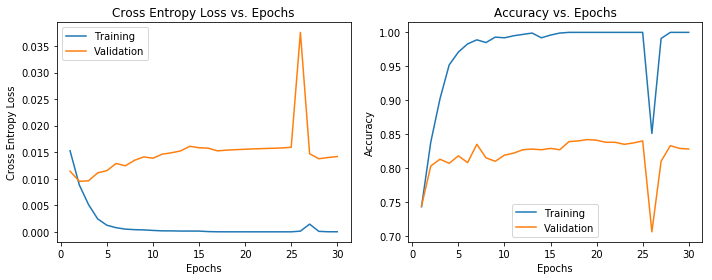

Starting epoch 1 / 30
better val accuracy: update model.
progress: [0.749, 0.739, 0.015155610293758158, 0.011355911672115327]
Starting epoch 2 / 30
better val accuracy: update model.
progress: [0.837, 0.789, 0.008790999066464755, 0.009619332879781723]
Starting epoch 3 / 30
better val accuracy: update model.
progress: [0.921, 0.817, 0.00510538787394762, 0.009401022166013717]
Starting epoch 4 / 30
better val accuracy: update model.
progress: [0.94, 0.819, 0.0023781870141701433, 0.010536409884691239]
Starting epoch 5 / 30
better val accuracy: update model.
progress: [0.956, 0.822, 0.0011840953041552282, 0.01177225324511528]
Starting epoch 6 / 30
progress: [0.978, 0.82, 0.000778596407581805, 0.012312231004238129]
Starting epoch 7 / 30
progress: [0.981, 0.807, 0.0004435933655774107, 0.01268297666311264]
Starting epoch 8 / 30
progress: [0.982, 0.808, 0.0003780594904032745, 0.014132608473300935]
Starting epoch 9 / 30
progress: [0.99, 0.819, 0.00038204074693767696, 0.01295703426003456]
Startin

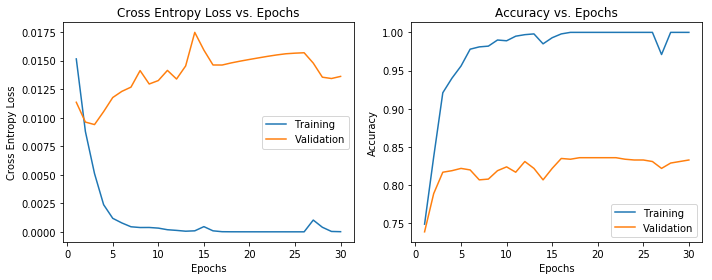

In [225]:
epochs = 30

max_count = 50  # Run random 
for count in range(max_count):
    
    reg = random.uniform(5e-8,5e-6)
    lr = random.uniform(1e-3,3e-3)
    
    best_val_acc=0.0
    model = generator().type(gpu_dtype)

    loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
    
# lr=0.0012 gives consistent 83+% test accuracy
# optimizer = optim.Adam(model.parameters(), lr=0.0012, weight_decay=reg)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

    start = time.time()

    file_name = 'm2-30ep-results/model2'+'_reg='+str('{:.4e}'.format(reg))+'lr='+str('{:.4e}'.format(lr)) \
            +'ep='+str(epochs)+'bestacc.pt'
    best_val_acc, results = train_detailed(model, loss_fn, optimizer, file_name, 
                                                    num_epochs=epochs, verbose=False)

    end = time.time()

    print('lr = {}, reg = {}.'.format(lr, reg))    
    print('Best validation accuracy is {0}. Training time for {1} epochs: {2:.2f} sec'.format(best_val_acc, 
                                                                                              epochs, end-start))
    # Plot out the accuracies and losses
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(list(range(1,len(np.array(results)[:,2])+1)), np.array(results)[:,2], label='Training')
    plt.plot(list(range(1,len(np.array(results)[:,3])+1)), np.array(results)[:,3], label='Validation')
    plt.title('Cross Entropy Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Cross Entropy Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(list(range(1,len(np.array(results)[:,0])+1)), np.array(results)[:,0], label='Training')
    plt.plot(list(range(1,len(np.array(results)[:,1])+1)), np.array(results)[:,1], label='Validation')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()

    #plt.savefig('sgd_model_plot_batch_norm_hidden_256x256.png')
    plt.show()

In [104]:
files = ['model2_reg=5e-08lr=0.001ep=50bestacc.pt',
         'model2_reg=1e-07lr=0.001ep=50bestacc.pt',
         'model2_reg=2e-07lr=0.001ep=50bestacc.pt']

for file_name in files:
    best_model = generator().type(gpu_dtype)
    best_model.load_state_dict(torch.load(file_name))

    acc = check_accuracy(best_model, loader_test)
    print ("Model {} has test accuracy of {}".format(file_name, acc))

Model model2_reg=5e-08lr=0.001ep=50bestacc.pt has test accuracy of 0.8298
Model model2_reg=1e-07lr=0.001ep=50bestacc.pt has test accuracy of 0.8323
Model model2_reg=2e-07lr=0.001ep=50bestacc.pt has test accuracy of 0.836


## Test and Validation Accuracy 

Learning rate = 3e-4
No Batch Norm Layer after Linear
Update: ADAM

* Regularization = 5e-09.  
    * Best validation accuracy is 0.839. Training time for 50 epochs: 400.14 sec  
    * Test accuracy of 0.8233  
    
* Regularization = 1e-08.  
    * Best validation accuracy is 0.842. Training time for 50 epochs: 391.01 sec  
    * Test accuracy of 0.8193  
    
* Regularization = 5e-08.  
    * Best validation accuracy is 0.837. Training time for 50 epochs: 393.30 sec
    * Test accuracy of 0.8193
    
    
Learning rate = 1.2e-3
Add Batch Norm Layer after Linear
Update: ADAM

* Regularization = 5e-08.
    * Best validation accuracy is 0.852. Training time for 50 epochs: 393.23 sec 
    * Test accuracy of 0.8335 
    
* Regularization = 1e-07.
    * Best validation accuracy is 0.857. Training time for 50 epochs: 393.09 sec  
    * Test accuracy of 0.8354  
    
* Regularization = 2e-07.
    * Best validation accuracy is 0.858. Training time for 50 epochs: 400.54 sec
    * Test accuracy of 0.8364
    
Learning rate = 1e-3
Add Batch Norm Layer after Linear
Update: ADAM

* Regularization = 5e-08.
    * Best validation accuracy is 0.848. Training time for 50 epochs: 397.33 sec 
    * Test accuracy of 0.8298 
    
* Regularization = 1e-07.
    * Best validation accuracy is 0.853. Training time for 50 epochs: 401.41 sec  
    * Test accuracy of 0.8323  
    
* Regularization = 2e-07.
    * Best validation accuracy is 0.854. Training time for 50 epochs: 397.84 sec
    * Test accuracy of 0.836

In [232]:
files = ['m2-50ep-results/model2_reg=7.8465e-07lr=1.1244e-03ep=50bestacc.pt',   # 0.871 val acc
         'm2-50ep-results/model2_reg=7.2867e-07lr=1.4721e-03ep=50bestacc.pt',   # 0.866 val acc
         'm2-50ep-results/model2_reg=1.8985e-07lr=2.8761e-03ep=50bestacc.pt',   # 0.85 val acc
         'm2-50ep-results/model2_reg=6.3784e-07lr=1.6415e-03ep=50bestacc.pt',   # 0.863 val acc
         'm2-50ep-results/model2_reg=3.1897e-07lr=2.3444e-03ep=50bestacc.pt',   # 0.861 val acc
         'm2-50ep-results/model2_reg=1.0000e-07lr=1.4898e-03ep=50bestacc.pt',   # 0.861 val acc
         'm2-50ep-results/model2_reg=2.3648e-07lr=1.9457e-03ep=50bestacc.pt',   # 0.855 val acc 
         'm2-50ep-results/model2_reg=9.0743e-07lr=1.1935e-03ep=50bestacc.pt']   # 0.865 val acc

print ("Size of CFAR10 Test Set: ", len(cifar10_test))

for file_name in files:
    best_model = generator().type(dtype)
    best_model.load_state_dict(torch.load(file_name))
    
    start = time.time()
    acc = check_accuracy(best_model, loader_test, dtype=dtype)
    end = time.time()
    
    print ("Model {} has test accuracy of {} and inference time of {}sec for the test set.  ".format(file_name, acc, end-start))

Size of CFAR10 Test Set:  10000
Model m2-50ep-results/model2_reg=7.8465e-07lr=1.1244e-03ep=50bestacc.pt has test accuracy of 0.8332 and inference time of 29.902327060699463sec for the test set.  
Model m2-50ep-results/model2_reg=7.2867e-07lr=1.4721e-03ep=50bestacc.pt has test accuracy of 0.8315 and inference time of 29.700419902801514sec for the test set.  
Model m2-50ep-results/model2_reg=1.8985e-07lr=2.8761e-03ep=50bestacc.pt has test accuracy of 0.8253 and inference time of 39.692986488342285sec for the test set.  
Model m2-50ep-results/model2_reg=6.3784e-07lr=1.6415e-03ep=50bestacc.pt has test accuracy of 0.8279 and inference time of 31.65383815765381sec for the test set.  
Model m2-50ep-results/model2_reg=3.1897e-07lr=2.3444e-03ep=50bestacc.pt has test accuracy of 0.8298 and inference time of 39.32497763633728sec for the test set.  
Model m2-50ep-results/model2_reg=1.0000e-07lr=1.4898e-03ep=50bestacc.pt has test accuracy of 0.8298 and inference time of 32.77399253845215sec for the

In [216]:
files = ['m2-50ep-results/model2_reg=7.8465e-07lr=1.1244e-03ep=50bestacc.pt',   # 0.871 val acc
         'm2-50ep-results/model2_reg=7.2867e-07lr=1.4721e-03ep=50bestacc.pt',   # 0.866 val acc
         'm2-50ep-results/model2_reg=9.0108e-07lr=1.4887e-03ep=50bestacc.pt',   # 0.862 val acc
         'm2-50ep-results/model2_reg=6.3784e-07lr=1.6415e-03ep=50bestacc.pt',   # 0.863 val acc
         'm2-50ep-results/model2_reg=3.1897e-07lr=2.3444e-03ep=50bestacc.pt',   # 0.861 val acc
         'm2-50ep-results/model2_reg=1.0000e-07lr=1.4898e-03ep=50bestacc.pt',   # 0.861 val acc
         'm2-50ep-results/model2_reg=2.3648e-07lr=1.9457e-03ep=50bestacc.pt',   # 0.855 val acc
         'm2-50ep-results/model2_reg=8.0924e-07lr=1.9370e-03ep=50bestacc.pt',   # 0.862 val acc
         'm2-50ep-results/model2_reg=5.1411e-07lr=1.3936e-03ep=50bestacc.pt',   # 0.863 val acc
         'm2-50ep-results/model2_reg=9.0743e-07lr=1.1935e-03ep=50bestacc.pt']   # 0.865 val acc

num_models = len(files)
models = []

# Create the model ensemble
for n in range(num_models):
    
    model = generator().type(gpu_dtype)
   
    # Load trained parameters into model
    file_name = files[n]
    print ("Loading {} into Model {}".format(file_name, n+1))
    model.load_state_dict(torch.load(file_name))
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)    

    models.append(model)  # Create a list of models

num_correct = 0
num_samples = 0
i = 0

for x, y in loader_test:
    x_var = Variable(x.type(gpu_dtype), volatile=True)
    num_samples += x.size()[0]
    scores_sum = torch.zeros(x.size()[0],10).type(gpu_dtype)
    
    for n in range(num_models):
        scores = models[n](x_var)
        scores_sum += scores.data

    y_pred = scores_sum.cpu().max(1)[1]
    num_correct += (y_pred == y).sum()

acc = float(num_correct) / num_samples
print ("Ensemble accuracy is {}".format(acc))


Loading m2-50ep-results/model2_reg=7.8465e-07lr=1.1244e-03ep=50bestacc.pt into Model 1
Loading m2-50ep-results/model2_reg=7.2867e-07lr=1.4721e-03ep=50bestacc.pt into Model 2
Loading m2-50ep-results/model2_reg=9.0108e-07lr=1.4887e-03ep=50bestacc.pt into Model 3
Loading m2-50ep-results/model2_reg=6.3784e-07lr=1.6415e-03ep=50bestacc.pt into Model 4
Loading m2-50ep-results/model2_reg=3.1897e-07lr=2.3444e-03ep=50bestacc.pt into Model 5
Loading m2-50ep-results/model2_reg=1.0000e-07lr=1.4898e-03ep=50bestacc.pt into Model 6
Loading m2-50ep-results/model2_reg=2.3648e-07lr=1.9457e-03ep=50bestacc.pt into Model 7
Loading m2-50ep-results/model2_reg=8.0924e-07lr=1.9370e-03ep=50bestacc.pt into Model 8
Loading m2-50ep-results/model2_reg=5.1411e-07lr=1.3936e-03ep=50bestacc.pt into Model 9
Loading m2-50ep-results/model2_reg=9.0743e-07lr=1.1935e-03ep=50bestacc.pt into Model 10
Ensemble accuracy is 0.8745


## LR Annealing Every 5 Epochs

Starting epoch 1 / 60
better val accuracy: update model.
progress: [0.739, 0.739, 0.01587577714421311, 0.011815061151981355]
Starting epoch 2 / 60
better val accuracy: update model.
progress: [0.846, 0.794, 0.009301604533682064, 0.009782143712043763]
Starting epoch 3 / 60
better val accuracy: update model.
progress: [0.896, 0.813, 0.005556283465453556, 0.009688317775726318]
Starting epoch 4 / 60
better val accuracy: update model.
progress: [0.959, 0.825, 0.002750647757506492, 0.010289240032434463]
Starting epoch 5 / 60
progress: [0.951, 0.797, 0.001444370928125418, 0.013175860702991486]
Starting epoch 6 / 60
progress: [0.98, 0.825, 0.00086578026764589, 0.013681002676486968]
Starting epoch 7 / 60
progress: [0.985, 0.824, 0.0005593491948984222, 0.01452782553434372]
Starting epoch 8 / 60
progress: [0.972, 0.807, 0.0005229784079200152, 0.01459800636768341]
Starting epoch 9 / 60
progress: [0.972, 0.816, 0.0005605847340039149, 0.01559059464931488]
Starting epoch 10 / 60
better val accuracy: 

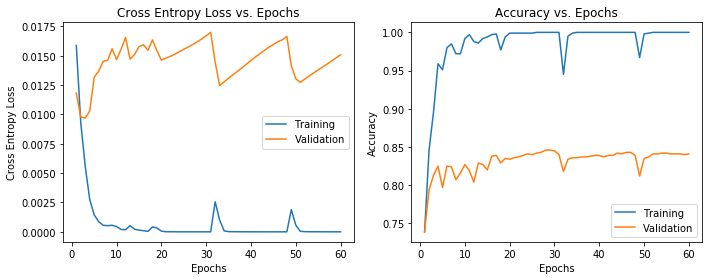

In [221]:
epochs = 60

lr = 1.1244e-03
reg_list = [7.8465e-07]

for reg in reg_list:
    
    best_val_acc=0.0
    model = generator().type(gpu_dtype)

    loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

    start = time.time()
    
    file_name = 'model2'+'_reg='+str(reg)+'lr='+str(lr)+'ep='+str(epochs)+'bestacc.pt'
    best_val_acc, results = train_detailed(model, loss_fn, optimizer, file_name, 
                                                    num_epochs=epochs, verbose=False)

    end = time.time()
    
    print('Regularization = {}.'.format(reg))    
    print('Best validation accuracy is {0}. Training time for {1} epochs: {2:.2f} sec'.format(best_val_acc, 
                                                                                              epochs, end-start))

    # Plot out the accuracies and losses
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(list(range(1,len(np.array(results)[:,2])+1)), np.array(results)[:,2], label='Training')
    plt.plot(list(range(1,len(np.array(results)[:,3])+1)), np.array(results)[:,3], label='Validation')
    plt.title('Cross Entropy Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Cross Entropy Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(list(range(1,len(np.array(results)[:,0])+1)), np.array(results)[:,0], label='Training')
    plt.plot(list(range(1,len(np.array(results)[:,1])+1)), np.array(results)[:,1], label='Validation')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()

    #plt.savefig('sgd_model_plot_batch_norm_hidden_256x256.png')
    plt.show()

## Annealing LR every Epoch

Starting epoch 1 / 60
better val accuracy: update model.
progress: [0.734, 0.743, 0.015158432618087652, 0.011324201583862305]
Starting epoch 2 / 60
better val accuracy: update model.
progress: [0.847, 0.809, 0.008760416875992503, 0.009579113334417343]
Starting epoch 3 / 60
better val accuracy: update model.
progress: [0.912, 0.815, 0.00508077631845158, 0.009630706191062927]
Starting epoch 4 / 60
progress: [0.952, 0.796, 0.0023081470705872895, 0.011343611627817154]
Starting epoch 5 / 60
better val accuracy: update model.
progress: [0.975, 0.831, 0.0011772374186512767, 0.011106735825538635]
Starting epoch 6 / 60
better val accuracy: update model.
progress: [0.986, 0.832, 0.0006876657743158998, 0.012234090596437455]
Starting epoch 7 / 60
progress: [0.983, 0.828, 0.0005101933865807951, 0.012917673826217651]
Starting epoch 8 / 60
progress: [0.983, 0.825, 0.0003398714441977137, 0.013335354089736939]
Starting epoch 9 / 60
progress: [0.982, 0.818, 0.0003475405068649929, 0.014711096405982971]
S

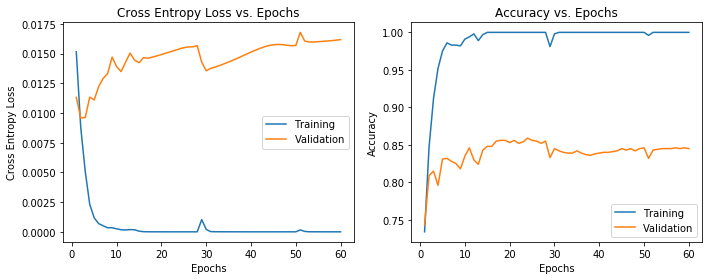

In [222]:
def train_detailed(model, loss_fn, optimizer, filename, num_epochs = 10, verbose=False):
    # Train the model in greater detail - output validation and train accuracy every epoch
    
    train_history = []   # this will store train accuracy, val accuracy and loss for every epoch
    best_val_acc = 0.0  # initialize best_val_acc

    scheduler = StepLR(optimizer, step_size=1, gamma=0.95)   # decay lr by 0.95 every epoch 
    
    for epoch in range(num_epochs):        
        
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
            
        scheduler.step()    
        model.train()
        
        train_lossSum = 0 
        train_total = 0
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())
            train_total += y_var.size(0)

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            train_lossSum += loss.data[0]  # Accumulate loss over epoch
            
            if (t + 1) % print_every == 0 and verbose:
                print('t = %d, loss = %.6f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
       
        # We calculate validation and training accuracy at the end of every epoch
        val_acc = check_accuracy(model, loader_val) 
        train_acc = check_accuracy(model, loader_train_small)

        # Compute validation loss    
        val_lossSum = 0.0
        val_total = 0
        for t, (x, y) in enumerate(loader_val):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())
            val_total += y_var.size(0)
            
            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            val_lossSum += loss.data[0]
        
        if val_acc > best_val_acc:  
            # save your model 
            print ("better val accuracy: update model.")
            torch.save(model.state_dict(), filename)
            best_val_acc = val_acc 
        
        print("progress:",[train_acc,val_acc, train_lossSum/train_total,val_lossSum/val_total])
        train_history.append([train_acc,val_acc,train_lossSum/train_total,val_lossSum/val_total])
        
    return best_val_acc, train_history 
 
epochs = 60

lr = 1.1244e-03
reg_list = [7.8465e-07]

for reg in reg_list:
    
    best_val_acc=0.0
    model = generator().type(gpu_dtype)

    loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

    start = time.time()
    
    file_name = 'model2'+'_reg='+str(reg)+'lr='+str(lr)+'ep='+str(epochs)+'bestacc.pt'
    best_val_acc, results = train_detailed(model, loss_fn, optimizer, file_name, 
                                                    num_epochs=epochs, verbose=False)

    end = time.time()
    
    print('Regularization = {}.'.format(reg))    
    print('Best validation accuracy is {0}. Training time for {1} epochs: {2:.2f} sec'.format(best_val_acc, 
                                                                                              epochs, end-start))

    # Plot out the accuracies and losses
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(list(range(1,len(np.array(results)[:,2])+1)), np.array(results)[:,2], label='Training')
    plt.plot(list(range(1,len(np.array(results)[:,3])+1)), np.array(results)[:,3], label='Validation')
    plt.title('Cross Entropy Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Cross Entropy Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(list(range(1,len(np.array(results)[:,0])+1)), np.array(results)[:,0], label='Training')
    plt.plot(list(range(1,len(np.array(results)[:,1])+1)), np.array(results)[:,1], label='Validation')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()

    #plt.savefig('sgd_model_plot_batch_norm_hidden_256x256.png')
    plt.show()

In [8]:
print ("The total number of parameters:", sum([param.nelement() for param in model.parameters()]))

for name, param in model.named_parameters():
    print (name)
    print (param.nelement())

The total number of parameters: 4479562
0.weight
864
0.bias
32
2.weight
32
2.bias
32
3.weight
18432
3.bias
64
5.weight
64
5.bias
64
6.weight
36864
6.bias
64
8.weight
64
8.bias
64
10.weight
73728
10.bias
128
12.weight
128
12.bias
128
13.weight
147456
13.bias
128
15.weight
128
15.bias
128
18.weight
4194304
18.bias
512
19.weight
512
19.bias
512
21.weight
5120
21.bias
10


## Training Code - Chris Lamb

In [ ]:
train_loss_curve = []
train_accuracy_curve = []
val_loss_curve = []
val_accuracy_curve = []

for epoch in range(50):
    # Train epoch/ Compute training loss
    train_accumulated_loss = 0.0
    for data in train:
        inputs, labels = data
        if cuda:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_accumulated_loss += loss.data[0]
        
    # Compute training accuracy
    train_correct = 0
    train_total = 0
    for data in train:
        images, labels = data
        if cuda:
            images = images.cuda()
            labels = labels.cuda()

        images = Variable(images)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum()
        
    # Compute validation loss    
    val_accumulated_loss = 0.0
    for data in val:
        inputs, labels = data
        if cuda:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_accumulated_loss += loss.data[0]
        
    # Compute validation accuracy
    val_correct = 0
    val_total = 0
    for data in val:
        images, labels = data
        if cuda:
            images = images.cuda()
            labels = labels.cuda()

        images = Variable(images)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum()
    
    # Compute training statistics
    train_loss = train_accumulated_loss / train_total    
    train_loss_curve.append(train_loss)
    train_accuracy = train_correct / (1.0*train_total)
    train_accuracy_curve.append(train_accuracy)
    
    # Compute validation statistics
    val_loss = val_accumulated_loss / val_total    
    val_loss_curve.append(val_loss)
    val_accuracy = val_correct / (1.0*val_total)
    val_accuracy_curve.append(val_accuracy)
    
    # Print statistics
    print('Epoch: {} Train Loss: {:.3f} Train Accuracy: {:.3f} Valid Loss: {:.3f} Valid Accuracy: {:.3f}'.format(
          epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy))

print('Finished Training')